In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_CAP_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(701688, 829)
(701688, 8)
validation
(129856, 829)
(129856, 8)
test
(60456, 829)
(60456, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1539976 (5.87 MB)


Trainable params: 1539976 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/71 [..............................] - ETA: 1:37 - loss: 2.2049 - STD: 0.0888 - MAE: 0.2188

 4/71 [>.............................] - ETA: 1s - loss: 1.7515 - STD: 0.1403 - MAE: 0.1794  

 5/71 [=>............................] - ETA: 2s - loss: 1.7044 - STD: 0.1587 - MAE: 0.1710

 6/71 [=>............................] - ETA: 2s - loss: 1.6737 - STD: 0.1711 - MAE: 0.1655

 7/71 [=>............................] - ETA: 2s - loss: 1.6410 - STD: 0.1785 - MAE: 0.1618

 8/71 [==>...........................] - ETA: 2s - loss: 1.6131 - STD: 0.1820 - MAE: 0.1597

 9/71 [==>...........................] - ETA: 2s - loss: 1.5900 - STD: 0.1823 - MAE: 0.1589

10/71 [===>..........................] - ETA: 2s - loss: 1.5730 - STD: 0.1806 - MAE: 0.1591

11/71 [===>..........................] - ETA: 2s - loss: 1.5597 - STD: 0.1779 - MAE: 0.1597

12/71 [====>.........................] - ETA: 2s - loss: 1.5492 - STD: 0.1751 - MAE: 0.1604

13/71 [====>.........................] - ETA: 2s - loss: 1.5401 - STD: 0.1727 - MAE: 0.1610

14/71 [====>.........................] - ETA: 2s - loss: 1.5329 - STD: 0.1710 - MAE: 0.1614

15/71 [=====>........................] - ETA: 2s - loss: 1.5252 - STD: 0.1702 - MAE: 0.1614

16/71 [=====>........................] - ETA: 2s - loss: 1.5188 - STD: 0.1703 - MAE: 0.1612

17/71 [======>.......................] - ETA: 2s - loss: 1.5126 - STD: 0.1711 - MAE: 0.1608

18/71 [======>.......................] - ETA: 2s - loss: 1.5078 - STD: 0.1724 - MAE: 0.1602

19/71 [=======>......................] - ETA: 2s - loss: 1.5037 - STD: 0.1739 - MAE: 0.1595

20/71 [=======>......................] - ETA: 2s - loss: 1.5001 - STD: 0.1756 - MAE: 0.1588

21/71 [=======>......................] - ETA: 2s - loss: 1.4961 - STD: 0.1771 - MAE: 0.1581

22/71 [========>.....................] - ETA: 2s - loss: 1.4932 - STD: 0.1784 - MAE: 0.1575

23/71 [========>.....................] - ETA: 2s - loss: 1.4892 - STD: 0.1794 - MAE: 0.1570

24/71 [=========>....................] - ETA: 2s - loss: 1.4854 - STD: 0.1801 - MAE: 0.1567

25/71 [=========>....................] - ETA: 2s - loss: 1.4824 - STD: 0.1804 - MAE: 0.1565

26/71 [=========>....................] - ETA: 2s - loss: 1.4793 - STD: 0.1803 - MAE: 0.1564

27/71 [==========>...................] - ETA: 2s - loss: 1.4764 - STD: 0.1801 - MAE: 0.1564

28/71 [==========>...................] - ETA: 3s - loss: 1.4758 - STD: 0.1797 - MAE: 0.1564

32/71 [============>.................] - ETA: 2s - loss: 1.4661 - STD: 0.1783 - MAE: 0.1566

33/71 [============>.................] - ETA: 2s - loss: 1.4640 - STD: 0.1782 - MAE: 0.1566

34/71 [=============>................] - ETA: 2s - loss: 1.4617 - STD: 0.1783 - MAE: 0.1565

35/71 [=============>................] - ETA: 2s - loss: 1.4589 - STD: 0.1785 - MAE: 0.1563

36/71 [==============>...............] - ETA: 2s - loss: 1.4573 - STD: 0.1788 - MAE: 0.1562

37/71 [==============>...............] - ETA: 2s - loss: 1.4560 - STD: 0.1791 - MAE: 0.1561

38/71 [===============>..............] - ETA: 2s - loss: 1.4545 - STD: 0.1794 - MAE: 0.1559

39/71 [===============>..............] - ETA: 2s - loss: 1.4533 - STD: 0.1796 - MAE: 0.1558

40/71 [===============>..............] - ETA: 1s - loss: 1.4525 - STD: 0.1798 - MAE: 0.1557

41/71 [================>.............] - ETA: 1s - loss: 1.4514 - STD: 0.1799 - MAE: 0.1557

42/71 [================>.............] - ETA: 1s - loss: 1.4501 - STD: 0.1798 - MAE: 0.1557

43/71 [=================>............] - ETA: 1s - loss: 1.4489 - STD: 0.1797 - MAE: 0.1557

44/71 [=================>............] - ETA: 1s - loss: 1.4474 - STD: 0.1796 - MAE: 0.1557

45/71 [==================>...........] - ETA: 1s - loss: 1.4461 - STD: 0.1794 - MAE: 0.1557

46/71 [==================>...........] - ETA: 1s - loss: 1.4452 - STD: 0.1792 - MAE: 0.1557

47/71 [==================>...........] - ETA: 1s - loss: 1.4439 - STD: 0.1790 - MAE: 0.1558

48/71 [===================>..........] - ETA: 1s - loss: 1.4431 - STD: 0.1789 - MAE: 0.1558

49/71 [===================>..........] - ETA: 1s - loss: 1.4419 - STD: 0.1789 - MAE: 0.1558

50/71 [====================>.........] - ETA: 1s - loss: 1.4411 - STD: 0.1789 - MAE: 0.1557

51/71 [====================>.........] - ETA: 1s - loss: 1.4398 - STD: 0.1789 - MAE: 0.1557

52/71 [====================>.........] - ETA: 1s - loss: 1.4386 - STD: 0.1790 - MAE: 0.1556

53/71 [=====================>........] - ETA: 1s - loss: 1.4378 - STD: 0.1791 - MAE: 0.1556

54/71 [=====================>........] - ETA: 1s - loss: 1.4371 - STD: 0.1792 - MAE: 0.1555

55/71 [======================>.......] - ETA: 0s - loss: 1.4366 - STD: 0.1793 - MAE: 0.1555

56/71 [======================>.......] - ETA: 0s - loss: 1.4357 - STD: 0.1793 - MAE: 0.1554

57/71 [=======================>......] - ETA: 0s - loss: 1.4349 - STD: 0.1793 - MAE: 0.1554

58/71 [=======================>......] - ETA: 0s - loss: 1.4339 - STD: 0.1793 - MAE: 0.1554

59/71 [=======================>......] - ETA: 0s - loss: 1.4333 - STD: 0.1792 - MAE: 0.1554

60/71 [========================>.....] - ETA: 0s - loss: 1.4326 - STD: 0.1792 - MAE: 0.1554

61/71 [========================>.....] - ETA: 0s - loss: 1.4319 - STD: 0.1791 - MAE: 0.1554

62/71 [=========================>....] - ETA: 0s - loss: 1.4311 - STD: 0.1790 - MAE: 0.1554

63/71 [=========================>....] - ETA: 0s - loss: 1.4304 - STD: 0.1790 - MAE: 0.1553

64/71 [==========================>...] - ETA: 0s - loss: 1.4296 - STD: 0.1790 - MAE: 0.1553

65/71 [==========================>...] - ETA: 0s - loss: 1.4290 - STD: 0.1791 - MAE: 0.1553

66/71 [==========================>...] - ETA: 0s - loss: 1.4284 - STD: 0.1791 - MAE: 0.1553

67/71 [===========================>..] - ETA: 0s - loss: 1.4280 - STD: 0.1792 - MAE: 0.1552

68/71 [===========================>..] - ETA: 0s - loss: 1.4274 - STD: 0.1792 - MAE: 0.1552

69/71 [============================>.] - ETA: 0s - loss: 1.4267 - STD: 0.1792 - MAE: 0.1552

70/71 [============================>.] - ETA: 0s - loss: 1.4261 - STD: 0.1792 - MAE: 0.1551

71/71 [==============================] - ETA: 0s - loss: 1.4256 - STD: 0.1791 - MAE: 0.1551

71/71 [==============================] - 6s 70ms/step - loss: 1.4256 - STD: 0.1791 - MAE: 0.1551 - val_loss: 1.3102 - val_STD: 0.1768 - val_MAE: 0.1495


Epoch 2/10000


 1/71 [..............................] - ETA: 5s - loss: 1.3790 - STD: 0.1756 - MAE: 0.1547

 2/71 [..............................] - ETA: 4s - loss: 1.3771 - STD: 0.1757 - MAE: 0.1546

 3/71 [>.............................] - ETA: 4s - loss: 1.3766 - STD: 0.1760 - MAE: 0.1544

 4/71 [>.............................] - ETA: 4s - loss: 1.3741 - STD: 0.1765 - MAE: 0.1541

 5/71 [=>............................] - ETA: 4s - loss: 1.3749 - STD: 0.1771 - MAE: 0.1539

 6/71 [=>............................] - ETA: 3s - loss: 1.3732 - STD: 0.1778 - MAE: 0.1536

 7/71 [=>............................] - ETA: 3s - loss: 1.3732 - STD: 0.1783 - MAE: 0.1534

 8/71 [==>...........................] - ETA: 3s - loss: 1.3723 - STD: 0.1784 - MAE: 0.1533

 9/71 [==>...........................] - ETA: 3s - loss: 1.3712 - STD: 0.1784 - MAE: 0.1532

10/71 [===>..........................] - ETA: 3s - loss: 1.3687 - STD: 0.1784 - MAE: 0.1530

11/71 [===>..........................] - ETA: 3s - loss: 1.3668 - STD: 0.1786 - MAE: 0.1529

12/71 [====>.........................] - ETA: 3s - loss: 1.3659 - STD: 0.1788 - MAE: 0.1528

13/71 [====>.........................] - ETA: 3s - loss: 1.3640 - STD: 0.1791 - MAE: 0.1525

14/71 [====>.........................] - ETA: 3s - loss: 1.3614 - STD: 0.1795 - MAE: 0.1522

15/71 [=====>........................] - ETA: 3s - loss: 1.3601 - STD: 0.1800 - MAE: 0.1520

16/71 [=====>........................] - ETA: 3s - loss: 1.3582 - STD: 0.1803 - MAE: 0.1518

17/71 [======>.......................] - ETA: 3s - loss: 1.3574 - STD: 0.1807 - MAE: 0.1516

18/71 [======>.......................] - ETA: 3s - loss: 1.3572 - STD: 0.1809 - MAE: 0.1515

19/71 [=======>......................] - ETA: 3s - loss: 1.3554 - STD: 0.1811 - MAE: 0.1514

20/71 [=======>......................] - ETA: 3s - loss: 1.3541 - STD: 0.1812 - MAE: 0.1512

21/71 [=======>......................] - ETA: 2s - loss: 1.3519 - STD: 0.1815 - MAE: 0.1510

22/71 [========>.....................] - ETA: 2s - loss: 1.3517 - STD: 0.1820 - MAE: 0.1508

24/71 [=========>....................] - ETA: 2s - loss: 1.3507 - STD: 0.1828 - MAE: 0.1503

25/71 [=========>....................] - ETA: 2s - loss: 1.3497 - STD: 0.1830 - MAE: 0.1502

26/71 [=========>....................] - ETA: 2s - loss: 1.3488 - STD: 0.1830 - MAE: 0.1502

27/71 [==========>...................] - ETA: 2s - loss: 1.3471 - STD: 0.1830 - MAE: 0.1501

28/71 [==========>...................] - ETA: 2s - loss: 1.3462 - STD: 0.1831 - MAE: 0.1500

29/71 [===========>..................] - ETA: 2s - loss: 1.3446 - STD: 0.1834 - MAE: 0.1499

30/71 [===========>..................] - ETA: 2s - loss: 1.3438 - STD: 0.1837 - MAE: 0.1498

31/71 [============>.................] - ETA: 2s - loss: 1.3432 - STD: 0.1838 - MAE: 0.1497

32/71 [============>.................] - ETA: 2s - loss: 1.3422 - STD: 0.1838 - MAE: 0.1497

33/71 [============>.................] - ETA: 2s - loss: 1.3413 - STD: 0.1839 - MAE: 0.1496

34/71 [=============>................] - ETA: 2s - loss: 1.3400 - STD: 0.1841 - MAE: 0.1495

35/71 [=============>................] - ETA: 2s - loss: 1.3391 - STD: 0.1843 - MAE: 0.1494

36/71 [==============>...............] - ETA: 2s - loss: 1.3379 - STD: 0.1845 - MAE: 0.1493

37/71 [==============>...............] - ETA: 1s - loss: 1.3363 - STD: 0.1846 - MAE: 0.1492

38/71 [===============>..............] - ETA: 1s - loss: 1.3353 - STD: 0.1847 - MAE: 0.1492

39/71 [===============>..............] - ETA: 1s - loss: 1.3340 - STD: 0.1848 - MAE: 0.1491

40/71 [===============>..............] - ETA: 1s - loss: 1.3331 - STD: 0.1849 - MAE: 0.1490

41/71 [================>.............] - ETA: 1s - loss: 1.3318 - STD: 0.1851 - MAE: 0.1489

42/71 [================>.............] - ETA: 1s - loss: 1.3306 - STD: 0.1852 - MAE: 0.1488

43/71 [=================>............] - ETA: 1s - loss: 1.3291 - STD: 0.1854 - MAE: 0.1487

44/71 [=================>............] - ETA: 1s - loss: 1.3279 - STD: 0.1855 - MAE: 0.1486

45/71 [==================>...........] - ETA: 1s - loss: 1.3269 - STD: 0.1857 - MAE: 0.1485

46/71 [==================>...........] - ETA: 1s - loss: 1.3256 - STD: 0.1858 - MAE: 0.1484

47/71 [==================>...........] - ETA: 1s - loss: 1.3247 - STD: 0.1858 - MAE: 0.1484

48/71 [===================>..........] - ETA: 1s - loss: 1.3235 - STD: 0.1859 - MAE: 0.1483

49/71 [===================>..........] - ETA: 1s - loss: 1.3224 - STD: 0.1861 - MAE: 0.1482

50/71 [====================>.........] - ETA: 1s - loss: 1.3212 - STD: 0.1862 - MAE: 0.1482

51/71 [====================>.........] - ETA: 1s - loss: 1.3201 - STD: 0.1862 - MAE: 0.1481

52/71 [====================>.........] - ETA: 1s - loss: 1.3188 - STD: 0.1863 - MAE: 0.1481

53/71 [=====================>........] - ETA: 1s - loss: 1.3175 - STD: 0.1865 - MAE: 0.1479

54/71 [=====================>........] - ETA: 0s - loss: 1.3164 - STD: 0.1866 - MAE: 0.1479

55/71 [======================>.......] - ETA: 0s - loss: 1.3152 - STD: 0.1867 - MAE: 0.1478

56/71 [======================>.......] - ETA: 0s - loss: 1.3142 - STD: 0.1867 - MAE: 0.1478

57/71 [=======================>......] - ETA: 0s - loss: 1.3133 - STD: 0.1868 - MAE: 0.1477

58/71 [=======================>......] - ETA: 0s - loss: 1.3122 - STD: 0.1869 - MAE: 0.1477

59/71 [=======================>......] - ETA: 0s - loss: 1.3113 - STD: 0.1869 - MAE: 0.1476

60/71 [========================>.....] - ETA: 0s - loss: 1.3101 - STD: 0.1869 - MAE: 0.1476

61/71 [========================>.....] - ETA: 0s - loss: 1.3089 - STD: 0.1870 - MAE: 0.1475

62/71 [=========================>....] - ETA: 0s - loss: 1.3080 - STD: 0.1871 - MAE: 0.1474

63/71 [=========================>....] - ETA: 0s - loss: 1.3068 - STD: 0.1872 - MAE: 0.1474

64/71 [==========================>...] - ETA: 0s - loss: 1.3058 - STD: 0.1873 - MAE: 0.1473

65/71 [==========================>...] - ETA: 0s - loss: 1.3045 - STD: 0.1873 - MAE: 0.1473

66/71 [==========================>...] - ETA: 0s - loss: 1.3035 - STD: 0.1874 - MAE: 0.1472

67/71 [===========================>..] - ETA: 0s - loss: 1.3023 - STD: 0.1875 - MAE: 0.1471

68/71 [===========================>..] - ETA: 0s - loss: 1.3014 - STD: 0.1875 - MAE: 0.1471

69/71 [============================>.] - ETA: 0s - loss: 1.3005 - STD: 0.1875 - MAE: 0.1471

70/71 [============================>.] - ETA: 0s - loss: 1.2993 - STD: 0.1876 - MAE: 0.1470

71/71 [==============================] - ETA: 0s - loss: 1.2984 - STD: 0.1877 - MAE: 0.1470

71/71 [==============================] - 4s 61ms/step - loss: 1.2984 - STD: 0.1877 - MAE: 0.1470 - val_loss: 1.1471 - val_STD: 0.1913 - val_MAE: 0.1373


Epoch 3/10000


 1/71 [..............................] - ETA: 6s - loss: 1.2089 - STD: 0.1902 - MAE: 0.1429

 2/71 [..............................] - ETA: 3s - loss: 1.2210 - STD: 0.1912 - MAE: 0.1431

 3/71 [>.............................] - ETA: 3s - loss: 1.2223 - STD: 0.1927 - MAE: 0.1428

 4/71 [>.............................] - ETA: 3s - loss: 1.2268 - STD: 0.1932 - MAE: 0.1429

 5/71 [=>............................] - ETA: 3s - loss: 1.2274 - STD: 0.1920 - MAE: 0.1434

 6/71 [=>............................] - ETA: 3s - loss: 1.2265 - STD: 0.1919 - MAE: 0.1434

 7/71 [=>............................] - ETA: 3s - loss: 1.2280 - STD: 0.1922 - MAE: 0.1433

 8/71 [==>...........................] - ETA: 3s - loss: 1.2247 - STD: 0.1921 - MAE: 0.1433

 9/71 [==>...........................] - ETA: 3s - loss: 1.2253 - STD: 0.1918 - MAE: 0.1434

10/71 [===>..........................] - ETA: 3s - loss: 1.2222 - STD: 0.1923 - MAE: 0.1431

11/71 [===>..........................] - ETA: 3s - loss: 1.2223 - STD: 0.1929 - MAE: 0.1429

12/71 [====>.........................] - ETA: 3s - loss: 1.2208 - STD: 0.1929 - MAE: 0.1428

13/71 [====>.........................] - ETA: 3s - loss: 1.2196 - STD: 0.1926 - MAE: 0.1429

14/71 [====>.........................] - ETA: 3s - loss: 1.2183 - STD: 0.1927 - MAE: 0.1428

15/71 [=====>........................] - ETA: 3s - loss: 1.2173 - STD: 0.1929 - MAE: 0.1427

16/71 [=====>........................] - ETA: 3s - loss: 1.2160 - STD: 0.1929 - MAE: 0.1426

17/71 [======>.......................] - ETA: 3s - loss: 1.2163 - STD: 0.1930 - MAE: 0.1426

18/71 [======>.......................] - ETA: 3s - loss: 1.2146 - STD: 0.1932 - MAE: 0.1425

19/71 [=======>......................] - ETA: 3s - loss: 1.2137 - STD: 0.1934 - MAE: 0.1424

20/71 [=======>......................] - ETA: 2s - loss: 1.2127 - STD: 0.1933 - MAE: 0.1424

21/71 [=======>......................] - ETA: 2s - loss: 1.2109 - STD: 0.1935 - MAE: 0.1423

22/71 [========>.....................] - ETA: 2s - loss: 1.2103 - STD: 0.1936 - MAE: 0.1422

23/71 [========>.....................] - ETA: 2s - loss: 1.2090 - STD: 0.1935 - MAE: 0.1422

24/71 [=========>....................] - ETA: 2s - loss: 1.2082 - STD: 0.1933 - MAE: 0.1423

25/71 [=========>....................] - ETA: 2s - loss: 1.2073 - STD: 0.1935 - MAE: 0.1421

26/71 [=========>....................] - ETA: 2s - loss: 1.2064 - STD: 0.1938 - MAE: 0.1420

27/71 [==========>...................] - ETA: 2s - loss: 1.2055 - STD: 0.1936 - MAE: 0.1420

28/71 [==========>...................] - ETA: 2s - loss: 1.2042 - STD: 0.1936 - MAE: 0.1420

29/71 [===========>..................] - ETA: 2s - loss: 1.2031 - STD: 0.1938 - MAE: 0.1419

30/71 [===========>..................] - ETA: 2s - loss: 1.2018 - STD: 0.1940 - MAE: 0.1417

31/71 [============>.................] - ETA: 2s - loss: 1.2008 - STD: 0.1941 - MAE: 0.1417

32/71 [============>.................] - ETA: 2s - loss: 1.1996 - STD: 0.1940 - MAE: 0.1417

33/71 [============>.................] - ETA: 2s - loss: 1.1982 - STD: 0.1940 - MAE: 0.1417

34/71 [=============>................] - ETA: 2s - loss: 1.1968 - STD: 0.1941 - MAE: 0.1415

35/71 [=============>................] - ETA: 2s - loss: 1.1959 - STD: 0.1943 - MAE: 0.1415

36/71 [==============>...............] - ETA: 2s - loss: 1.1950 - STD: 0.1943 - MAE: 0.1414

37/71 [==============>...............] - ETA: 1s - loss: 1.1942 - STD: 0.1942 - MAE: 0.1415

38/71 [===============>..............] - ETA: 1s - loss: 1.1932 - STD: 0.1941 - MAE: 0.1415

39/71 [===============>..............] - ETA: 1s - loss: 1.1919 - STD: 0.1943 - MAE: 0.1414

40/71 [===============>..............] - ETA: 1s - loss: 1.1908 - STD: 0.1945 - MAE: 0.1413

41/71 [================>.............] - ETA: 1s - loss: 1.1894 - STD: 0.1945 - MAE: 0.1412

42/71 [================>.............] - ETA: 1s - loss: 1.1878 - STD: 0.1946 - MAE: 0.1411

43/71 [=================>............] - ETA: 1s - loss: 1.1857 - STD: 0.1947 - MAE: 0.1410

44/71 [=================>............] - ETA: 1s - loss: 1.1841 - STD: 0.1950 - MAE: 0.1408

45/71 [==================>...........] - ETA: 1s - loss: 1.1824 - STD: 0.1952 - MAE: 0.1407

46/71 [==================>...........] - ETA: 1s - loss: 1.1816 - STD: 0.1953 - MAE: 0.1406

47/71 [==================>...........] - ETA: 1s - loss: 1.1808 - STD: 0.1952 - MAE: 0.1407

48/71 [===================>..........] - ETA: 1s - loss: 1.1797 - STD: 0.1952 - MAE: 0.1406

49/71 [===================>..........] - ETA: 1s - loss: 1.1787 - STD: 0.1955 - MAE: 0.1405

50/71 [====================>.........] - ETA: 1s - loss: 1.1777 - STD: 0.1955 - MAE: 0.1404

51/71 [====================>.........] - ETA: 1s - loss: 1.1765 - STD: 0.1955 - MAE: 0.1404

52/71 [====================>.........] - ETA: 1s - loss: 1.1752 - STD: 0.1957 - MAE: 0.1403

53/71 [=====================>........] - ETA: 1s - loss: 1.1741 - STD: 0.1960 - MAE: 0.1401

54/71 [=====================>........] - ETA: 0s - loss: 1.1730 - STD: 0.1959 - MAE: 0.1401

55/71 [======================>.......] - ETA: 0s - loss: 1.1719 - STD: 0.1958 - MAE: 0.1401

56/71 [======================>.......] - ETA: 0s - loss: 1.1705 - STD: 0.1960 - MAE: 0.1400

57/71 [=======================>......] - ETA: 0s - loss: 1.1696 - STD: 0.1963 - MAE: 0.1398

58/71 [=======================>......] - ETA: 0s - loss: 1.1687 - STD: 0.1963 - MAE: 0.1398

59/71 [=======================>......] - ETA: 0s - loss: 1.1677 - STD: 0.1962 - MAE: 0.1399

60/71 [========================>.....] - ETA: 0s - loss: 1.1666 - STD: 0.1963 - MAE: 0.1397

62/71 [=========================>....] - ETA: 0s - loss: 1.1651 - STD: 0.1968 - MAE: 0.1394

63/71 [=========================>....] - ETA: 0s - loss: 1.1639 - STD: 0.1967 - MAE: 0.1394

64/71 [==========================>...] - ETA: 0s - loss: 1.1627 - STD: 0.1968 - MAE: 0.1393

65/71 [==========================>...] - ETA: 0s - loss: 1.1617 - STD: 0.1970 - MAE: 0.1392

66/71 [==========================>...] - ETA: 0s - loss: 1.1604 - STD: 0.1972 - MAE: 0.1391

67/71 [===========================>..] - ETA: 0s - loss: 1.1594 - STD: 0.1972 - MAE: 0.1391

68/71 [===========================>..] - ETA: 0s - loss: 1.1584 - STD: 0.1973 - MAE: 0.1390

69/71 [============================>.] - ETA: 0s - loss: 1.1572 - STD: 0.1975 - MAE: 0.1388

70/71 [============================>.] - ETA: 0s - loss: 1.1562 - STD: 0.1975 - MAE: 0.1388

71/71 [==============================] - ETA: 0s - loss: 1.1551 - STD: 0.1975 - MAE: 0.1388

71/71 [==============================] - 4s 61ms/step - loss: 1.1551 - STD: 0.1975 - MAE: 0.1388 - val_loss: 1.0079 - val_STD: 0.2158 - val_MAE: 0.1221


Epoch 4/10000


 1/71 [..............................] - ETA: 5s - loss: 1.0619 - STD: 0.2162 - MAE: 0.1275

 2/71 [..............................] - ETA: 4s - loss: 1.0692 - STD: 0.2139 - MAE: 0.1287

 3/71 [>.............................] - ETA: 4s - loss: 1.0670 - STD: 0.2070 - MAE: 0.1314

 4/71 [>.............................] - ETA: 4s - loss: 1.0644 - STD: 0.2057 - MAE: 0.1318

 5/71 [=>............................] - ETA: 3s - loss: 1.0686 - STD: 0.2086 - MAE: 0.1308

 6/71 [=>............................] - ETA: 3s - loss: 1.0690 - STD: 0.2078 - MAE: 0.1311

 7/71 [=>............................] - ETA: 3s - loss: 1.0688 - STD: 0.2058 - MAE: 0.1320

 8/71 [==>...........................] - ETA: 3s - loss: 1.0693 - STD: 0.2064 - MAE: 0.1318

 9/71 [==>...........................] - ETA: 3s - loss: 1.0696 - STD: 0.2071 - MAE: 0.1315

10/71 [===>..........................] - ETA: 3s - loss: 1.0666 - STD: 0.2066 - MAE: 0.1316

11/71 [===>..........................] - ETA: 3s - loss: 1.0652 - STD: 0.2066 - MAE: 0.1315

12/71 [====>.........................] - ETA: 3s - loss: 1.0639 - STD: 0.2069 - MAE: 0.1313

13/71 [====>.........................] - ETA: 3s - loss: 1.0619 - STD: 0.2070 - MAE: 0.1312

14/71 [====>.........................] - ETA: 3s - loss: 1.0618 - STD: 0.2070 - MAE: 0.1312

15/71 [=====>........................] - ETA: 3s - loss: 1.0613 - STD: 0.2068 - MAE: 0.1313

16/71 [=====>........................] - ETA: 3s - loss: 1.0610 - STD: 0.2070 - MAE: 0.1312

17/71 [======>.......................] - ETA: 2s - loss: 1.0596 - STD: 0.2070 - MAE: 0.1311

18/71 [======>.......................] - ETA: 2s - loss: 1.0577 - STD: 0.2069 - MAE: 0.1311

19/71 [=======>......................] - ETA: 2s - loss: 1.0568 - STD: 0.2072 - MAE: 0.1309

20/71 [=======>......................] - ETA: 2s - loss: 1.0556 - STD: 0.2075 - MAE: 0.1307

21/71 [=======>......................] - ETA: 2s - loss: 1.0547 - STD: 0.2073 - MAE: 0.1307

22/71 [========>.....................] - ETA: 2s - loss: 1.0535 - STD: 0.2075 - MAE: 0.1306

23/71 [========>.....................] - ETA: 2s - loss: 1.0529 - STD: 0.2079 - MAE: 0.1304

24/71 [=========>....................] - ETA: 2s - loss: 1.0522 - STD: 0.2077 - MAE: 0.1304

25/71 [=========>....................] - ETA: 2s - loss: 1.0510 - STD: 0.2079 - MAE: 0.1303

26/71 [=========>....................] - ETA: 2s - loss: 1.0493 - STD: 0.2083 - MAE: 0.1300

27/71 [==========>...................] - ETA: 2s - loss: 1.0481 - STD: 0.2084 - MAE: 0.1299

28/71 [==========>...................] - ETA: 2s - loss: 1.0476 - STD: 0.2084 - MAE: 0.1299

29/71 [===========>..................] - ETA: 2s - loss: 1.0465 - STD: 0.2085 - MAE: 0.1298

30/71 [===========>..................] - ETA: 2s - loss: 1.0453 - STD: 0.2088 - MAE: 0.1296

31/71 [============>.................] - ETA: 2s - loss: 1.0446 - STD: 0.2088 - MAE: 0.1296

32/71 [============>.................] - ETA: 2s - loss: 1.0435 - STD: 0.2088 - MAE: 0.1295

33/71 [============>.................] - ETA: 2s - loss: 1.0430 - STD: 0.2090 - MAE: 0.1295

34/71 [=============>................] - ETA: 2s - loss: 1.0421 - STD: 0.2090 - MAE: 0.1294

35/71 [=============>................] - ETA: 2s - loss: 1.0410 - STD: 0.2091 - MAE: 0.1293

36/71 [==============>...............] - ETA: 1s - loss: 1.0403 - STD: 0.2092 - MAE: 0.1292

37/71 [==============>...............] - ETA: 1s - loss: 1.0397 - STD: 0.2093 - MAE: 0.1292

38/71 [===============>..............] - ETA: 1s - loss: 1.0389 - STD: 0.2092 - MAE: 0.1292

40/71 [===============>..............] - ETA: 1s - loss: 1.0378 - STD: 0.2095 - MAE: 0.1290

41/71 [================>.............] - ETA: 1s - loss: 1.0370 - STD: 0.2095 - MAE: 0.1290

42/71 [================>.............] - ETA: 1s - loss: 1.0368 - STD: 0.2097 - MAE: 0.1289

43/71 [=================>............] - ETA: 1s - loss: 1.0361 - STD: 0.2097 - MAE: 0.1289

44/71 [=================>............] - ETA: 1s - loss: 1.0351 - STD: 0.2098 - MAE: 0.1288

45/71 [==================>...........] - ETA: 1s - loss: 1.0348 - STD: 0.2101 - MAE: 0.1287

46/71 [==================>...........] - ETA: 1s - loss: 1.0341 - STD: 0.2099 - MAE: 0.1288

47/71 [==================>...........] - ETA: 1s - loss: 1.0335 - STD: 0.2099 - MAE: 0.1287

48/71 [===================>..........] - ETA: 1s - loss: 1.0327 - STD: 0.2102 - MAE: 0.1286

49/71 [===================>..........] - ETA: 1s - loss: 1.0322 - STD: 0.2102 - MAE: 0.1286

50/71 [====================>.........] - ETA: 1s - loss: 1.0315 - STD: 0.2101 - MAE: 0.1286

51/71 [====================>.........] - ETA: 1s - loss: 1.0308 - STD: 0.2102 - MAE: 0.1285

52/71 [====================>.........] - ETA: 1s - loss: 1.0297 - STD: 0.2105 - MAE: 0.1283

53/71 [=====================>........] - ETA: 0s - loss: 1.0291 - STD: 0.2104 - MAE: 0.1283

54/71 [=====================>........] - ETA: 0s - loss: 1.0285 - STD: 0.2104 - MAE: 0.1283

55/71 [======================>.......] - ETA: 0s - loss: 1.0282 - STD: 0.2105 - MAE: 0.1283

56/71 [======================>.......] - ETA: 0s - loss: 1.0276 - STD: 0.2106 - MAE: 0.1282

57/71 [=======================>......] - ETA: 0s - loss: 1.0268 - STD: 0.2106 - MAE: 0.1282

58/71 [=======================>......] - ETA: 0s - loss: 1.0261 - STD: 0.2107 - MAE: 0.1281

59/71 [=======================>......] - ETA: 0s - loss: 1.0253 - STD: 0.2108 - MAE: 0.1280

60/71 [========================>.....] - ETA: 0s - loss: 1.0248 - STD: 0.2108 - MAE: 0.1280

61/71 [========================>.....] - ETA: 0s - loss: 1.0241 - STD: 0.2108 - MAE: 0.1280

62/71 [=========================>....] - ETA: 0s - loss: 1.0236 - STD: 0.2110 - MAE: 0.1279

63/71 [=========================>....] - ETA: 0s - loss: 1.0225 - STD: 0.2110 - MAE: 0.1278

64/71 [==========================>...] - ETA: 0s - loss: 1.0216 - STD: 0.2111 - MAE: 0.1277

65/71 [==========================>...] - ETA: 0s - loss: 1.0210 - STD: 0.2112 - MAE: 0.1277

66/71 [==========================>...] - ETA: 0s - loss: 1.0205 - STD: 0.2113 - MAE: 0.1276

67/71 [===========================>..] - ETA: 0s - loss: 1.0200 - STD: 0.2113 - MAE: 0.1276

68/71 [===========================>..] - ETA: 0s - loss: 1.0193 - STD: 0.2113 - MAE: 0.1276

69/71 [============================>.] - ETA: 0s - loss: 1.0186 - STD: 0.2115 - MAE: 0.1275

70/71 [============================>.] - ETA: 0s - loss: 1.0179 - STD: 0.2115 - MAE: 0.1275

71/71 [==============================] - ETA: 0s - loss: 1.0173 - STD: 0.2115 - MAE: 0.1274

71/71 [==============================] - 4s 61ms/step - loss: 1.0173 - STD: 0.2115 - MAE: 0.1274 - val_loss: 0.9508 - val_STD: 0.2140 - val_MAE: 0.1208


Epoch 5/10000


 1/71 [..............................] - ETA: 6s - loss: 0.9783 - STD: 0.2177 - MAE: 0.1235

 2/71 [..............................] - ETA: 4s - loss: 0.9742 - STD: 0.2173 - MAE: 0.1233

 3/71 [>.............................] - ETA: 4s - loss: 0.9730 - STD: 0.2159 - MAE: 0.1238

 4/71 [>.............................] - ETA: 4s - loss: 0.9705 - STD: 0.2160 - MAE: 0.1237

 5/71 [=>............................] - ETA: 4s - loss: 0.9690 - STD: 0.2166 - MAE: 0.1233

 6/71 [=>............................] - ETA: 4s - loss: 0.9690 - STD: 0.2166 - MAE: 0.1233

 7/71 [=>............................] - ETA: 4s - loss: 0.9679 - STD: 0.2164 - MAE: 0.1233

 8/71 [==>...........................] - ETA: 4s - loss: 0.9676 - STD: 0.2170 - MAE: 0.1230

 9/71 [==>...........................] - ETA: 4s - loss: 0.9675 - STD: 0.2171 - MAE: 0.1230

10/71 [===>..........................] - ETA: 4s - loss: 0.9670 - STD: 0.2167 - MAE: 0.1231

11/71 [===>..........................] - ETA: 3s - loss: 0.9664 - STD: 0.2171 - MAE: 0.1230

12/71 [====>.........................] - ETA: 3s - loss: 0.9670 - STD: 0.2175 - MAE: 0.1228

13/71 [====>.........................] - ETA: 3s - loss: 0.9664 - STD: 0.2168 - MAE: 0.1231

14/71 [====>.........................] - ETA: 3s - loss: 0.9669 - STD: 0.2174 - MAE: 0.1229

15/71 [=====>........................] - ETA: 3s - loss: 0.9661 - STD: 0.2174 - MAE: 0.1228

16/71 [=====>........................] - ETA: 3s - loss: 0.9660 - STD: 0.2171 - MAE: 0.1230

18/71 [======>.......................] - ETA: 3s - loss: 0.9655 - STD: 0.2177 - MAE: 0.1226

19/71 [=======>......................] - ETA: 3s - loss: 0.9657 - STD: 0.2171 - MAE: 0.1228

20/71 [=======>......................] - ETA: 3s - loss: 0.9654 - STD: 0.2177 - MAE: 0.1226

21/71 [=======>......................] - ETA: 3s - loss: 0.9649 - STD: 0.2178 - MAE: 0.1225

22/71 [========>.....................] - ETA: 3s - loss: 0.9647 - STD: 0.2176 - MAE: 0.1226

23/71 [========>.....................] - ETA: 3s - loss: 0.9645 - STD: 0.2175 - MAE: 0.1226

24/71 [=========>....................] - ETA: 3s - loss: 0.9647 - STD: 0.2177 - MAE: 0.1226

25/71 [=========>....................] - ETA: 2s - loss: 0.9644 - STD: 0.2175 - MAE: 0.1226

26/71 [=========>....................] - ETA: 2s - loss: 0.9649 - STD: 0.2176 - MAE: 0.1226

27/71 [==========>...................] - ETA: 2s - loss: 0.9650 - STD: 0.2176 - MAE: 0.1226

28/71 [==========>...................] - ETA: 2s - loss: 0.9641 - STD: 0.2176 - MAE: 0.1226

29/71 [===========>..................] - ETA: 2s - loss: 0.9641 - STD: 0.2177 - MAE: 0.1225

30/71 [===========>..................] - ETA: 2s - loss: 0.9646 - STD: 0.2175 - MAE: 0.1226

31/71 [============>.................] - ETA: 2s - loss: 0.9650 - STD: 0.2175 - MAE: 0.1227

32/71 [============>.................] - ETA: 2s - loss: 0.9653 - STD: 0.2175 - MAE: 0.1227

33/71 [============>.................] - ETA: 2s - loss: 0.9648 - STD: 0.2175 - MAE: 0.1227

34/71 [=============>................] - ETA: 2s - loss: 0.9652 - STD: 0.2176 - MAE: 0.1227

35/71 [=============>................] - ETA: 2s - loss: 0.9646 - STD: 0.2176 - MAE: 0.1226

36/71 [==============>...............] - ETA: 2s - loss: 0.9652 - STD: 0.2176 - MAE: 0.1226

37/71 [==============>...............] - ETA: 2s - loss: 0.9652 - STD: 0.2176 - MAE: 0.1227

38/71 [===============>..............] - ETA: 2s - loss: 0.9651 - STD: 0.2176 - MAE: 0.1226

39/71 [===============>..............] - ETA: 2s - loss: 0.9650 - STD: 0.2177 - MAE: 0.1226

40/71 [===============>..............] - ETA: 2s - loss: 0.9648 - STD: 0.2176 - MAE: 0.1227

41/71 [================>.............] - ETA: 2s - loss: 0.9646 - STD: 0.2177 - MAE: 0.1226

42/71 [================>.............] - ETA: 1s - loss: 0.9644 - STD: 0.2178 - MAE: 0.1226

43/71 [=================>............] - ETA: 1s - loss: 0.9646 - STD: 0.2177 - MAE: 0.1226

44/71 [=================>............] - ETA: 1s - loss: 0.9644 - STD: 0.2178 - MAE: 0.1226

45/71 [==================>...........] - ETA: 1s - loss: 0.9643 - STD: 0.2178 - MAE: 0.1225

46/71 [==================>...........] - ETA: 1s - loss: 0.9639 - STD: 0.2178 - MAE: 0.1225

47/71 [==================>...........] - ETA: 1s - loss: 0.9634 - STD: 0.2178 - MAE: 0.1225

48/71 [===================>..........] - ETA: 1s - loss: 0.9632 - STD: 0.2179 - MAE: 0.1224

49/71 [===================>..........] - ETA: 1s - loss: 0.9629 - STD: 0.2179 - MAE: 0.1224

50/71 [====================>.........] - ETA: 1s - loss: 0.9627 - STD: 0.2178 - MAE: 0.1224

51/71 [====================>.........] - ETA: 1s - loss: 0.9624 - STD: 0.2181 - MAE: 0.1223

52/71 [====================>.........] - ETA: 1s - loss: 0.9622 - STD: 0.2180 - MAE: 0.1224

53/71 [=====================>........] - ETA: 1s - loss: 0.9618 - STD: 0.2179 - MAE: 0.1224

54/71 [=====================>........] - ETA: 1s - loss: 0.9618 - STD: 0.2181 - MAE: 0.1223

55/71 [======================>.......] - ETA: 1s - loss: 0.9618 - STD: 0.2180 - MAE: 0.1223

56/71 [======================>.......] - ETA: 0s - loss: 0.9615 - STD: 0.2180 - MAE: 0.1223

57/71 [=======================>......] - ETA: 0s - loss: 0.9615 - STD: 0.2182 - MAE: 0.1222

58/71 [=======================>......] - ETA: 0s - loss: 0.9614 - STD: 0.2181 - MAE: 0.1223

59/71 [=======================>......] - ETA: 0s - loss: 0.9614 - STD: 0.2180 - MAE: 0.1223

60/71 [========================>.....] - ETA: 0s - loss: 0.9611 - STD: 0.2183 - MAE: 0.1222

61/71 [========================>.....] - ETA: 0s - loss: 0.9610 - STD: 0.2183 - MAE: 0.1222

62/71 [=========================>....] - ETA: 0s - loss: 0.9609 - STD: 0.2181 - MAE: 0.1223

63/71 [=========================>....] - ETA: 0s - loss: 0.9607 - STD: 0.2182 - MAE: 0.1222

64/71 [==========================>...] - ETA: 0s - loss: 0.9604 - STD: 0.2184 - MAE: 0.1221

65/71 [==========================>...] - ETA: 0s - loss: 0.9601 - STD: 0.2183 - MAE: 0.1221

66/71 [==========================>...] - ETA: 0s - loss: 0.9600 - STD: 0.2183 - MAE: 0.1221

67/71 [===========================>..] - ETA: 0s - loss: 0.9596 - STD: 0.2185 - MAE: 0.1220

68/71 [===========================>..] - ETA: 0s - loss: 0.9595 - STD: 0.2185 - MAE: 0.1220

69/71 [============================>.] - ETA: 0s - loss: 0.9593 - STD: 0.2185 - MAE: 0.1220

70/71 [============================>.] - ETA: 0s - loss: 0.9592 - STD: 0.2185 - MAE: 0.1220

71/71 [==============================] - ETA: 0s - loss: 0.9591 - STD: 0.2186 - MAE: 0.1220

71/71 [==============================] - 5s 67ms/step - loss: 0.9591 - STD: 0.2186 - MAE: 0.1220 - val_loss: 0.9217 - val_STD: 0.2139 - val_MAE: 0.1198


Epoch 6/10000


 1/71 [..............................] - ETA: 6s - loss: 0.9441 - STD: 0.2171 - MAE: 0.1222

 2/71 [..............................] - ETA: 3s - loss: 0.9366 - STD: 0.2176 - MAE: 0.1215

 3/71 [>.............................] - ETA: 3s - loss: 0.9415 - STD: 0.2199 - MAE: 0.1206

 4/71 [>.............................] - ETA: 3s - loss: 0.9419 - STD: 0.2195 - MAE: 0.1208

 5/71 [=>............................] - ETA: 3s - loss: 0.9462 - STD: 0.2186 - MAE: 0.1214

 6/71 [=>............................] - ETA: 3s - loss: 0.9463 - STD: 0.2190 - MAE: 0.1212

 7/71 [=>............................] - ETA: 3s - loss: 0.9450 - STD: 0.2192 - MAE: 0.1211

 8/71 [==>...........................] - ETA: 3s - loss: 0.9432 - STD: 0.2190 - MAE: 0.1211

 9/71 [==>...........................] - ETA: 3s - loss: 0.9427 - STD: 0.2189 - MAE: 0.1212

10/71 [===>..........................] - ETA: 3s - loss: 0.9429 - STD: 0.2197 - MAE: 0.1209

11/71 [===>..........................] - ETA: 3s - loss: 0.9409 - STD: 0.2197 - MAE: 0.1207

12/71 [====>.........................] - ETA: 3s - loss: 0.9405 - STD: 0.2197 - MAE: 0.1207

13/71 [====>.........................] - ETA: 3s - loss: 0.9417 - STD: 0.2200 - MAE: 0.1207

14/71 [====>.........................] - ETA: 3s - loss: 0.9413 - STD: 0.2195 - MAE: 0.1208

15/71 [=====>........................] - ETA: 3s - loss: 0.9413 - STD: 0.2199 - MAE: 0.1206

16/71 [=====>........................] - ETA: 3s - loss: 0.9420 - STD: 0.2203 - MAE: 0.1205

17/71 [======>.......................] - ETA: 3s - loss: 0.9432 - STD: 0.2198 - MAE: 0.1208

18/71 [======>.......................] - ETA: 3s - loss: 0.9435 - STD: 0.2198 - MAE: 0.1208

19/71 [=======>......................] - ETA: 2s - loss: 0.9436 - STD: 0.2206 - MAE: 0.1204

20/71 [=======>......................] - ETA: 2s - loss: 0.9447 - STD: 0.2203 - MAE: 0.1206

21/71 [=======>......................] - ETA: 2s - loss: 0.9444 - STD: 0.2199 - MAE: 0.1208

22/71 [========>.....................] - ETA: 2s - loss: 0.9452 - STD: 0.2206 - MAE: 0.1205

23/71 [========>.....................] - ETA: 2s - loss: 0.9445 - STD: 0.2205 - MAE: 0.1205

24/71 [=========>....................] - ETA: 2s - loss: 0.9442 - STD: 0.2201 - MAE: 0.1207

25/71 [=========>....................] - ETA: 2s - loss: 0.9450 - STD: 0.2205 - MAE: 0.1206

26/71 [=========>....................] - ETA: 2s - loss: 0.9446 - STD: 0.2205 - MAE: 0.1205

27/71 [==========>...................] - ETA: 2s - loss: 0.9446 - STD: 0.2202 - MAE: 0.1207

28/71 [==========>...................] - ETA: 2s - loss: 0.9444 - STD: 0.2202 - MAE: 0.1207

29/71 [===========>..................] - ETA: 2s - loss: 0.9445 - STD: 0.2206 - MAE: 0.1205

30/71 [===========>..................] - ETA: 2s - loss: 0.9444 - STD: 0.2204 - MAE: 0.1206

31/71 [============>.................] - ETA: 2s - loss: 0.9444 - STD: 0.2201 - MAE: 0.1207

32/71 [============>.................] - ETA: 2s - loss: 0.9445 - STD: 0.2204 - MAE: 0.1206

33/71 [============>.................] - ETA: 2s - loss: 0.9442 - STD: 0.2205 - MAE: 0.1205

34/71 [=============>................] - ETA: 2s - loss: 0.9447 - STD: 0.2202 - MAE: 0.1207

35/71 [=============>................] - ETA: 2s - loss: 0.9442 - STD: 0.2202 - MAE: 0.1207

36/71 [==============>...............] - ETA: 2s - loss: 0.9439 - STD: 0.2207 - MAE: 0.1205

37/71 [==============>...............] - ETA: 1s - loss: 0.9439 - STD: 0.2206 - MAE: 0.1205

38/71 [===============>..............] - ETA: 1s - loss: 0.9439 - STD: 0.2203 - MAE: 0.1206

39/71 [===============>..............] - ETA: 1s - loss: 0.9437 - STD: 0.2205 - MAE: 0.1205

40/71 [===============>..............] - ETA: 1s - loss: 0.9436 - STD: 0.2207 - MAE: 0.1204

41/71 [================>.............] - ETA: 1s - loss: 0.9433 - STD: 0.2206 - MAE: 0.1205

42/71 [================>.............] - ETA: 1s - loss: 0.9431 - STD: 0.2204 - MAE: 0.1205

43/71 [=================>............] - ETA: 1s - loss: 0.9427 - STD: 0.2206 - MAE: 0.1204

44/71 [=================>............] - ETA: 1s - loss: 0.9423 - STD: 0.2207 - MAE: 0.1204

45/71 [==================>...........] - ETA: 1s - loss: 0.9422 - STD: 0.2206 - MAE: 0.1204

46/71 [==================>...........] - ETA: 1s - loss: 0.9417 - STD: 0.2205 - MAE: 0.1204

47/71 [==================>...........] - ETA: 1s - loss: 0.9413 - STD: 0.2207 - MAE: 0.1203

48/71 [===================>..........] - ETA: 1s - loss: 0.9413 - STD: 0.2208 - MAE: 0.1203

49/71 [===================>..........] - ETA: 1s - loss: 0.9408 - STD: 0.2206 - MAE: 0.1204

50/71 [====================>.........] - ETA: 1s - loss: 0.9406 - STD: 0.2206 - MAE: 0.1203

51/71 [====================>.........] - ETA: 1s - loss: 0.9408 - STD: 0.2209 - MAE: 0.1202

53/71 [=====================>........] - ETA: 1s - loss: 0.9408 - STD: 0.2207 - MAE: 0.1203

54/71 [=====================>........] - ETA: 0s - loss: 0.9406 - STD: 0.2209 - MAE: 0.1202

55/71 [======================>.......] - ETA: 0s - loss: 0.9402 - STD: 0.2210 - MAE: 0.1201

56/71 [======================>.......] - ETA: 0s - loss: 0.9398 - STD: 0.2209 - MAE: 0.1201

57/71 [=======================>......] - ETA: 0s - loss: 0.9397 - STD: 0.2209 - MAE: 0.1201

58/71 [=======================>......] - ETA: 0s - loss: 0.9394 - STD: 0.2210 - MAE: 0.1201

59/71 [=======================>......] - ETA: 0s - loss: 0.9390 - STD: 0.2210 - MAE: 0.1201

60/71 [========================>.....] - ETA: 0s - loss: 0.9386 - STD: 0.2210 - MAE: 0.1200

61/71 [========================>.....] - ETA: 0s - loss: 0.9382 - STD: 0.2210 - MAE: 0.1200

62/71 [=========================>....] - ETA: 0s - loss: 0.9384 - STD: 0.2211 - MAE: 0.1200

63/71 [=========================>....] - ETA: 0s - loss: 0.9380 - STD: 0.2210 - MAE: 0.1200

64/71 [==========================>...] - ETA: 0s - loss: 0.9378 - STD: 0.2211 - MAE: 0.1199

65/71 [==========================>...] - ETA: 0s - loss: 0.9376 - STD: 0.2212 - MAE: 0.1199

66/71 [==========================>...] - ETA: 0s - loss: 0.9374 - STD: 0.2211 - MAE: 0.1199

67/71 [===========================>..] - ETA: 0s - loss: 0.9373 - STD: 0.2212 - MAE: 0.1199

68/71 [===========================>..] - ETA: 0s - loss: 0.9369 - STD: 0.2212 - MAE: 0.1198

69/71 [============================>.] - ETA: 0s - loss: 0.9365 - STD: 0.2212 - MAE: 0.1198

70/71 [============================>.] - ETA: 0s - loss: 0.9362 - STD: 0.2212 - MAE: 0.1198

71/71 [==============================] - ETA: 0s - loss: 0.9361 - STD: 0.2213 - MAE: 0.1198

71/71 [==============================] - 4s 60ms/step - loss: 0.9361 - STD: 0.2213 - MAE: 0.1198 - val_loss: 0.9146 - val_STD: 0.2195 - val_MAE: 0.1172


Epoch 7/10000


 1/71 [..............................] - ETA: 5s - loss: 0.9246 - STD: 0.2226 - MAE: 0.1187

 2/71 [..............................] - ETA: 4s - loss: 0.9193 - STD: 0.2223 - MAE: 0.1186

 3/71 [>.............................] - ETA: 3s - loss: 0.9176 - STD: 0.2236 - MAE: 0.1179

 4/71 [>.............................] - ETA: 3s - loss: 0.9202 - STD: 0.2236 - MAE: 0.1180

 5/71 [=>............................] - ETA: 3s - loss: 0.9214 - STD: 0.2231 - MAE: 0.1183

 6/71 [=>............................] - ETA: 3s - loss: 0.9227 - STD: 0.2235 - MAE: 0.1182

 7/71 [=>............................] - ETA: 3s - loss: 0.9239 - STD: 0.2235 - MAE: 0.1182

 8/71 [==>...........................] - ETA: 3s - loss: 0.9236 - STD: 0.2235 - MAE: 0.1182

 9/71 [==>...........................] - ETA: 3s - loss: 0.9245 - STD: 0.2232 - MAE: 0.1184

10/71 [===>..........................] - ETA: 3s - loss: 0.9233 - STD: 0.2232 - MAE: 0.1183

11/71 [===>..........................] - ETA: 3s - loss: 0.9235 - STD: 0.2233 - MAE: 0.1183

12/71 [====>.........................] - ETA: 3s - loss: 0.9224 - STD: 0.2232 - MAE: 0.1182

13/71 [====>.........................] - ETA: 3s - loss: 0.9226 - STD: 0.2229 - MAE: 0.1184

14/71 [====>.........................] - ETA: 3s - loss: 0.9235 - STD: 0.2232 - MAE: 0.1184

15/71 [=====>........................] - ETA: 3s - loss: 0.9249 - STD: 0.2228 - MAE: 0.1186

16/71 [=====>........................] - ETA: 3s - loss: 0.9239 - STD: 0.2228 - MAE: 0.1185

17/71 [======>.......................] - ETA: 3s - loss: 0.9238 - STD: 0.2231 - MAE: 0.1184

18/71 [======>.......................] - ETA: 3s - loss: 0.9234 - STD: 0.2231 - MAE: 0.1183

19/71 [=======>......................] - ETA: 2s - loss: 0.9236 - STD: 0.2229 - MAE: 0.1184

20/71 [=======>......................] - ETA: 2s - loss: 0.9232 - STD: 0.2231 - MAE: 0.1183

21/71 [=======>......................] - ETA: 2s - loss: 0.9234 - STD: 0.2232 - MAE: 0.1183

22/71 [========>.....................] - ETA: 2s - loss: 0.9229 - STD: 0.2228 - MAE: 0.1184

23/71 [========>.....................] - ETA: 2s - loss: 0.9235 - STD: 0.2229 - MAE: 0.1184

24/71 [=========>....................] - ETA: 2s - loss: 0.9232 - STD: 0.2230 - MAE: 0.1184

25/71 [=========>....................] - ETA: 2s - loss: 0.9242 - STD: 0.2227 - MAE: 0.1185

26/71 [=========>....................] - ETA: 2s - loss: 0.9249 - STD: 0.2228 - MAE: 0.1185

27/71 [==========>...................] - ETA: 2s - loss: 0.9254 - STD: 0.2230 - MAE: 0.1185

28/71 [==========>...................] - ETA: 2s - loss: 0.9252 - STD: 0.2228 - MAE: 0.1186

29/71 [===========>..................] - ETA: 2s - loss: 0.9245 - STD: 0.2229 - MAE: 0.1185

30/71 [===========>..................] - ETA: 2s - loss: 0.9245 - STD: 0.2230 - MAE: 0.1184

31/71 [============>.................] - ETA: 2s - loss: 0.9239 - STD: 0.2230 - MAE: 0.1184

32/71 [============>.................] - ETA: 2s - loss: 0.9233 - STD: 0.2230 - MAE: 0.1184

33/71 [============>.................] - ETA: 2s - loss: 0.9233 - STD: 0.2231 - MAE: 0.1183

34/71 [=============>................] - ETA: 2s - loss: 0.9229 - STD: 0.2231 - MAE: 0.1183

35/71 [=============>................] - ETA: 2s - loss: 0.9228 - STD: 0.2231 - MAE: 0.1183

36/71 [==============>...............] - ETA: 1s - loss: 0.9225 - STD: 0.2231 - MAE: 0.1183

37/71 [==============>...............] - ETA: 1s - loss: 0.9218 - STD: 0.2231 - MAE: 0.1182

38/71 [===============>..............] - ETA: 1s - loss: 0.9215 - STD: 0.2232 - MAE: 0.1182

39/71 [===============>..............] - ETA: 1s - loss: 0.9213 - STD: 0.2232 - MAE: 0.1182

40/71 [===============>..............] - ETA: 1s - loss: 0.9209 - STD: 0.2232 - MAE: 0.1182

41/71 [================>.............] - ETA: 1s - loss: 0.9208 - STD: 0.2233 - MAE: 0.1181

42/71 [================>.............] - ETA: 1s - loss: 0.9206 - STD: 0.2232 - MAE: 0.1181

43/71 [=================>............] - ETA: 1s - loss: 0.9201 - STD: 0.2232 - MAE: 0.1181

44/71 [=================>............] - ETA: 1s - loss: 0.9199 - STD: 0.2235 - MAE: 0.1180

45/71 [==================>...........] - ETA: 1s - loss: 0.9201 - STD: 0.2233 - MAE: 0.1181

46/71 [==================>...........] - ETA: 1s - loss: 0.9199 - STD: 0.2232 - MAE: 0.1181

47/71 [==================>...........] - ETA: 1s - loss: 0.9203 - STD: 0.2235 - MAE: 0.1180

48/71 [===================>..........] - ETA: 1s - loss: 0.9202 - STD: 0.2234 - MAE: 0.1180

49/71 [===================>..........] - ETA: 1s - loss: 0.9204 - STD: 0.2233 - MAE: 0.1181

50/71 [====================>.........] - ETA: 1s - loss: 0.9200 - STD: 0.2234 - MAE: 0.1180

51/71 [====================>.........] - ETA: 1s - loss: 0.9199 - STD: 0.2235 - MAE: 0.1180

52/71 [====================>.........] - ETA: 1s - loss: 0.9198 - STD: 0.2234 - MAE: 0.1180

53/71 [=====================>........] - ETA: 1s - loss: 0.9195 - STD: 0.2234 - MAE: 0.1180

54/71 [=====================>........] - ETA: 0s - loss: 0.9191 - STD: 0.2235 - MAE: 0.1179

55/71 [======================>.......] - ETA: 0s - loss: 0.9190 - STD: 0.2236 - MAE: 0.1179

56/71 [======================>.......] - ETA: 0s - loss: 0.9187 - STD: 0.2234 - MAE: 0.1180

57/71 [=======================>......] - ETA: 0s - loss: 0.9186 - STD: 0.2235 - MAE: 0.1179

58/71 [=======================>......] - ETA: 0s - loss: 0.9183 - STD: 0.2236 - MAE: 0.1179

59/71 [=======================>......] - ETA: 0s - loss: 0.9184 - STD: 0.2235 - MAE: 0.1179

60/71 [========================>.....] - ETA: 0s - loss: 0.9183 - STD: 0.2236 - MAE: 0.1179

61/71 [========================>.....] - ETA: 0s - loss: 0.9183 - STD: 0.2237 - MAE: 0.1178

62/71 [=========================>....] - ETA: 0s - loss: 0.9185 - STD: 0.2235 - MAE: 0.1179

63/71 [=========================>....] - ETA: 0s - loss: 0.9187 - STD: 0.2236 - MAE: 0.1179

64/71 [==========================>...] - ETA: 0s - loss: 0.9186 - STD: 0.2236 - MAE: 0.1179

66/71 [==========================>...] - ETA: 0s - loss: 0.9183 - STD: 0.2237 - MAE: 0.1178

67/71 [===========================>..] - ETA: 0s - loss: 0.9184 - STD: 0.2236 - MAE: 0.1179

68/71 [===========================>..] - ETA: 0s - loss: 0.9180 - STD: 0.2236 - MAE: 0.1179

69/71 [============================>.] - ETA: 0s - loss: 0.9176 - STD: 0.2237 - MAE: 0.1178

70/71 [============================>.] - ETA: 0s - loss: 0.9175 - STD: 0.2237 - MAE: 0.1178

71/71 [==============================] - ETA: 0s - loss: 0.9174 - STD: 0.2237 - MAE: 0.1178

71/71 [==============================] - 4s 60ms/step - loss: 0.9174 - STD: 0.2237 - MAE: 0.1178 - val_loss: 0.8892 - val_STD: 0.2206 - val_MAE: 0.1158


Epoch 8/10000


 1/71 [..............................] - ETA: 6s - loss: 0.9124 - STD: 0.2233 - MAE: 0.1178

 2/71 [..............................] - ETA: 3s - loss: 0.9112 - STD: 0.2224 - MAE: 0.1184

 3/71 [>.............................] - ETA: 3s - loss: 0.9075 - STD: 0.2257 - MAE: 0.1165

 4/71 [>.............................] - ETA: 3s - loss: 0.9109 - STD: 0.2257 - MAE: 0.1167

 5/71 [=>............................] - ETA: 3s - loss: 0.9127 - STD: 0.2237 - MAE: 0.1177

 6/71 [=>............................] - ETA: 3s - loss: 0.9124 - STD: 0.2249 - MAE: 0.1171

 7/71 [=>............................] - ETA: 3s - loss: 0.9118 - STD: 0.2253 - MAE: 0.1168

 8/71 [==>...........................] - ETA: 3s - loss: 0.9125 - STD: 0.2238 - MAE: 0.1176

 9/71 [==>...........................] - ETA: 3s - loss: 0.9120 - STD: 0.2245 - MAE: 0.1172

10/71 [===>..........................] - ETA: 3s - loss: 0.9132 - STD: 0.2253 - MAE: 0.1169

11/71 [===>..........................] - ETA: 3s - loss: 0.9137 - STD: 0.2242 - MAE: 0.1175

12/71 [====>.........................] - ETA: 3s - loss: 0.9131 - STD: 0.2245 - MAE: 0.1173

13/71 [====>.........................] - ETA: 3s - loss: 0.9144 - STD: 0.2255 - MAE: 0.1169

14/71 [====>.........................] - ETA: 3s - loss: 0.9140 - STD: 0.2247 - MAE: 0.1173

15/71 [=====>........................] - ETA: 3s - loss: 0.9144 - STD: 0.2243 - MAE: 0.1175

16/71 [=====>........................] - ETA: 3s - loss: 0.9137 - STD: 0.2250 - MAE: 0.1172

17/71 [======>.......................] - ETA: 3s - loss: 0.9137 - STD: 0.2247 - MAE: 0.1173

18/71 [======>.......................] - ETA: 3s - loss: 0.9125 - STD: 0.2243 - MAE: 0.1174

19/71 [=======>......................] - ETA: 3s - loss: 0.9109 - STD: 0.2246 - MAE: 0.1172

20/71 [=======>......................] - ETA: 3s - loss: 0.9111 - STD: 0.2249 - MAE: 0.1171

21/71 [=======>......................] - ETA: 3s - loss: 0.9106 - STD: 0.2246 - MAE: 0.1172

22/71 [========>.....................] - ETA: 2s - loss: 0.9098 - STD: 0.2245 - MAE: 0.1172

23/71 [========>.....................] - ETA: 2s - loss: 0.9100 - STD: 0.2248 - MAE: 0.1170

24/71 [=========>....................] - ETA: 2s - loss: 0.9099 - STD: 0.2249 - MAE: 0.1170

25/71 [=========>....................] - ETA: 2s - loss: 0.9099 - STD: 0.2246 - MAE: 0.1171

26/71 [=========>....................] - ETA: 2s - loss: 0.9098 - STD: 0.2246 - MAE: 0.1171

27/71 [==========>...................] - ETA: 2s - loss: 0.9099 - STD: 0.2249 - MAE: 0.1170

28/71 [==========>...................] - ETA: 2s - loss: 0.9089 - STD: 0.2247 - MAE: 0.1170

29/71 [===========>..................] - ETA: 2s - loss: 0.9089 - STD: 0.2246 - MAE: 0.1171

30/71 [===========>..................] - ETA: 2s - loss: 0.9085 - STD: 0.2249 - MAE: 0.1169

31/71 [============>.................] - ETA: 2s - loss: 0.9078 - STD: 0.2250 - MAE: 0.1168

32/71 [============>.................] - ETA: 2s - loss: 0.9087 - STD: 0.2247 - MAE: 0.1170

33/71 [============>.................] - ETA: 2s - loss: 0.9086 - STD: 0.2249 - MAE: 0.1169

34/71 [=============>................] - ETA: 2s - loss: 0.9081 - STD: 0.2251 - MAE: 0.1168

36/71 [==============>...............] - ETA: 2s - loss: 0.9088 - STD: 0.2248 - MAE: 0.1170

37/71 [==============>...............] - ETA: 1s - loss: 0.9085 - STD: 0.2250 - MAE: 0.1169

38/71 [===============>..............] - ETA: 1s - loss: 0.9086 - STD: 0.2250 - MAE: 0.1169

39/71 [===============>..............] - ETA: 1s - loss: 0.9086 - STD: 0.2249 - MAE: 0.1170

40/71 [===============>..............] - ETA: 1s - loss: 0.9089 - STD: 0.2249 - MAE: 0.1170

41/71 [================>.............] - ETA: 1s - loss: 0.9094 - STD: 0.2249 - MAE: 0.1170

42/71 [================>.............] - ETA: 1s - loss: 0.9090 - STD: 0.2250 - MAE: 0.1169

43/71 [=================>............] - ETA: 1s - loss: 0.9092 - STD: 0.2250 - MAE: 0.1169

44/71 [=================>............] - ETA: 1s - loss: 0.9089 - STD: 0.2249 - MAE: 0.1170

45/71 [==================>...........] - ETA: 1s - loss: 0.9090 - STD: 0.2249 - MAE: 0.1169

46/71 [==================>...........] - ETA: 1s - loss: 0.9088 - STD: 0.2251 - MAE: 0.1168

47/71 [==================>...........] - ETA: 1s - loss: 0.9084 - STD: 0.2251 - MAE: 0.1168

48/71 [===================>..........] - ETA: 1s - loss: 0.9085 - STD: 0.2250 - MAE: 0.1169

49/71 [===================>..........] - ETA: 1s - loss: 0.9082 - STD: 0.2251 - MAE: 0.1168

50/71 [====================>.........] - ETA: 1s - loss: 0.9082 - STD: 0.2251 - MAE: 0.1168

51/71 [====================>.........] - ETA: 1s - loss: 0.9081 - STD: 0.2250 - MAE: 0.1169

52/71 [====================>.........] - ETA: 1s - loss: 0.9084 - STD: 0.2251 - MAE: 0.1168

53/71 [=====================>........] - ETA: 1s - loss: 0.9081 - STD: 0.2252 - MAE: 0.1168

54/71 [=====================>........] - ETA: 0s - loss: 0.9076 - STD: 0.2251 - MAE: 0.1168

55/71 [======================>.......] - ETA: 0s - loss: 0.9075 - STD: 0.2251 - MAE: 0.1168

56/71 [======================>.......] - ETA: 0s - loss: 0.9075 - STD: 0.2252 - MAE: 0.1167

57/71 [=======================>......] - ETA: 0s - loss: 0.9072 - STD: 0.2252 - MAE: 0.1167

58/71 [=======================>......] - ETA: 0s - loss: 0.9076 - STD: 0.2251 - MAE: 0.1168

59/71 [=======================>......] - ETA: 0s - loss: 0.9075 - STD: 0.2252 - MAE: 0.1167

60/71 [========================>.....] - ETA: 0s - loss: 0.9077 - STD: 0.2252 - MAE: 0.1167

61/71 [========================>.....] - ETA: 0s - loss: 0.9076 - STD: 0.2251 - MAE: 0.1168

62/71 [=========================>....] - ETA: 0s - loss: 0.9077 - STD: 0.2252 - MAE: 0.1168

63/71 [=========================>....] - ETA: 0s - loss: 0.9074 - STD: 0.2252 - MAE: 0.1167

64/71 [==========================>...] - ETA: 0s - loss: 0.9069 - STD: 0.2252 - MAE: 0.1167

65/71 [==========================>...] - ETA: 0s - loss: 0.9067 - STD: 0.2252 - MAE: 0.1167

66/71 [==========================>...] - ETA: 0s - loss: 0.9066 - STD: 0.2253 - MAE: 0.1166

67/71 [===========================>..] - ETA: 0s - loss: 0.9066 - STD: 0.2252 - MAE: 0.1167

68/71 [===========================>..] - ETA: 0s - loss: 0.9065 - STD: 0.2252 - MAE: 0.1167

69/71 [============================>.] - ETA: 0s - loss: 0.9061 - STD: 0.2252 - MAE: 0.1166

70/71 [============================>.] - ETA: 0s - loss: 0.9058 - STD: 0.2253 - MAE: 0.1166

71/71 [==============================] - ETA: 0s - loss: 0.9056 - STD: 0.2253 - MAE: 0.1166

71/71 [==============================] - 4s 62ms/step - loss: 0.9056 - STD: 0.2253 - MAE: 0.1166 - val_loss: 0.9137 - val_STD: 0.2193 - val_MAE: 0.1182


Epoch 9/10000


 1/71 [..............................] - ETA: 5s - loss: 0.8910 - STD: 0.2227 - MAE: 0.1168

 2/71 [..............................] - ETA: 3s - loss: 0.8900 - STD: 0.2271 - MAE: 0.1149

 3/71 [>.............................] - ETA: 3s - loss: 0.8854 - STD: 0.2276 - MAE: 0.1144

 4/71 [>.............................] - ETA: 3s - loss: 0.8855 - STD: 0.2256 - MAE: 0.1154

 5/71 [=>............................] - ETA: 3s - loss: 0.8850 - STD: 0.2266 - MAE: 0.1149

 6/71 [=>............................] - ETA: 3s - loss: 0.8887 - STD: 0.2273 - MAE: 0.1148

 7/71 [=>............................] - ETA: 3s - loss: 0.8892 - STD: 0.2262 - MAE: 0.1153

 8/71 [==>...........................] - ETA: 3s - loss: 0.8888 - STD: 0.2264 - MAE: 0.1152

 9/71 [==>...........................] - ETA: 3s - loss: 0.8901 - STD: 0.2274 - MAE: 0.1148

10/71 [===>..........................] - ETA: 3s - loss: 0.8917 - STD: 0.2269 - MAE: 0.1151

11/71 [===>..........................] - ETA: 3s - loss: 0.8932 - STD: 0.2259 - MAE: 0.1156

12/71 [====>.........................] - ETA: 3s - loss: 0.8927 - STD: 0.2265 - MAE: 0.1154

13/71 [====>.........................] - ETA: 3s - loss: 0.8936 - STD: 0.2271 - MAE: 0.1151

14/71 [====>.........................] - ETA: 3s - loss: 0.8927 - STD: 0.2265 - MAE: 0.1154

15/71 [=====>........................] - ETA: 3s - loss: 0.8926 - STD: 0.2264 - MAE: 0.1154

16/71 [=====>........................] - ETA: 3s - loss: 0.8930 - STD: 0.2269 - MAE: 0.1152

17/71 [======>.......................] - ETA: 3s - loss: 0.8934 - STD: 0.2268 - MAE: 0.1152

18/71 [======>.......................] - ETA: 2s - loss: 0.8940 - STD: 0.2263 - MAE: 0.1155

19/71 [=======>......................] - ETA: 2s - loss: 0.8940 - STD: 0.2264 - MAE: 0.1155

20/71 [=======>......................] - ETA: 2s - loss: 0.8949 - STD: 0.2266 - MAE: 0.1154

21/71 [=======>......................] - ETA: 2s - loss: 0.8953 - STD: 0.2264 - MAE: 0.1155

22/71 [========>.....................] - ETA: 2s - loss: 0.8955 - STD: 0.2260 - MAE: 0.1157

23/71 [========>.....................] - ETA: 2s - loss: 0.8950 - STD: 0.2262 - MAE: 0.1156

24/71 [=========>....................] - ETA: 2s - loss: 0.8948 - STD: 0.2266 - MAE: 0.1154

25/71 [=========>....................] - ETA: 2s - loss: 0.8942 - STD: 0.2264 - MAE: 0.1155

26/71 [=========>....................] - ETA: 2s - loss: 0.8935 - STD: 0.2263 - MAE: 0.1155

27/71 [==========>...................] - ETA: 2s - loss: 0.8940 - STD: 0.2265 - MAE: 0.1154

28/71 [==========>...................] - ETA: 2s - loss: 0.8937 - STD: 0.2265 - MAE: 0.1154

29/71 [===========>..................] - ETA: 2s - loss: 0.8936 - STD: 0.2263 - MAE: 0.1155

30/71 [===========>..................] - ETA: 2s - loss: 0.8938 - STD: 0.2265 - MAE: 0.1154

31/71 [============>.................] - ETA: 2s - loss: 0.8936 - STD: 0.2265 - MAE: 0.1154

32/71 [============>.................] - ETA: 2s - loss: 0.8936 - STD: 0.2264 - MAE: 0.1155

33/71 [============>.................] - ETA: 2s - loss: 0.8938 - STD: 0.2263 - MAE: 0.1155

34/71 [=============>................] - ETA: 2s - loss: 0.8936 - STD: 0.2265 - MAE: 0.1154

35/71 [=============>................] - ETA: 2s - loss: 0.8934 - STD: 0.2264 - MAE: 0.1155

36/71 [==============>...............] - ETA: 1s - loss: 0.8933 - STD: 0.2264 - MAE: 0.1155

37/71 [==============>...............] - ETA: 1s - loss: 0.8931 - STD: 0.2264 - MAE: 0.1155

38/71 [===============>..............] - ETA: 1s - loss: 0.8932 - STD: 0.2265 - MAE: 0.1154

39/71 [===============>..............] - ETA: 1s - loss: 0.8928 - STD: 0.2264 - MAE: 0.1155

40/71 [===============>..............] - ETA: 1s - loss: 0.8926 - STD: 0.2263 - MAE: 0.1155

41/71 [================>.............] - ETA: 1s - loss: 0.8924 - STD: 0.2265 - MAE: 0.1154

42/71 [================>.............] - ETA: 1s - loss: 0.8925 - STD: 0.2265 - MAE: 0.1154

43/71 [=================>............] - ETA: 1s - loss: 0.8919 - STD: 0.2264 - MAE: 0.1154

44/71 [=================>............] - ETA: 1s - loss: 0.8918 - STD: 0.2265 - MAE: 0.1153

45/71 [==================>...........] - ETA: 1s - loss: 0.8919 - STD: 0.2265 - MAE: 0.1154

46/71 [==================>...........] - ETA: 1s - loss: 0.8920 - STD: 0.2265 - MAE: 0.1154

47/71 [==================>...........] - ETA: 1s - loss: 0.8919 - STD: 0.2265 - MAE: 0.1153

48/71 [===================>..........] - ETA: 1s - loss: 0.8917 - STD: 0.2265 - MAE: 0.1153

49/71 [===================>..........] - ETA: 1s - loss: 0.8917 - STD: 0.2266 - MAE: 0.1153

50/71 [====================>.........] - ETA: 1s - loss: 0.8919 - STD: 0.2265 - MAE: 0.1153

51/71 [====================>.........] - ETA: 1s - loss: 0.8916 - STD: 0.2266 - MAE: 0.1153

52/71 [====================>.........] - ETA: 1s - loss: 0.8912 - STD: 0.2267 - MAE: 0.1152

53/71 [=====================>........] - ETA: 1s - loss: 0.8914 - STD: 0.2266 - MAE: 0.1153

54/71 [=====================>........] - ETA: 0s - loss: 0.8911 - STD: 0.2267 - MAE: 0.1152

55/71 [======================>.......] - ETA: 0s - loss: 0.8911 - STD: 0.2267 - MAE: 0.1152

56/71 [======================>.......] - ETA: 0s - loss: 0.8912 - STD: 0.2266 - MAE: 0.1153

57/71 [=======================>......] - ETA: 0s - loss: 0.8909 - STD: 0.2267 - MAE: 0.1152

58/71 [=======================>......] - ETA: 0s - loss: 0.8906 - STD: 0.2268 - MAE: 0.1152

59/71 [=======================>......] - ETA: 0s - loss: 0.8904 - STD: 0.2267 - MAE: 0.1152

60/71 [========================>.....] - ETA: 0s - loss: 0.8904 - STD: 0.2267 - MAE: 0.1152

61/71 [========================>.....] - ETA: 0s - loss: 0.8904 - STD: 0.2267 - MAE: 0.1152

62/71 [=========================>....] - ETA: 0s - loss: 0.8905 - STD: 0.2267 - MAE: 0.1152

63/71 [=========================>....] - ETA: 0s - loss: 0.8903 - STD: 0.2267 - MAE: 0.1152

64/71 [==========================>...] - ETA: 0s - loss: 0.8903 - STD: 0.2267 - MAE: 0.1152

65/71 [==========================>...] - ETA: 0s - loss: 0.8902 - STD: 0.2268 - MAE: 0.1152

66/71 [==========================>...] - ETA: 0s - loss: 0.8899 - STD: 0.2268 - MAE: 0.1152

68/71 [===========================>..] - ETA: 0s - loss: 0.8897 - STD: 0.2267 - MAE: 0.1152

69/71 [============================>.] - ETA: 0s - loss: 0.8897 - STD: 0.2268 - MAE: 0.1152

70/71 [============================>.] - ETA: 0s - loss: 0.8899 - STD: 0.2267 - MAE: 0.1152

71/71 [==============================] - ETA: 0s - loss: 0.8894 - STD: 0.2267 - MAE: 0.1152

71/71 [==============================] - 4s 61ms/step - loss: 0.8894 - STD: 0.2267 - MAE: 0.1152 - val_loss: 0.8778 - val_STD: 0.2365 - val_MAE: 0.1081


Epoch 10/10000


 1/71 [..............................] - ETA: 5s - loss: 0.8853 - STD: 0.2399 - MAE: 0.1090

 2/71 [..............................] - ETA: 4s - loss: 0.8882 - STD: 0.2321 - MAE: 0.1127

 3/71 [>.............................] - ETA: 3s - loss: 0.8906 - STD: 0.2283 - MAE: 0.1144

 4/71 [>.............................] - ETA: 3s - loss: 0.8922 - STD: 0.2297 - MAE: 0.1140

 5/71 [=>............................] - ETA: 3s - loss: 0.8887 - STD: 0.2292 - MAE: 0.1140

 6/71 [=>............................] - ETA: 3s - loss: 0.8869 - STD: 0.2285 - MAE: 0.1143

 7/71 [=>............................] - ETA: 3s - loss: 0.8860 - STD: 0.2283 - MAE: 0.1143

 8/71 [==>...........................] - ETA: 3s - loss: 0.8849 - STD: 0.2285 - MAE: 0.1142

10/71 [===>..........................] - ETA: 3s - loss: 0.8844 - STD: 0.2270 - MAE: 0.1148

11/71 [===>..........................] - ETA: 3s - loss: 0.8847 - STD: 0.2279 - MAE: 0.1144

12/71 [====>.........................] - ETA: 3s - loss: 0.8853 - STD: 0.2278 - MAE: 0.1145

13/71 [====>.........................] - ETA: 3s - loss: 0.8863 - STD: 0.2273 - MAE: 0.1148

14/71 [====>.........................] - ETA: 3s - loss: 0.8876 - STD: 0.2275 - MAE: 0.1147

15/71 [=====>........................] - ETA: 3s - loss: 0.8869 - STD: 0.2278 - MAE: 0.1146

16/71 [=====>........................] - ETA: 3s - loss: 0.8872 - STD: 0.2274 - MAE: 0.1148

17/71 [======>.......................] - ETA: 3s - loss: 0.8856 - STD: 0.2276 - MAE: 0.1146

18/71 [======>.......................] - ETA: 3s - loss: 0.8856 - STD: 0.2279 - MAE: 0.1145

19/71 [=======>......................] - ETA: 3s - loss: 0.8851 - STD: 0.2276 - MAE: 0.1146

20/71 [=======>......................] - ETA: 3s - loss: 0.8841 - STD: 0.2276 - MAE: 0.1145

21/71 [=======>......................] - ETA: 3s - loss: 0.8829 - STD: 0.2280 - MAE: 0.1143

22/71 [========>.....................] - ETA: 2s - loss: 0.8825 - STD: 0.2279 - MAE: 0.1143

23/71 [========>.....................] - ETA: 2s - loss: 0.8826 - STD: 0.2276 - MAE: 0.1144

24/71 [=========>....................] - ETA: 2s - loss: 0.8823 - STD: 0.2278 - MAE: 0.1143

25/71 [=========>....................] - ETA: 2s - loss: 0.8824 - STD: 0.2280 - MAE: 0.1142

26/71 [=========>....................] - ETA: 2s - loss: 0.8830 - STD: 0.2276 - MAE: 0.1144

27/71 [==========>...................] - ETA: 2s - loss: 0.8825 - STD: 0.2276 - MAE: 0.1144

28/71 [==========>...................] - ETA: 2s - loss: 0.8824 - STD: 0.2280 - MAE: 0.1142

29/71 [===========>..................] - ETA: 2s - loss: 0.8824 - STD: 0.2279 - MAE: 0.1143

30/71 [===========>..................] - ETA: 2s - loss: 0.8820 - STD: 0.2277 - MAE: 0.1143

31/71 [============>.................] - ETA: 2s - loss: 0.8819 - STD: 0.2280 - MAE: 0.1142

32/71 [============>.................] - ETA: 2s - loss: 0.8815 - STD: 0.2281 - MAE: 0.1142

33/71 [============>.................] - ETA: 2s - loss: 0.8810 - STD: 0.2280 - MAE: 0.1142

34/71 [=============>................] - ETA: 2s - loss: 0.8809 - STD: 0.2281 - MAE: 0.1141

35/71 [=============>................] - ETA: 2s - loss: 0.8805 - STD: 0.2281 - MAE: 0.1141

36/71 [==============>...............] - ETA: 2s - loss: 0.8807 - STD: 0.2280 - MAE: 0.1141

37/71 [==============>...............] - ETA: 2s - loss: 0.8805 - STD: 0.2280 - MAE: 0.1141

38/71 [===============>..............] - ETA: 2s - loss: 0.8806 - STD: 0.2282 - MAE: 0.1141

39/71 [===============>..............] - ETA: 1s - loss: 0.8805 - STD: 0.2281 - MAE: 0.1141

40/71 [===============>..............] - ETA: 1s - loss: 0.8806 - STD: 0.2280 - MAE: 0.1141

41/71 [================>.............] - ETA: 1s - loss: 0.8807 - STD: 0.2280 - MAE: 0.1141

42/71 [================>.............] - ETA: 1s - loss: 0.8804 - STD: 0.2280 - MAE: 0.1141

43/71 [=================>............] - ETA: 1s - loss: 0.8798 - STD: 0.2280 - MAE: 0.1141

44/71 [=================>............] - ETA: 1s - loss: 0.8793 - STD: 0.2280 - MAE: 0.1141

45/71 [==================>...........] - ETA: 1s - loss: 0.8787 - STD: 0.2280 - MAE: 0.1140

46/71 [==================>...........] - ETA: 1s - loss: 0.8786 - STD: 0.2281 - MAE: 0.1140

47/71 [==================>...........] - ETA: 1s - loss: 0.8790 - STD: 0.2281 - MAE: 0.1140

48/71 [===================>..........] - ETA: 1s - loss: 0.8792 - STD: 0.2282 - MAE: 0.1140

49/71 [===================>..........] - ETA: 1s - loss: 0.8790 - STD: 0.2281 - MAE: 0.1140

50/71 [====================>.........] - ETA: 1s - loss: 0.8790 - STD: 0.2281 - MAE: 0.1140

51/71 [====================>.........] - ETA: 1s - loss: 0.8792 - STD: 0.2283 - MAE: 0.1139

52/71 [====================>.........] - ETA: 1s - loss: 0.8792 - STD: 0.2282 - MAE: 0.1140

53/71 [=====================>........] - ETA: 1s - loss: 0.8791 - STD: 0.2282 - MAE: 0.1140

54/71 [=====================>........] - ETA: 1s - loss: 0.8791 - STD: 0.2283 - MAE: 0.1139

55/71 [======================>.......] - ETA: 0s - loss: 0.8791 - STD: 0.2282 - MAE: 0.1139

56/71 [======================>.......] - ETA: 0s - loss: 0.8790 - STD: 0.2283 - MAE: 0.1139

57/71 [=======================>......] - ETA: 0s - loss: 0.8789 - STD: 0.2283 - MAE: 0.1139

58/71 [=======================>......] - ETA: 0s - loss: 0.8791 - STD: 0.2283 - MAE: 0.1139

59/71 [=======================>......] - ETA: 0s - loss: 0.8793 - STD: 0.2283 - MAE: 0.1139

60/71 [========================>.....] - ETA: 0s - loss: 0.8794 - STD: 0.2283 - MAE: 0.1140

61/71 [========================>.....] - ETA: 0s - loss: 0.8792 - STD: 0.2283 - MAE: 0.1139

62/71 [=========================>....] - ETA: 0s - loss: 0.8791 - STD: 0.2283 - MAE: 0.1139

63/71 [=========================>....] - ETA: 0s - loss: 0.8791 - STD: 0.2282 - MAE: 0.1139

64/71 [==========================>...] - ETA: 0s - loss: 0.8790 - STD: 0.2283 - MAE: 0.1139

65/71 [==========================>...] - ETA: 0s - loss: 0.8787 - STD: 0.2283 - MAE: 0.1139

66/71 [==========================>...] - ETA: 0s - loss: 0.8787 - STD: 0.2283 - MAE: 0.1139

67/71 [===========================>..] - ETA: 0s - loss: 0.8784 - STD: 0.2283 - MAE: 0.1139

68/71 [===========================>..] - ETA: 0s - loss: 0.8784 - STD: 0.2284 - MAE: 0.1139

69/71 [============================>.] - ETA: 0s - loss: 0.8784 - STD: 0.2283 - MAE: 0.1139

70/71 [============================>.] - ETA: 0s - loss: 0.8784 - STD: 0.2283 - MAE: 0.1139

71/71 [==============================] - ETA: 0s - loss: 0.8782 - STD: 0.2283 - MAE: 0.1139

71/71 [==============================] - 5s 65ms/step - loss: 0.8782 - STD: 0.2283 - MAE: 0.1139 - val_loss: 0.8891 - val_STD: 0.2270 - val_MAE: 0.1133


Epoch 11/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8769 - STD: 0.2300 - MAE: 0.1129

 2/71 [..............................] - ETA: 3s - loss: 0.8700 - STD: 0.2281 - MAE: 0.1134

 3/71 [>.............................] - ETA: 3s - loss: 0.8657 - STD: 0.2273 - MAE: 0.1135

 4/71 [>.............................] - ETA: 3s - loss: 0.8654 - STD: 0.2294 - MAE: 0.1126

 5/71 [=>............................] - ETA: 3s - loss: 0.8655 - STD: 0.2288 - MAE: 0.1129

 6/71 [=>............................] - ETA: 3s - loss: 0.8640 - STD: 0.2286 - MAE: 0.1129

 7/71 [=>............................] - ETA: 3s - loss: 0.8645 - STD: 0.2292 - MAE: 0.1127

 8/71 [==>...........................] - ETA: 3s - loss: 0.8644 - STD: 0.2289 - MAE: 0.1128

 9/71 [==>...........................] - ETA: 3s - loss: 0.8646 - STD: 0.2289 - MAE: 0.1128

10/71 [===>..........................] - ETA: 3s - loss: 0.8646 - STD: 0.2291 - MAE: 0.1127

11/71 [===>..........................] - ETA: 3s - loss: 0.8646 - STD: 0.2288 - MAE: 0.1129

12/71 [====>.........................] - ETA: 3s - loss: 0.8653 - STD: 0.2285 - MAE: 0.1130

13/71 [====>.........................] - ETA: 3s - loss: 0.8656 - STD: 0.2289 - MAE: 0.1129

14/71 [====>.........................] - ETA: 3s - loss: 0.8670 - STD: 0.2284 - MAE: 0.1132

15/71 [=====>........................] - ETA: 3s - loss: 0.8661 - STD: 0.2287 - MAE: 0.1130

16/71 [=====>........................] - ETA: 3s - loss: 0.8659 - STD: 0.2290 - MAE: 0.1129

17/71 [======>.......................] - ETA: 3s - loss: 0.8651 - STD: 0.2286 - MAE: 0.1130

18/71 [======>.......................] - ETA: 3s - loss: 0.8664 - STD: 0.2290 - MAE: 0.1129

19/71 [=======>......................] - ETA: 3s - loss: 0.8666 - STD: 0.2291 - MAE: 0.1129

20/71 [=======>......................] - ETA: 3s - loss: 0.8674 - STD: 0.2288 - MAE: 0.1131

21/71 [=======>......................] - ETA: 3s - loss: 0.8677 - STD: 0.2290 - MAE: 0.1130

22/71 [========>.....................] - ETA: 3s - loss: 0.8690 - STD: 0.2291 - MAE: 0.1130

23/71 [========>.....................] - ETA: 2s - loss: 0.8688 - STD: 0.2287 - MAE: 0.1132

24/71 [=========>....................] - ETA: 2s - loss: 0.8689 - STD: 0.2290 - MAE: 0.1131

25/71 [=========>....................] - ETA: 2s - loss: 0.8683 - STD: 0.2292 - MAE: 0.1130

26/71 [=========>....................] - ETA: 2s - loss: 0.8683 - STD: 0.2289 - MAE: 0.1131

27/71 [==========>...................] - ETA: 2s - loss: 0.8680 - STD: 0.2289 - MAE: 0.1131

28/71 [==========>...................] - ETA: 2s - loss: 0.8676 - STD: 0.2291 - MAE: 0.1130

29/71 [===========>..................] - ETA: 2s - loss: 0.8679 - STD: 0.2290 - MAE: 0.1131

30/71 [===========>..................] - ETA: 2s - loss: 0.8683 - STD: 0.2288 - MAE: 0.1131

31/71 [============>.................] - ETA: 2s - loss: 0.8683 - STD: 0.2289 - MAE: 0.1131

32/71 [============>.................] - ETA: 2s - loss: 0.8683 - STD: 0.2290 - MAE: 0.1131

33/71 [============>.................] - ETA: 2s - loss: 0.8682 - STD: 0.2288 - MAE: 0.1132

34/71 [=============>................] - ETA: 2s - loss: 0.8680 - STD: 0.2289 - MAE: 0.1131

35/71 [=============>................] - ETA: 2s - loss: 0.8679 - STD: 0.2289 - MAE: 0.1131

36/71 [==============>...............] - ETA: 2s - loss: 0.8676 - STD: 0.2289 - MAE: 0.1131

37/71 [==============>...............] - ETA: 2s - loss: 0.8673 - STD: 0.2290 - MAE: 0.1130

38/71 [===============>..............] - ETA: 1s - loss: 0.8669 - STD: 0.2289 - MAE: 0.1130

39/71 [===============>..............] - ETA: 1s - loss: 0.8669 - STD: 0.2290 - MAE: 0.1130

40/71 [===============>..............] - ETA: 1s - loss: 0.8668 - STD: 0.2291 - MAE: 0.1130

41/71 [================>.............] - ETA: 1s - loss: 0.8662 - STD: 0.2291 - MAE: 0.1129

42/71 [================>.............] - ETA: 1s - loss: 0.8667 - STD: 0.2291 - MAE: 0.1129

44/71 [=================>............] - ETA: 1s - loss: 0.8669 - STD: 0.2290 - MAE: 0.1130

45/71 [==================>...........] - ETA: 1s - loss: 0.8679 - STD: 0.2293 - MAE: 0.1129

46/71 [==================>...........] - ETA: 1s - loss: 0.8687 - STD: 0.2292 - MAE: 0.1131

47/71 [==================>...........] - ETA: 1s - loss: 0.8689 - STD: 0.2291 - MAE: 0.1131

48/71 [===================>..........] - ETA: 1s - loss: 0.8691 - STD: 0.2293 - MAE: 0.1130

49/71 [===================>..........] - ETA: 1s - loss: 0.8691 - STD: 0.2291 - MAE: 0.1131

50/71 [====================>.........] - ETA: 1s - loss: 0.8690 - STD: 0.2291 - MAE: 0.1131

51/71 [====================>.........] - ETA: 1s - loss: 0.8689 - STD: 0.2292 - MAE: 0.1130

52/71 [====================>.........] - ETA: 1s - loss: 0.8688 - STD: 0.2292 - MAE: 0.1131

53/71 [=====================>........] - ETA: 1s - loss: 0.8687 - STD: 0.2292 - MAE: 0.1130

54/71 [=====================>........] - ETA: 0s - loss: 0.8685 - STD: 0.2292 - MAE: 0.1130

55/71 [======================>.......] - ETA: 0s - loss: 0.8682 - STD: 0.2292 - MAE: 0.1130

56/71 [======================>.......] - ETA: 0s - loss: 0.8679 - STD: 0.2292 - MAE: 0.1130

57/71 [=======================>......] - ETA: 0s - loss: 0.8677 - STD: 0.2291 - MAE: 0.1130

59/71 [=======================>......] - ETA: 0s - loss: 0.8680 - STD: 0.2293 - MAE: 0.1130

60/71 [========================>.....] - ETA: 0s - loss: 0.8678 - STD: 0.2292 - MAE: 0.1130

61/71 [========================>.....] - ETA: 0s - loss: 0.8677 - STD: 0.2293 - MAE: 0.1130

62/71 [=========================>....] - ETA: 0s - loss: 0.8678 - STD: 0.2294 - MAE: 0.1129

63/71 [=========================>....] - ETA: 0s - loss: 0.8678 - STD: 0.2293 - MAE: 0.1129

64/71 [==========================>...] - ETA: 0s - loss: 0.8678 - STD: 0.2293 - MAE: 0.1130

65/71 [==========================>...] - ETA: 0s - loss: 0.8676 - STD: 0.2293 - MAE: 0.1129

66/71 [==========================>...] - ETA: 0s - loss: 0.8675 - STD: 0.2294 - MAE: 0.1129

67/71 [===========================>..] - ETA: 0s - loss: 0.8673 - STD: 0.2293 - MAE: 0.1129

68/71 [===========================>..] - ETA: 0s - loss: 0.8673 - STD: 0.2293 - MAE: 0.1129

69/71 [============================>.] - ETA: 0s - loss: 0.8675 - STD: 0.2293 - MAE: 0.1129

70/71 [============================>.] - ETA: 0s - loss: 0.8675 - STD: 0.2293 - MAE: 0.1129

71/71 [==============================] - ETA: 0s - loss: 0.8674 - STD: 0.2294 - MAE: 0.1129

71/71 [==============================] - 5s 63ms/step - loss: 0.8674 - STD: 0.2294 - MAE: 0.1129 - val_loss: 0.8706 - val_STD: 0.2250 - val_MAE: 0.1137


Epoch 12/10000


 1/71 [..............................] - ETA: 7s - loss: 0.8621 - STD: 0.2279 - MAE: 0.1136

 2/71 [..............................] - ETA: 4s - loss: 0.8599 - STD: 0.2267 - MAE: 0.1137

 3/71 [>.............................] - ETA: 4s - loss: 0.8684 - STD: 0.2305 - MAE: 0.1124

 4/71 [>.............................] - ETA: 4s - loss: 0.8689 - STD: 0.2294 - MAE: 0.1128

 5/71 [=>............................] - ETA: 4s - loss: 0.8679 - STD: 0.2296 - MAE: 0.1128

 6/71 [=>............................] - ETA: 4s - loss: 0.8647 - STD: 0.2304 - MAE: 0.1122

 7/71 [=>............................] - ETA: 4s - loss: 0.8675 - STD: 0.2302 - MAE: 0.1124

 8/71 [==>...........................] - ETA: 4s - loss: 0.8649 - STD: 0.2297 - MAE: 0.1125

 9/71 [==>...........................] - ETA: 4s - loss: 0.8625 - STD: 0.2300 - MAE: 0.1123

10/71 [===>..........................] - ETA: 4s - loss: 0.8636 - STD: 0.2302 - MAE: 0.1123

11/71 [===>..........................] - ETA: 4s - loss: 0.8645 - STD: 0.2295 - MAE: 0.1127

12/71 [====>.........................] - ETA: 4s - loss: 0.8658 - STD: 0.2296 - MAE: 0.1127

13/71 [====>.........................] - ETA: 4s - loss: 0.8674 - STD: 0.2295 - MAE: 0.1128

14/71 [====>.........................] - ETA: 4s - loss: 0.8698 - STD: 0.2295 - MAE: 0.1129

15/71 [=====>........................] - ETA: 4s - loss: 0.8695 - STD: 0.2296 - MAE: 0.1128

16/71 [=====>........................] - ETA: 3s - loss: 0.8684 - STD: 0.2299 - MAE: 0.1126

17/71 [======>.......................] - ETA: 3s - loss: 0.8686 - STD: 0.2299 - MAE: 0.1126

18/71 [======>.......................] - ETA: 3s - loss: 0.8685 - STD: 0.2300 - MAE: 0.1126

19/71 [=======>......................] - ETA: 3s - loss: 0.8682 - STD: 0.2302 - MAE: 0.1125

20/71 [=======>......................] - ETA: 3s - loss: 0.8677 - STD: 0.2298 - MAE: 0.1126

21/71 [=======>......................] - ETA: 3s - loss: 0.8678 - STD: 0.2299 - MAE: 0.1126

22/71 [========>.....................] - ETA: 3s - loss: 0.8676 - STD: 0.2302 - MAE: 0.1125

23/71 [========>.....................] - ETA: 3s - loss: 0.8678 - STD: 0.2298 - MAE: 0.1127

24/71 [=========>....................] - ETA: 3s - loss: 0.8676 - STD: 0.2297 - MAE: 0.1127

25/71 [=========>....................] - ETA: 3s - loss: 0.8680 - STD: 0.2301 - MAE: 0.1126

26/71 [=========>....................] - ETA: 3s - loss: 0.8677 - STD: 0.2298 - MAE: 0.1127

27/71 [==========>...................] - ETA: 3s - loss: 0.8665 - STD: 0.2297 - MAE: 0.1127

28/71 [==========>...................] - ETA: 3s - loss: 0.8671 - STD: 0.2301 - MAE: 0.1125

29/71 [===========>..................] - ETA: 3s - loss: 0.8669 - STD: 0.2300 - MAE: 0.1126

30/71 [===========>..................] - ETA: 3s - loss: 0.8666 - STD: 0.2298 - MAE: 0.1126

31/71 [============>.................] - ETA: 3s - loss: 0.8667 - STD: 0.2301 - MAE: 0.1125

32/71 [============>.................] - ETA: 2s - loss: 0.8664 - STD: 0.2300 - MAE: 0.1126

33/71 [============>.................] - ETA: 2s - loss: 0.8667 - STD: 0.2299 - MAE: 0.1126

34/71 [=============>................] - ETA: 2s - loss: 0.8668 - STD: 0.2299 - MAE: 0.1126

35/71 [=============>................] - ETA: 2s - loss: 0.8666 - STD: 0.2299 - MAE: 0.1126

36/71 [==============>...............] - ETA: 2s - loss: 0.8663 - STD: 0.2298 - MAE: 0.1126

37/71 [==============>...............] - ETA: 2s - loss: 0.8659 - STD: 0.2298 - MAE: 0.1126

38/71 [===============>..............] - ETA: 2s - loss: 0.8657 - STD: 0.2299 - MAE: 0.1125

39/71 [===============>..............] - ETA: 2s - loss: 0.8658 - STD: 0.2298 - MAE: 0.1126

40/71 [===============>..............] - ETA: 2s - loss: 0.8657 - STD: 0.2297 - MAE: 0.1126

41/71 [================>.............] - ETA: 2s - loss: 0.8655 - STD: 0.2299 - MAE: 0.1126

42/71 [================>.............] - ETA: 2s - loss: 0.8649 - STD: 0.2299 - MAE: 0.1125

43/71 [=================>............] - ETA: 2s - loss: 0.8648 - STD: 0.2297 - MAE: 0.1126

44/71 [=================>............] - ETA: 1s - loss: 0.8641 - STD: 0.2299 - MAE: 0.1125

45/71 [==================>...........] - ETA: 1s - loss: 0.8637 - STD: 0.2300 - MAE: 0.1124

46/71 [==================>...........] - ETA: 1s - loss: 0.8634 - STD: 0.2298 - MAE: 0.1125

47/71 [==================>...........] - ETA: 1s - loss: 0.8631 - STD: 0.2298 - MAE: 0.1125

48/71 [===================>..........] - ETA: 1s - loss: 0.8636 - STD: 0.2300 - MAE: 0.1124

49/71 [===================>..........] - ETA: 1s - loss: 0.8634 - STD: 0.2299 - MAE: 0.1124

50/71 [====================>.........] - ETA: 1s - loss: 0.8632 - STD: 0.2299 - MAE: 0.1125

51/71 [====================>.........] - ETA: 1s - loss: 0.8628 - STD: 0.2301 - MAE: 0.1123

52/71 [====================>.........] - ETA: 1s - loss: 0.8628 - STD: 0.2300 - MAE: 0.1123

53/71 [=====================>........] - ETA: 1s - loss: 0.8629 - STD: 0.2300 - MAE: 0.1124

54/71 [=====================>........] - ETA: 1s - loss: 0.8626 - STD: 0.2300 - MAE: 0.1124

55/71 [======================>.......] - ETA: 1s - loss: 0.8627 - STD: 0.2302 - MAE: 0.1123

56/71 [======================>.......] - ETA: 1s - loss: 0.8629 - STD: 0.2300 - MAE: 0.1124

57/71 [=======================>......] - ETA: 0s - loss: 0.8628 - STD: 0.2300 - MAE: 0.1124

58/71 [=======================>......] - ETA: 0s - loss: 0.8634 - STD: 0.2302 - MAE: 0.1123

60/71 [========================>.....] - ETA: 0s - loss: 0.8637 - STD: 0.2298 - MAE: 0.1126

61/71 [========================>.....] - ETA: 0s - loss: 0.8640 - STD: 0.2301 - MAE: 0.1124

62/71 [=========================>....] - ETA: 0s - loss: 0.8644 - STD: 0.2302 - MAE: 0.1124

63/71 [=========================>....] - ETA: 0s - loss: 0.8645 - STD: 0.2300 - MAE: 0.1125

64/71 [==========================>...] - ETA: 0s - loss: 0.8645 - STD: 0.2300 - MAE: 0.1125

65/71 [==========================>...] - ETA: 0s - loss: 0.8650 - STD: 0.2302 - MAE: 0.1124

66/71 [==========================>...] - ETA: 0s - loss: 0.8648 - STD: 0.2302 - MAE: 0.1124

67/71 [===========================>..] - ETA: 0s - loss: 0.8653 - STD: 0.2300 - MAE: 0.1125

68/71 [===========================>..] - ETA: 0s - loss: 0.8655 - STD: 0.2300 - MAE: 0.1126

69/71 [============================>.] - ETA: 0s - loss: 0.8657 - STD: 0.2303 - MAE: 0.1124

70/71 [============================>.] - ETA: 0s - loss: 0.8656 - STD: 0.2302 - MAE: 0.1125

71/71 [==============================] - ETA: 0s - loss: 0.8660 - STD: 0.2300 - MAE: 0.1126

71/71 [==============================] - 5s 72ms/step - loss: 0.8660 - STD: 0.2300 - MAE: 0.1126 - val_loss: 0.8480 - val_STD: 0.2298 - val_MAE: 0.1099


Epoch 13/10000


 1/71 [..............................] - ETA: 5s - loss: 0.8726 - STD: 0.2329 - MAE: 0.1116

 2/71 [..............................] - ETA: 3s - loss: 0.8714 - STD: 0.2381 - MAE: 0.1094

 3/71 [>.............................] - ETA: 3s - loss: 0.8706 - STD: 0.2332 - MAE: 0.1116

 4/71 [>.............................] - ETA: 3s - loss: 0.8698 - STD: 0.2299 - MAE: 0.1130

 5/71 [=>............................] - ETA: 3s - loss: 0.8672 - STD: 0.2307 - MAE: 0.1125

 6/71 [=>............................] - ETA: 3s - loss: 0.8696 - STD: 0.2313 - MAE: 0.1123

 7/71 [=>............................] - ETA: 3s - loss: 0.8679 - STD: 0.2303 - MAE: 0.1127

 8/71 [==>...........................] - ETA: 3s - loss: 0.8670 - STD: 0.2297 - MAE: 0.1129

 9/71 [==>...........................] - ETA: 3s - loss: 0.8665 - STD: 0.2299 - MAE: 0.1127

10/71 [===>..........................] - ETA: 3s - loss: 0.8648 - STD: 0.2306 - MAE: 0.1123

12/71 [====>.........................] - ETA: 3s - loss: 0.8647 - STD: 0.2299 - MAE: 0.1126

13/71 [====>.........................] - ETA: 3s - loss: 0.8643 - STD: 0.2299 - MAE: 0.1127

14/71 [====>.........................] - ETA: 3s - loss: 0.8626 - STD: 0.2301 - MAE: 0.1125

15/71 [=====>........................] - ETA: 3s - loss: 0.8613 - STD: 0.2300 - MAE: 0.1124

16/71 [=====>........................] - ETA: 3s - loss: 0.8612 - STD: 0.2299 - MAE: 0.1124

17/71 [======>.......................] - ETA: 3s - loss: 0.8610 - STD: 0.2299 - MAE: 0.1124

18/71 [======>.......................] - ETA: 3s - loss: 0.8592 - STD: 0.2300 - MAE: 0.1123

19/71 [=======>......................] - ETA: 3s - loss: 0.8590 - STD: 0.2300 - MAE: 0.1123

20/71 [=======>......................] - ETA: 3s - loss: 0.8584 - STD: 0.2299 - MAE: 0.1123

21/71 [=======>......................] - ETA: 3s - loss: 0.8570 - STD: 0.2301 - MAE: 0.1121

22/71 [========>.....................] - ETA: 3s - loss: 0.8572 - STD: 0.2302 - MAE: 0.1121

23/71 [========>.....................] - ETA: 3s - loss: 0.8564 - STD: 0.2303 - MAE: 0.1120

24/71 [=========>....................] - ETA: 2s - loss: 0.8566 - STD: 0.2303 - MAE: 0.1120

25/71 [=========>....................] - ETA: 2s - loss: 0.8565 - STD: 0.2303 - MAE: 0.1120

26/71 [=========>....................] - ETA: 2s - loss: 0.8566 - STD: 0.2303 - MAE: 0.1120

27/71 [==========>...................] - ETA: 2s - loss: 0.8562 - STD: 0.2302 - MAE: 0.1120

28/71 [==========>...................] - ETA: 2s - loss: 0.8558 - STD: 0.2303 - MAE: 0.1120

29/71 [===========>..................] - ETA: 2s - loss: 0.8555 - STD: 0.2303 - MAE: 0.1119

30/71 [===========>..................] - ETA: 2s - loss: 0.8556 - STD: 0.2304 - MAE: 0.1119

31/71 [============>.................] - ETA: 2s - loss: 0.8558 - STD: 0.2304 - MAE: 0.1119

32/71 [============>.................] - ETA: 2s - loss: 0.8554 - STD: 0.2303 - MAE: 0.1119

33/71 [============>.................] - ETA: 2s - loss: 0.8553 - STD: 0.2305 - MAE: 0.1118

34/71 [=============>................] - ETA: 2s - loss: 0.8549 - STD: 0.2306 - MAE: 0.1117

35/71 [=============>................] - ETA: 2s - loss: 0.8546 - STD: 0.2306 - MAE: 0.1117

36/71 [==============>...............] - ETA: 2s - loss: 0.8544 - STD: 0.2307 - MAE: 0.1117

37/71 [==============>...............] - ETA: 2s - loss: 0.8543 - STD: 0.2307 - MAE: 0.1117

38/71 [===============>..............] - ETA: 2s - loss: 0.8541 - STD: 0.2307 - MAE: 0.1117

39/71 [===============>..............] - ETA: 2s - loss: 0.8540 - STD: 0.2307 - MAE: 0.1116

40/71 [===============>..............] - ETA: 2s - loss: 0.8537 - STD: 0.2307 - MAE: 0.1116

41/71 [================>.............] - ETA: 1s - loss: 0.8534 - STD: 0.2307 - MAE: 0.1116

42/71 [================>.............] - ETA: 1s - loss: 0.8534 - STD: 0.2307 - MAE: 0.1116

43/71 [=================>............] - ETA: 1s - loss: 0.8537 - STD: 0.2307 - MAE: 0.1116

44/71 [=================>............] - ETA: 1s - loss: 0.8536 - STD: 0.2307 - MAE: 0.1116

45/71 [==================>...........] - ETA: 1s - loss: 0.8536 - STD: 0.2307 - MAE: 0.1116

46/71 [==================>...........] - ETA: 1s - loss: 0.8536 - STD: 0.2307 - MAE: 0.1116

47/71 [==================>...........] - ETA: 1s - loss: 0.8536 - STD: 0.2308 - MAE: 0.1116

48/71 [===================>..........] - ETA: 1s - loss: 0.8535 - STD: 0.2308 - MAE: 0.1116

49/71 [===================>..........] - ETA: 1s - loss: 0.8533 - STD: 0.2308 - MAE: 0.1115

50/71 [====================>.........] - ETA: 1s - loss: 0.8530 - STD: 0.2308 - MAE: 0.1115

51/71 [====================>.........] - ETA: 1s - loss: 0.8528 - STD: 0.2308 - MAE: 0.1115

52/71 [====================>.........] - ETA: 1s - loss: 0.8526 - STD: 0.2309 - MAE: 0.1115

53/71 [=====================>........] - ETA: 1s - loss: 0.8527 - STD: 0.2309 - MAE: 0.1115

54/71 [=====================>........] - ETA: 1s - loss: 0.8530 - STD: 0.2308 - MAE: 0.1115

55/71 [======================>.......] - ETA: 1s - loss: 0.8531 - STD: 0.2309 - MAE: 0.1115

56/71 [======================>.......] - ETA: 0s - loss: 0.8530 - STD: 0.2309 - MAE: 0.1115

57/71 [=======================>......] - ETA: 0s - loss: 0.8527 - STD: 0.2309 - MAE: 0.1115

58/71 [=======================>......] - ETA: 0s - loss: 0.8526 - STD: 0.2309 - MAE: 0.1115

59/71 [=======================>......] - ETA: 0s - loss: 0.8525 - STD: 0.2309 - MAE: 0.1115

60/71 [========================>.....] - ETA: 0s - loss: 0.8526 - STD: 0.2309 - MAE: 0.1115

61/71 [========================>.....] - ETA: 0s - loss: 0.8523 - STD: 0.2309 - MAE: 0.1115

62/71 [=========================>....] - ETA: 0s - loss: 0.8521 - STD: 0.2309 - MAE: 0.1114

63/71 [=========================>....] - ETA: 0s - loss: 0.8518 - STD: 0.2310 - MAE: 0.1114

64/71 [==========================>...] - ETA: 0s - loss: 0.8518 - STD: 0.2309 - MAE: 0.1114

65/71 [==========================>...] - ETA: 0s - loss: 0.8516 - STD: 0.2310 - MAE: 0.1114

66/71 [==========================>...] - ETA: 0s - loss: 0.8517 - STD: 0.2310 - MAE: 0.1114

67/71 [===========================>..] - ETA: 0s - loss: 0.8517 - STD: 0.2310 - MAE: 0.1114

68/71 [===========================>..] - ETA: 0s - loss: 0.8515 - STD: 0.2310 - MAE: 0.1114

70/71 [============================>.] - ETA: 0s - loss: 0.8516 - STD: 0.2309 - MAE: 0.1114

71/71 [==============================] - ETA: 0s - loss: 0.8516 - STD: 0.2310 - MAE: 0.1114

71/71 [==============================] - 5s 70ms/step - loss: 0.8516 - STD: 0.2310 - MAE: 0.1114 - val_loss: 0.8595 - val_STD: 0.2276 - val_MAE: 0.1122


Epoch 14/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8322 - STD: 0.2308 - MAE: 0.1100

 2/71 [..............................] - ETA: 4s - loss: 0.8346 - STD: 0.2316 - MAE: 0.1100

 3/71 [>.............................] - ETA: 4s - loss: 0.8323 - STD: 0.2321 - MAE: 0.1098

 4/71 [>.............................] - ETA: 4s - loss: 0.8360 - STD: 0.2324 - MAE: 0.1098

 5/71 [=>............................] - ETA: 4s - loss: 0.8365 - STD: 0.2321 - MAE: 0.1099

 6/71 [=>............................] - ETA: 4s - loss: 0.8386 - STD: 0.2320 - MAE: 0.1102

 7/71 [=>............................] - ETA: 4s - loss: 0.8391 - STD: 0.2327 - MAE: 0.1099

 8/71 [==>...........................] - ETA: 4s - loss: 0.8396 - STD: 0.2322 - MAE: 0.1102

 9/71 [==>...........................] - ETA: 4s - loss: 0.8417 - STD: 0.2322 - MAE: 0.1103

10/71 [===>..........................] - ETA: 3s - loss: 0.8440 - STD: 0.2323 - MAE: 0.1103

11/71 [===>..........................] - ETA: 3s - loss: 0.8449 - STD: 0.2318 - MAE: 0.1106

12/71 [====>.........................] - ETA: 3s - loss: 0.8453 - STD: 0.2322 - MAE: 0.1105

13/71 [====>.........................] - ETA: 3s - loss: 0.8461 - STD: 0.2322 - MAE: 0.1105

14/71 [====>.........................] - ETA: 3s - loss: 0.8458 - STD: 0.2318 - MAE: 0.1107

15/71 [=====>........................] - ETA: 3s - loss: 0.8473 - STD: 0.2321 - MAE: 0.1106

16/71 [=====>........................] - ETA: 3s - loss: 0.8470 - STD: 0.2323 - MAE: 0.1106

17/71 [======>.......................] - ETA: 3s - loss: 0.8471 - STD: 0.2321 - MAE: 0.1107

18/71 [======>.......................] - ETA: 3s - loss: 0.8469 - STD: 0.2321 - MAE: 0.1106

19/71 [=======>......................] - ETA: 3s - loss: 0.8469 - STD: 0.2322 - MAE: 0.1106

20/71 [=======>......................] - ETA: 3s - loss: 0.8466 - STD: 0.2322 - MAE: 0.1105

21/71 [=======>......................] - ETA: 3s - loss: 0.8472 - STD: 0.2318 - MAE: 0.1108

22/71 [========>.....................] - ETA: 3s - loss: 0.8481 - STD: 0.2319 - MAE: 0.1108

23/71 [========>.....................] - ETA: 3s - loss: 0.8478 - STD: 0.2320 - MAE: 0.1107

24/71 [=========>....................] - ETA: 2s - loss: 0.8481 - STD: 0.2318 - MAE: 0.1108

25/71 [=========>....................] - ETA: 2s - loss: 0.8477 - STD: 0.2317 - MAE: 0.1108

26/71 [=========>....................] - ETA: 2s - loss: 0.8477 - STD: 0.2320 - MAE: 0.1107

27/71 [==========>...................] - ETA: 2s - loss: 0.8480 - STD: 0.2317 - MAE: 0.1109

28/71 [==========>...................] - ETA: 2s - loss: 0.8482 - STD: 0.2318 - MAE: 0.1108

29/71 [===========>..................] - ETA: 2s - loss: 0.8480 - STD: 0.2317 - MAE: 0.1109

30/71 [===========>..................] - ETA: 2s - loss: 0.8477 - STD: 0.2318 - MAE: 0.1108

31/71 [============>.................] - ETA: 2s - loss: 0.8478 - STD: 0.2319 - MAE: 0.1108

32/71 [============>.................] - ETA: 2s - loss: 0.8482 - STD: 0.2317 - MAE: 0.1109

33/71 [============>.................] - ETA: 2s - loss: 0.8485 - STD: 0.2318 - MAE: 0.1109

34/71 [=============>................] - ETA: 2s - loss: 0.8482 - STD: 0.2317 - MAE: 0.1109

35/71 [=============>................] - ETA: 2s - loss: 0.8478 - STD: 0.2317 - MAE: 0.1109

36/71 [==============>...............] - ETA: 2s - loss: 0.8471 - STD: 0.2317 - MAE: 0.1108

37/71 [==============>...............] - ETA: 2s - loss: 0.8468 - STD: 0.2318 - MAE: 0.1108

38/71 [===============>..............] - ETA: 2s - loss: 0.8467 - STD: 0.2319 - MAE: 0.1107

39/71 [===============>..............] - ETA: 2s - loss: 0.8463 - STD: 0.2317 - MAE: 0.1108

40/71 [===============>..............] - ETA: 1s - loss: 0.8462 - STD: 0.2319 - MAE: 0.1107

41/71 [================>.............] - ETA: 1s - loss: 0.8457 - STD: 0.2319 - MAE: 0.1107

42/71 [================>.............] - ETA: 1s - loss: 0.8457 - STD: 0.2318 - MAE: 0.1107

43/71 [=================>............] - ETA: 1s - loss: 0.8459 - STD: 0.2319 - MAE: 0.1106

44/71 [=================>............] - ETA: 1s - loss: 0.8460 - STD: 0.2318 - MAE: 0.1107

45/71 [==================>...........] - ETA: 1s - loss: 0.8460 - STD: 0.2319 - MAE: 0.1107

46/71 [==================>...........] - ETA: 1s - loss: 0.8455 - STD: 0.2319 - MAE: 0.1106

47/71 [==================>...........] - ETA: 1s - loss: 0.8456 - STD: 0.2319 - MAE: 0.1107

48/71 [===================>..........] - ETA: 1s - loss: 0.8457 - STD: 0.2319 - MAE: 0.1106

49/71 [===================>..........] - ETA: 1s - loss: 0.8455 - STD: 0.2319 - MAE: 0.1106

51/71 [====================>.........] - ETA: 1s - loss: 0.8458 - STD: 0.2317 - MAE: 0.1108

52/71 [====================>.........] - ETA: 1s - loss: 0.8457 - STD: 0.2318 - MAE: 0.1107

53/71 [=====================>........] - ETA: 1s - loss: 0.8457 - STD: 0.2319 - MAE: 0.1107

54/71 [=====================>........] - ETA: 1s - loss: 0.8457 - STD: 0.2317 - MAE: 0.1108

55/71 [======================>.......] - ETA: 1s - loss: 0.8456 - STD: 0.2319 - MAE: 0.1107

56/71 [======================>.......] - ETA: 0s - loss: 0.8454 - STD: 0.2320 - MAE: 0.1106

57/71 [=======================>......] - ETA: 0s - loss: 0.8454 - STD: 0.2319 - MAE: 0.1107

58/71 [=======================>......] - ETA: 0s - loss: 0.8455 - STD: 0.2319 - MAE: 0.1107

59/71 [=======================>......] - ETA: 0s - loss: 0.8462 - STD: 0.2320 - MAE: 0.1107

60/71 [========================>.....] - ETA: 0s - loss: 0.8465 - STD: 0.2319 - MAE: 0.1107

61/71 [========================>.....] - ETA: 0s - loss: 0.8465 - STD: 0.2319 - MAE: 0.1107

62/71 [=========================>....] - ETA: 0s - loss: 0.8464 - STD: 0.2319 - MAE: 0.1107

63/71 [=========================>....] - ETA: 0s - loss: 0.8466 - STD: 0.2320 - MAE: 0.1107

64/71 [==========================>...] - ETA: 0s - loss: 0.8469 - STD: 0.2319 - MAE: 0.1108

65/71 [==========================>...] - ETA: 0s - loss: 0.8468 - STD: 0.2319 - MAE: 0.1107

66/71 [==========================>...] - ETA: 0s - loss: 0.8467 - STD: 0.2320 - MAE: 0.1107

67/71 [===========================>..] - ETA: 0s - loss: 0.8468 - STD: 0.2319 - MAE: 0.1107

68/71 [===========================>..] - ETA: 0s - loss: 0.8468 - STD: 0.2319 - MAE: 0.1107

69/71 [============================>.] - ETA: 0s - loss: 0.8465 - STD: 0.2320 - MAE: 0.1107

70/71 [============================>.] - ETA: 0s - loss: 0.8465 - STD: 0.2319 - MAE: 0.1107

71/71 [==============================] - ETA: 0s - loss: 0.8466 - STD: 0.2319 - MAE: 0.1107

71/71 [==============================] - 5s 67ms/step - loss: 0.8466 - STD: 0.2319 - MAE: 0.1107 - val_loss: 0.8771 - val_STD: 0.2294 - val_MAE: 0.1116


Epoch 15/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8344 - STD: 0.2325 - MAE: 0.1097

 2/71 [..............................] - ETA: 4s - loss: 0.8372 - STD: 0.2323 - MAE: 0.1100

 3/71 [>.............................] - ETA: 4s - loss: 0.8358 - STD: 0.2323 - MAE: 0.1098

 4/71 [>.............................] - ETA: 4s - loss: 0.8425 - STD: 0.2321 - MAE: 0.1104

 5/71 [=>............................] - ETA: 3s - loss: 0.8437 - STD: 0.2317 - MAE: 0.1106

 6/71 [=>............................] - ETA: 3s - loss: 0.8435 - STD: 0.2315 - MAE: 0.1107

 7/71 [=>............................] - ETA: 3s - loss: 0.8422 - STD: 0.2322 - MAE: 0.1103

 8/71 [==>...........................] - ETA: 3s - loss: 0.8421 - STD: 0.2324 - MAE: 0.1102

 9/71 [==>...........................] - ETA: 3s - loss: 0.8403 - STD: 0.2323 - MAE: 0.1101

10/71 [===>..........................] - ETA: 3s - loss: 0.8393 - STD: 0.2323 - MAE: 0.1101

11/71 [===>..........................] - ETA: 3s - loss: 0.8397 - STD: 0.2321 - MAE: 0.1102

12/71 [====>.........................] - ETA: 3s - loss: 0.8383 - STD: 0.2321 - MAE: 0.1101

13/71 [====>.........................] - ETA: 3s - loss: 0.8379 - STD: 0.2322 - MAE: 0.1101

14/71 [====>.........................] - ETA: 3s - loss: 0.8374 - STD: 0.2321 - MAE: 0.1101

15/71 [=====>........................] - ETA: 3s - loss: 0.8373 - STD: 0.2322 - MAE: 0.1101

16/71 [=====>........................] - ETA: 3s - loss: 0.8384 - STD: 0.2322 - MAE: 0.1101

17/71 [======>.......................] - ETA: 3s - loss: 0.8377 - STD: 0.2320 - MAE: 0.1101

18/71 [======>.......................] - ETA: 3s - loss: 0.8382 - STD: 0.2324 - MAE: 0.1100

19/71 [=======>......................] - ETA: 3s - loss: 0.8387 - STD: 0.2321 - MAE: 0.1102

21/71 [=======>......................] - ETA: 3s - loss: 0.8391 - STD: 0.2327 - MAE: 0.1099

22/71 [========>.....................] - ETA: 3s - loss: 0.8402 - STD: 0.2322 - MAE: 0.1102

23/71 [========>.....................] - ETA: 3s - loss: 0.8408 - STD: 0.2324 - MAE: 0.1101

24/71 [=========>....................] - ETA: 3s - loss: 0.8419 - STD: 0.2326 - MAE: 0.1100

25/71 [=========>....................] - ETA: 2s - loss: 0.8422 - STD: 0.2323 - MAE: 0.1102

26/71 [=========>....................] - ETA: 2s - loss: 0.8418 - STD: 0.2326 - MAE: 0.1101

27/71 [==========>...................] - ETA: 2s - loss: 0.8418 - STD: 0.2328 - MAE: 0.1100

28/71 [==========>...................] - ETA: 2s - loss: 0.8423 - STD: 0.2325 - MAE: 0.1101

29/71 [===========>..................] - ETA: 2s - loss: 0.8426 - STD: 0.2326 - MAE: 0.1101

30/71 [===========>..................] - ETA: 2s - loss: 0.8428 - STD: 0.2327 - MAE: 0.1100

31/71 [============>.................] - ETA: 2s - loss: 0.8428 - STD: 0.2327 - MAE: 0.1101

32/71 [============>.................] - ETA: 2s - loss: 0.8418 - STD: 0.2326 - MAE: 0.1101

33/71 [============>.................] - ETA: 2s - loss: 0.8418 - STD: 0.2328 - MAE: 0.1100

34/71 [=============>................] - ETA: 2s - loss: 0.8415 - STD: 0.2327 - MAE: 0.1100

35/71 [=============>................] - ETA: 2s - loss: 0.8418 - STD: 0.2325 - MAE: 0.1101

36/71 [==============>...............] - ETA: 2s - loss: 0.8419 - STD: 0.2327 - MAE: 0.1100

37/71 [==============>...............] - ETA: 2s - loss: 0.8422 - STD: 0.2327 - MAE: 0.1100

38/71 [===============>..............] - ETA: 2s - loss: 0.8419 - STD: 0.2324 - MAE: 0.1101

39/71 [===============>..............] - ETA: 2s - loss: 0.8419 - STD: 0.2327 - MAE: 0.1100

40/71 [===============>..............] - ETA: 2s - loss: 0.8419 - STD: 0.2327 - MAE: 0.1100

41/71 [================>.............] - ETA: 1s - loss: 0.8421 - STD: 0.2325 - MAE: 0.1101

42/71 [================>.............] - ETA: 1s - loss: 0.8417 - STD: 0.2325 - MAE: 0.1101

43/71 [=================>............] - ETA: 1s - loss: 0.8419 - STD: 0.2326 - MAE: 0.1101

44/71 [=================>............] - ETA: 1s - loss: 0.8421 - STD: 0.2325 - MAE: 0.1101

45/71 [==================>...........] - ETA: 1s - loss: 0.8417 - STD: 0.2325 - MAE: 0.1101

46/71 [==================>...........] - ETA: 1s - loss: 0.8422 - STD: 0.2326 - MAE: 0.1101

47/71 [==================>...........] - ETA: 1s - loss: 0.8422 - STD: 0.2326 - MAE: 0.1101

48/71 [===================>..........] - ETA: 1s - loss: 0.8421 - STD: 0.2325 - MAE: 0.1102

49/71 [===================>..........] - ETA: 1s - loss: 0.8423 - STD: 0.2325 - MAE: 0.1101

50/71 [====================>.........] - ETA: 1s - loss: 0.8423 - STD: 0.2325 - MAE: 0.1102

51/71 [====================>.........] - ETA: 1s - loss: 0.8419 - STD: 0.2325 - MAE: 0.1101

52/71 [====================>.........] - ETA: 1s - loss: 0.8416 - STD: 0.2325 - MAE: 0.1101

53/71 [=====================>........] - ETA: 1s - loss: 0.8414 - STD: 0.2325 - MAE: 0.1101

54/71 [=====================>........] - ETA: 1s - loss: 0.8411 - STD: 0.2325 - MAE: 0.1101

55/71 [======================>.......] - ETA: 1s - loss: 0.8411 - STD: 0.2325 - MAE: 0.1101

56/71 [======================>.......] - ETA: 1s - loss: 0.8411 - STD: 0.2324 - MAE: 0.1101

57/71 [=======================>......] - ETA: 0s - loss: 0.8409 - STD: 0.2325 - MAE: 0.1101

58/71 [=======================>......] - ETA: 0s - loss: 0.8407 - STD: 0.2325 - MAE: 0.1101

59/71 [=======================>......] - ETA: 0s - loss: 0.8407 - STD: 0.2325 - MAE: 0.1101

60/71 [========================>.....] - ETA: 0s - loss: 0.8405 - STD: 0.2326 - MAE: 0.1100

61/71 [========================>.....] - ETA: 0s - loss: 0.8404 - STD: 0.2326 - MAE: 0.1100

62/71 [=========================>....] - ETA: 0s - loss: 0.8402 - STD: 0.2326 - MAE: 0.1100

63/71 [=========================>....] - ETA: 0s - loss: 0.8401 - STD: 0.2326 - MAE: 0.1100

64/71 [==========================>...] - ETA: 0s - loss: 0.8399 - STD: 0.2326 - MAE: 0.1100

65/71 [==========================>...] - ETA: 0s - loss: 0.8398 - STD: 0.2326 - MAE: 0.1100

66/71 [==========================>...] - ETA: 0s - loss: 0.8397 - STD: 0.2326 - MAE: 0.1100

67/71 [===========================>..] - ETA: 0s - loss: 0.8398 - STD: 0.2326 - MAE: 0.1100

68/71 [===========================>..] - ETA: 0s - loss: 0.8400 - STD: 0.2326 - MAE: 0.1100

69/71 [============================>.] - ETA: 0s - loss: 0.8402 - STD: 0.2326 - MAE: 0.1100

70/71 [============================>.] - ETA: 0s - loss: 0.8400 - STD: 0.2326 - MAE: 0.1100

71/71 [==============================] - ETA: 0s - loss: 0.8397 - STD: 0.2326 - MAE: 0.1100

71/71 [==============================] - 5s 71ms/step - loss: 0.8397 - STD: 0.2326 - MAE: 0.1100 - val_loss: 0.8297 - val_STD: 0.2376 - val_MAE: 0.1059


Epoch 16/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8529 - STD: 0.2412 - MAE: 0.1068

 2/71 [..............................] - ETA: 4s - loss: 0.8561 - STD: 0.2335 - MAE: 0.1107

 3/71 [>.............................] - ETA: 4s - loss: 0.8507 - STD: 0.2332 - MAE: 0.1106

 4/71 [>.............................] - ETA: 4s - loss: 0.8457 - STD: 0.2347 - MAE: 0.1095

 5/71 [=>............................] - ETA: 4s - loss: 0.8441 - STD: 0.2336 - MAE: 0.1099

 6/71 [=>............................] - ETA: 4s - loss: 0.8467 - STD: 0.2335 - MAE: 0.1101

 7/71 [=>............................] - ETA: 4s - loss: 0.8441 - STD: 0.2333 - MAE: 0.1100

 8/71 [==>...........................] - ETA: 4s - loss: 0.8427 - STD: 0.2332 - MAE: 0.1100

 9/71 [==>...........................] - ETA: 4s - loss: 0.8405 - STD: 0.2333 - MAE: 0.1098

10/71 [===>..........................] - ETA: 4s - loss: 0.8403 - STD: 0.2333 - MAE: 0.1098

11/71 [===>..........................] - ETA: 4s - loss: 0.8382 - STD: 0.2331 - MAE: 0.1098

13/71 [====>.........................] - ETA: 3s - loss: 0.8383 - STD: 0.2336 - MAE: 0.1095

14/71 [====>.........................] - ETA: 3s - loss: 0.8373 - STD: 0.2331 - MAE: 0.1097

15/71 [=====>........................] - ETA: 3s - loss: 0.8364 - STD: 0.2336 - MAE: 0.1094

16/71 [=====>........................] - ETA: 3s - loss: 0.8367 - STD: 0.2336 - MAE: 0.1095

17/71 [======>.......................] - ETA: 3s - loss: 0.8370 - STD: 0.2332 - MAE: 0.1096

18/71 [======>.......................] - ETA: 3s - loss: 0.8375 - STD: 0.2332 - MAE: 0.1097

19/71 [=======>......................] - ETA: 3s - loss: 0.8377 - STD: 0.2333 - MAE: 0.1097

20/71 [=======>......................] - ETA: 3s - loss: 0.8378 - STD: 0.2331 - MAE: 0.1097

21/71 [=======>......................] - ETA: 3s - loss: 0.8371 - STD: 0.2332 - MAE: 0.1096

22/71 [========>.....................] - ETA: 3s - loss: 0.8369 - STD: 0.2333 - MAE: 0.1096

23/71 [========>.....................] - ETA: 3s - loss: 0.8371 - STD: 0.2331 - MAE: 0.1097

24/71 [=========>....................] - ETA: 3s - loss: 0.8374 - STD: 0.2332 - MAE: 0.1097

25/71 [=========>....................] - ETA: 2s - loss: 0.8378 - STD: 0.2333 - MAE: 0.1097

26/71 [=========>....................] - ETA: 2s - loss: 0.8379 - STD: 0.2329 - MAE: 0.1098

27/71 [==========>...................] - ETA: 2s - loss: 0.8375 - STD: 0.2331 - MAE: 0.1097

28/71 [==========>...................] - ETA: 2s - loss: 0.8374 - STD: 0.2334 - MAE: 0.1096

29/71 [===========>..................] - ETA: 2s - loss: 0.8372 - STD: 0.2330 - MAE: 0.1098

30/71 [===========>..................] - ETA: 2s - loss: 0.8371 - STD: 0.2331 - MAE: 0.1097

31/71 [============>.................] - ETA: 2s - loss: 0.8366 - STD: 0.2333 - MAE: 0.1096

32/71 [============>.................] - ETA: 2s - loss: 0.8372 - STD: 0.2331 - MAE: 0.1097

33/71 [============>.................] - ETA: 2s - loss: 0.8374 - STD: 0.2331 - MAE: 0.1097

34/71 [=============>................] - ETA: 2s - loss: 0.8374 - STD: 0.2332 - MAE: 0.1097

35/71 [=============>................] - ETA: 2s - loss: 0.8369 - STD: 0.2331 - MAE: 0.1097

36/71 [==============>...............] - ETA: 2s - loss: 0.8368 - STD: 0.2331 - MAE: 0.1097

37/71 [==============>...............] - ETA: 2s - loss: 0.8370 - STD: 0.2331 - MAE: 0.1097

38/71 [===============>..............] - ETA: 2s - loss: 0.8368 - STD: 0.2331 - MAE: 0.1097

39/71 [===============>..............] - ETA: 2s - loss: 0.8371 - STD: 0.2331 - MAE: 0.1097

40/71 [===============>..............] - ETA: 2s - loss: 0.8374 - STD: 0.2330 - MAE: 0.1097

41/71 [================>.............] - ETA: 1s - loss: 0.8374 - STD: 0.2331 - MAE: 0.1097

42/71 [================>.............] - ETA: 1s - loss: 0.8373 - STD: 0.2331 - MAE: 0.1097

43/71 [=================>............] - ETA: 1s - loss: 0.8370 - STD: 0.2330 - MAE: 0.1097

44/71 [=================>............] - ETA: 1s - loss: 0.8372 - STD: 0.2331 - MAE: 0.1097

45/71 [==================>...........] - ETA: 1s - loss: 0.8372 - STD: 0.2330 - MAE: 0.1097

46/71 [==================>...........] - ETA: 1s - loss: 0.8371 - STD: 0.2331 - MAE: 0.1097

47/71 [==================>...........] - ETA: 1s - loss: 0.8370 - STD: 0.2331 - MAE: 0.1097

48/71 [===================>..........] - ETA: 1s - loss: 0.8370 - STD: 0.2331 - MAE: 0.1097

49/71 [===================>..........] - ETA: 1s - loss: 0.8368 - STD: 0.2331 - MAE: 0.1097

50/71 [====================>.........] - ETA: 1s - loss: 0.8369 - STD: 0.2332 - MAE: 0.1097

51/71 [====================>.........] - ETA: 1s - loss: 0.8370 - STD: 0.2330 - MAE: 0.1097

52/71 [====================>.........] - ETA: 1s - loss: 0.8368 - STD: 0.2331 - MAE: 0.1097

53/71 [=====================>........] - ETA: 1s - loss: 0.8362 - STD: 0.2331 - MAE: 0.1096

54/71 [=====================>........] - ETA: 1s - loss: 0.8359 - STD: 0.2331 - MAE: 0.1096

55/71 [======================>.......] - ETA: 1s - loss: 0.8357 - STD: 0.2333 - MAE: 0.1095

56/71 [======================>.......] - ETA: 0s - loss: 0.8355 - STD: 0.2332 - MAE: 0.1096

57/71 [=======================>......] - ETA: 0s - loss: 0.8353 - STD: 0.2332 - MAE: 0.1095

58/71 [=======================>......] - ETA: 0s - loss: 0.8353 - STD: 0.2334 - MAE: 0.1095

59/71 [=======================>......] - ETA: 0s - loss: 0.8352 - STD: 0.2332 - MAE: 0.1095

60/71 [========================>.....] - ETA: 0s - loss: 0.8352 - STD: 0.2332 - MAE: 0.1095

61/71 [========================>.....] - ETA: 0s - loss: 0.8350 - STD: 0.2333 - MAE: 0.1095

62/71 [=========================>....] - ETA: 0s - loss: 0.8352 - STD: 0.2332 - MAE: 0.1095

63/71 [=========================>....] - ETA: 0s - loss: 0.8349 - STD: 0.2332 - MAE: 0.1095

64/71 [==========================>...] - ETA: 0s - loss: 0.8347 - STD: 0.2333 - MAE: 0.1094

65/71 [==========================>...] - ETA: 0s - loss: 0.8347 - STD: 0.2333 - MAE: 0.1095

66/71 [==========================>...] - ETA: 0s - loss: 0.8345 - STD: 0.2332 - MAE: 0.1095

67/71 [===========================>..] - ETA: 0s - loss: 0.8344 - STD: 0.2333 - MAE: 0.1094

68/71 [===========================>..] - ETA: 0s - loss: 0.8341 - STD: 0.2333 - MAE: 0.1094

69/71 [============================>.] - ETA: 0s - loss: 0.8337 - STD: 0.2333 - MAE: 0.1094

70/71 [============================>.] - ETA: 0s - loss: 0.8337 - STD: 0.2333 - MAE: 0.1094

71/71 [==============================] - ETA: 0s - loss: 0.8337 - STD: 0.2333 - MAE: 0.1094

71/71 [==============================] - 5s 70ms/step - loss: 0.8337 - STD: 0.2333 - MAE: 0.1094 - val_loss: 0.8721 - val_STD: 0.2283 - val_MAE: 0.1122


Epoch 17/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8273 - STD: 0.2318 - MAE: 0.1096

 2/71 [..............................] - ETA: 5s - loss: 0.8185 - STD: 0.2344 - MAE: 0.1081

 3/71 [>.............................] - ETA: 4s - loss: 0.8225 - STD: 0.2333 - MAE: 0.1088

 4/71 [>.............................] - ETA: 4s - loss: 0.8234 - STD: 0.2335 - MAE: 0.1088

 5/71 [=>............................] - ETA: 4s - loss: 0.8227 - STD: 0.2341 - MAE: 0.1085

 6/71 [=>............................] - ETA: 4s - loss: 0.8241 - STD: 0.2336 - MAE: 0.1088

 7/71 [=>............................] - ETA: 4s - loss: 0.8260 - STD: 0.2340 - MAE: 0.1087

 8/71 [==>...........................] - ETA: 4s - loss: 0.8292 - STD: 0.2334 - MAE: 0.1092

 9/71 [==>...........................] - ETA: 4s - loss: 0.8275 - STD: 0.2339 - MAE: 0.1088

10/71 [===>..........................] - ETA: 4s - loss: 0.8267 - STD: 0.2341 - MAE: 0.1088

12/71 [====>.........................] - ETA: 3s - loss: 0.8256 - STD: 0.2339 - MAE: 0.1086

13/71 [====>.........................] - ETA: 3s - loss: 0.8249 - STD: 0.2340 - MAE: 0.1085

14/71 [====>.........................] - ETA: 3s - loss: 0.8250 - STD: 0.2339 - MAE: 0.1085

15/71 [=====>........................] - ETA: 3s - loss: 0.8254 - STD: 0.2339 - MAE: 0.1085

16/71 [=====>........................] - ETA: 3s - loss: 0.8252 - STD: 0.2342 - MAE: 0.1084

17/71 [======>.......................] - ETA: 3s - loss: 0.8260 - STD: 0.2338 - MAE: 0.1087

18/71 [======>.......................] - ETA: 3s - loss: 0.8262 - STD: 0.2340 - MAE: 0.1086

19/71 [=======>......................] - ETA: 3s - loss: 0.8261 - STD: 0.2342 - MAE: 0.1085

20/71 [=======>......................] - ETA: 3s - loss: 0.8263 - STD: 0.2340 - MAE: 0.1086

21/71 [=======>......................] - ETA: 3s - loss: 0.8258 - STD: 0.2340 - MAE: 0.1085

22/71 [========>.....................] - ETA: 3s - loss: 0.8255 - STD: 0.2342 - MAE: 0.1084

23/71 [========>.....................] - ETA: 3s - loss: 0.8257 - STD: 0.2340 - MAE: 0.1085

24/71 [=========>....................] - ETA: 3s - loss: 0.8267 - STD: 0.2340 - MAE: 0.1086

25/71 [=========>....................] - ETA: 2s - loss: 0.8288 - STD: 0.2344 - MAE: 0.1085

26/71 [=========>....................] - ETA: 2s - loss: 0.8301 - STD: 0.2340 - MAE: 0.1088

27/71 [==========>...................] - ETA: 2s - loss: 0.8306 - STD: 0.2344 - MAE: 0.1086

28/71 [==========>...................] - ETA: 2s - loss: 0.8301 - STD: 0.2344 - MAE: 0.1086

29/71 [===========>..................] - ETA: 2s - loss: 0.8300 - STD: 0.2342 - MAE: 0.1087

30/71 [===========>..................] - ETA: 2s - loss: 0.8299 - STD: 0.2344 - MAE: 0.1086

31/71 [============>.................] - ETA: 2s - loss: 0.8301 - STD: 0.2344 - MAE: 0.1086

32/71 [============>.................] - ETA: 2s - loss: 0.8300 - STD: 0.2342 - MAE: 0.1087

33/71 [============>.................] - ETA: 2s - loss: 0.8302 - STD: 0.2343 - MAE: 0.1087

34/71 [=============>................] - ETA: 2s - loss: 0.8299 - STD: 0.2344 - MAE: 0.1086

35/71 [=============>................] - ETA: 2s - loss: 0.8302 - STD: 0.2340 - MAE: 0.1088

36/71 [==============>...............] - ETA: 2s - loss: 0.8295 - STD: 0.2342 - MAE: 0.1087

37/71 [==============>...............] - ETA: 2s - loss: 0.8298 - STD: 0.2343 - MAE: 0.1087

38/71 [===============>..............] - ETA: 2s - loss: 0.8304 - STD: 0.2340 - MAE: 0.1089

39/71 [===============>..............] - ETA: 2s - loss: 0.8299 - STD: 0.2340 - MAE: 0.1088

40/71 [===============>..............] - ETA: 2s - loss: 0.8299 - STD: 0.2342 - MAE: 0.1087

41/71 [================>.............] - ETA: 1s - loss: 0.8298 - STD: 0.2340 - MAE: 0.1088

42/71 [================>.............] - ETA: 1s - loss: 0.8296 - STD: 0.2339 - MAE: 0.1089

43/71 [=================>............] - ETA: 1s - loss: 0.8300 - STD: 0.2342 - MAE: 0.1088

44/71 [=================>............] - ETA: 1s - loss: 0.8301 - STD: 0.2341 - MAE: 0.1088

45/71 [==================>...........] - ETA: 1s - loss: 0.8299 - STD: 0.2339 - MAE: 0.1089

46/71 [==================>...........] - ETA: 1s - loss: 0.8300 - STD: 0.2341 - MAE: 0.1088

47/71 [==================>...........] - ETA: 1s - loss: 0.8300 - STD: 0.2341 - MAE: 0.1088

48/71 [===================>..........] - ETA: 1s - loss: 0.8298 - STD: 0.2339 - MAE: 0.1089

49/71 [===================>..........] - ETA: 1s - loss: 0.8300 - STD: 0.2340 - MAE: 0.1089

50/71 [====================>.........] - ETA: 1s - loss: 0.8297 - STD: 0.2341 - MAE: 0.1088

51/71 [====================>.........] - ETA: 1s - loss: 0.8298 - STD: 0.2340 - MAE: 0.1089

52/71 [====================>.........] - ETA: 1s - loss: 0.8299 - STD: 0.2340 - MAE: 0.1089

53/71 [=====================>........] - ETA: 1s - loss: 0.8296 - STD: 0.2340 - MAE: 0.1088

54/71 [=====================>........] - ETA: 1s - loss: 0.8296 - STD: 0.2339 - MAE: 0.1089

55/71 [======================>.......] - ETA: 1s - loss: 0.8295 - STD: 0.2340 - MAE: 0.1089

56/71 [======================>.......] - ETA: 0s - loss: 0.8294 - STD: 0.2340 - MAE: 0.1089

57/71 [=======================>......] - ETA: 0s - loss: 0.8296 - STD: 0.2339 - MAE: 0.1089

58/71 [=======================>......] - ETA: 0s - loss: 0.8296 - STD: 0.2339 - MAE: 0.1089

59/71 [=======================>......] - ETA: 0s - loss: 0.8295 - STD: 0.2339 - MAE: 0.1089

60/71 [========================>.....] - ETA: 0s - loss: 0.8292 - STD: 0.2339 - MAE: 0.1089

61/71 [========================>.....] - ETA: 0s - loss: 0.8290 - STD: 0.2339 - MAE: 0.1089

62/71 [=========================>....] - ETA: 0s - loss: 0.8290 - STD: 0.2339 - MAE: 0.1089

63/71 [=========================>....] - ETA: 0s - loss: 0.8289 - STD: 0.2339 - MAE: 0.1089

64/71 [==========================>...] - ETA: 0s - loss: 0.8287 - STD: 0.2339 - MAE: 0.1089

65/71 [==========================>...] - ETA: 0s - loss: 0.8287 - STD: 0.2340 - MAE: 0.1088

66/71 [==========================>...] - ETA: 0s - loss: 0.8286 - STD: 0.2339 - MAE: 0.1088

67/71 [===========================>..] - ETA: 0s - loss: 0.8285 - STD: 0.2339 - MAE: 0.1088

68/71 [===========================>..] - ETA: 0s - loss: 0.8289 - STD: 0.2340 - MAE: 0.1088

69/71 [============================>.] - ETA: 0s - loss: 0.8293 - STD: 0.2340 - MAE: 0.1088

70/71 [============================>.] - ETA: 0s - loss: 0.8300 - STD: 0.2339 - MAE: 0.1089

71/71 [==============================] - ETA: 0s - loss: 0.8303 - STD: 0.2340 - MAE: 0.1089

71/71 [==============================] - 5s 70ms/step - loss: 0.8303 - STD: 0.2340 - MAE: 0.1089 - val_loss: 0.8839 - val_STD: 0.2319 - val_MAE: 0.1107


Epoch 18/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8346 - STD: 0.2366 - MAE: 0.1078

 2/71 [..............................] - ETA: 4s - loss: 0.8337 - STD: 0.2329 - MAE: 0.1094

 3/71 [>.............................] - ETA: 4s - loss: 0.8389 - STD: 0.2347 - MAE: 0.1090

 4/71 [>.............................] - ETA: 4s - loss: 0.8392 - STD: 0.2343 - MAE: 0.1092

 5/71 [=>............................] - ETA: 4s - loss: 0.8398 - STD: 0.2337 - MAE: 0.1095

 6/71 [=>............................] - ETA: 4s - loss: 0.8381 - STD: 0.2343 - MAE: 0.1090

 7/71 [=>............................] - ETA: 4s - loss: 0.8344 - STD: 0.2347 - MAE: 0.1086

 8/71 [==>...........................] - ETA: 4s - loss: 0.8328 - STD: 0.2343 - MAE: 0.1088

 9/71 [==>...........................] - ETA: 4s - loss: 0.8316 - STD: 0.2346 - MAE: 0.1086

10/71 [===>..........................] - ETA: 3s - loss: 0.8311 - STD: 0.2345 - MAE: 0.1086

12/71 [====>.........................] - ETA: 3s - loss: 0.8344 - STD: 0.2336 - MAE: 0.1094

13/71 [====>.........................] - ETA: 3s - loss: 0.8342 - STD: 0.2343 - MAE: 0.1090

14/71 [====>.........................] - ETA: 3s - loss: 0.8333 - STD: 0.2342 - MAE: 0.1090

15/71 [=====>........................] - ETA: 3s - loss: 0.8319 - STD: 0.2338 - MAE: 0.1091

16/71 [=====>........................] - ETA: 3s - loss: 0.8324 - STD: 0.2343 - MAE: 0.1089

17/71 [======>.......................] - ETA: 3s - loss: 0.8325 - STD: 0.2340 - MAE: 0.1091

18/71 [======>.......................] - ETA: 3s - loss: 0.8317 - STD: 0.2338 - MAE: 0.1091

19/71 [=======>......................] - ETA: 3s - loss: 0.8314 - STD: 0.2344 - MAE: 0.1089

20/71 [=======>......................] - ETA: 3s - loss: 0.8304 - STD: 0.2341 - MAE: 0.1089

21/71 [=======>......................] - ETA: 3s - loss: 0.8296 - STD: 0.2339 - MAE: 0.1090

22/71 [========>.....................] - ETA: 3s - loss: 0.8299 - STD: 0.2342 - MAE: 0.1089

23/71 [========>.....................] - ETA: 3s - loss: 0.8294 - STD: 0.2342 - MAE: 0.1089

24/71 [=========>....................] - ETA: 2s - loss: 0.8289 - STD: 0.2339 - MAE: 0.1090

25/71 [=========>....................] - ETA: 2s - loss: 0.8279 - STD: 0.2342 - MAE: 0.1088

26/71 [=========>....................] - ETA: 2s - loss: 0.8275 - STD: 0.2343 - MAE: 0.1087

27/71 [==========>...................] - ETA: 2s - loss: 0.8280 - STD: 0.2340 - MAE: 0.1089

28/71 [==========>...................] - ETA: 2s - loss: 0.8281 - STD: 0.2340 - MAE: 0.1089

29/71 [===========>..................] - ETA: 2s - loss: 0.8274 - STD: 0.2342 - MAE: 0.1087

30/71 [===========>..................] - ETA: 2s - loss: 0.8273 - STD: 0.2341 - MAE: 0.1088

31/71 [============>.................] - ETA: 2s - loss: 0.8270 - STD: 0.2340 - MAE: 0.1088

32/71 [============>.................] - ETA: 2s - loss: 0.8267 - STD: 0.2342 - MAE: 0.1087

33/71 [============>.................] - ETA: 2s - loss: 0.8267 - STD: 0.2341 - MAE: 0.1087

34/71 [=============>................] - ETA: 2s - loss: 0.8266 - STD: 0.2340 - MAE: 0.1088

35/71 [=============>................] - ETA: 2s - loss: 0.8264 - STD: 0.2342 - MAE: 0.1087

36/71 [==============>...............] - ETA: 2s - loss: 0.8263 - STD: 0.2342 - MAE: 0.1087

37/71 [==============>...............] - ETA: 2s - loss: 0.8262 - STD: 0.2340 - MAE: 0.1088

38/71 [===============>..............] - ETA: 2s - loss: 0.8259 - STD: 0.2342 - MAE: 0.1087

39/71 [===============>..............] - ETA: 2s - loss: 0.8260 - STD: 0.2342 - MAE: 0.1086

40/71 [===============>..............] - ETA: 2s - loss: 0.8264 - STD: 0.2340 - MAE: 0.1088

41/71 [================>.............] - ETA: 1s - loss: 0.8263 - STD: 0.2341 - MAE: 0.1087

42/71 [================>.............] - ETA: 1s - loss: 0.8264 - STD: 0.2342 - MAE: 0.1087

43/71 [=================>............] - ETA: 1s - loss: 0.8262 - STD: 0.2340 - MAE: 0.1087

44/71 [=================>............] - ETA: 1s - loss: 0.8259 - STD: 0.2341 - MAE: 0.1087

45/71 [==================>...........] - ETA: 1s - loss: 0.8262 - STD: 0.2343 - MAE: 0.1086

46/71 [==================>...........] - ETA: 1s - loss: 0.8262 - STD: 0.2341 - MAE: 0.1087

47/71 [==================>...........] - ETA: 1s - loss: 0.8262 - STD: 0.2341 - MAE: 0.1087

48/71 [===================>..........] - ETA: 1s - loss: 0.8264 - STD: 0.2343 - MAE: 0.1086

49/71 [===================>..........] - ETA: 1s - loss: 0.8264 - STD: 0.2342 - MAE: 0.1087

50/71 [====================>.........] - ETA: 1s - loss: 0.8269 - STD: 0.2341 - MAE: 0.1087

51/71 [====================>.........] - ETA: 1s - loss: 0.8269 - STD: 0.2343 - MAE: 0.1086

52/71 [====================>.........] - ETA: 1s - loss: 0.8270 - STD: 0.2342 - MAE: 0.1087

53/71 [=====================>........] - ETA: 1s - loss: 0.8269 - STD: 0.2341 - MAE: 0.1088

54/71 [=====================>........] - ETA: 1s - loss: 0.8276 - STD: 0.2342 - MAE: 0.1087

55/71 [======================>.......] - ETA: 1s - loss: 0.8274 - STD: 0.2342 - MAE: 0.1087

56/71 [======================>.......] - ETA: 0s - loss: 0.8277 - STD: 0.2340 - MAE: 0.1088

57/71 [=======================>......] - ETA: 0s - loss: 0.8280 - STD: 0.2341 - MAE: 0.1088

58/71 [=======================>......] - ETA: 0s - loss: 0.8282 - STD: 0.2342 - MAE: 0.1087

59/71 [=======================>......] - ETA: 0s - loss: 0.8281 - STD: 0.2341 - MAE: 0.1088

60/71 [========================>.....] - ETA: 0s - loss: 0.8278 - STD: 0.2341 - MAE: 0.1088

61/71 [========================>.....] - ETA: 0s - loss: 0.8282 - STD: 0.2343 - MAE: 0.1087

62/71 [=========================>....] - ETA: 0s - loss: 0.8282 - STD: 0.2341 - MAE: 0.1088

63/71 [=========================>....] - ETA: 0s - loss: 0.8278 - STD: 0.2341 - MAE: 0.1088

64/71 [==========================>...] - ETA: 0s - loss: 0.8280 - STD: 0.2342 - MAE: 0.1087

65/71 [==========================>...] - ETA: 0s - loss: 0.8279 - STD: 0.2341 - MAE: 0.1088

66/71 [==========================>...] - ETA: 0s - loss: 0.8278 - STD: 0.2341 - MAE: 0.1088

67/71 [===========================>..] - ETA: 0s - loss: 0.8280 - STD: 0.2342 - MAE: 0.1087

68/71 [===========================>..] - ETA: 0s - loss: 0.8277 - STD: 0.2342 - MAE: 0.1087

69/71 [============================>.] - ETA: 0s - loss: 0.8276 - STD: 0.2342 - MAE: 0.1087

70/71 [============================>.] - ETA: 0s - loss: 0.8278 - STD: 0.2342 - MAE: 0.1087

71/71 [==============================] - ETA: 0s - loss: 0.8274 - STD: 0.2342 - MAE: 0.1087

71/71 [==============================] - 5s 70ms/step - loss: 0.8274 - STD: 0.2342 - MAE: 0.1087 - val_loss: 0.8272 - val_STD: 0.2282 - val_MAE: 0.1101


Epoch 19/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8248 - STD: 0.2316 - MAE: 0.1094

 2/71 [..............................] - ETA: 4s - loss: 0.8265 - STD: 0.2313 - MAE: 0.1099

 3/71 [>.............................] - ETA: 4s - loss: 0.8230 - STD: 0.2345 - MAE: 0.1083

 4/71 [>.............................] - ETA: 4s - loss: 0.8212 - STD: 0.2346 - MAE: 0.1082

 5/71 [=>............................] - ETA: 4s - loss: 0.8203 - STD: 0.2334 - MAE: 0.1087

 6/71 [=>............................] - ETA: 4s - loss: 0.8198 - STD: 0.2340 - MAE: 0.1084

 7/71 [=>............................] - ETA: 4s - loss: 0.8186 - STD: 0.2342 - MAE: 0.1083

 8/71 [==>...........................] - ETA: 4s - loss: 0.8203 - STD: 0.2336 - MAE: 0.1086

 9/71 [==>...........................] - ETA: 4s - loss: 0.8214 - STD: 0.2342 - MAE: 0.1084

10/71 [===>..........................] - ETA: 4s - loss: 0.8216 - STD: 0.2340 - MAE: 0.1085

11/71 [===>..........................] - ETA: 3s - loss: 0.8197 - STD: 0.2339 - MAE: 0.1084

12/71 [====>.........................] - ETA: 3s - loss: 0.8189 - STD: 0.2344 - MAE: 0.1082

13/71 [====>.........................] - ETA: 3s - loss: 0.8194 - STD: 0.2343 - MAE: 0.1082

14/71 [====>.........................] - ETA: 3s - loss: 0.8195 - STD: 0.2340 - MAE: 0.1084

15/71 [=====>........................] - ETA: 3s - loss: 0.8189 - STD: 0.2344 - MAE: 0.1082

16/71 [=====>........................] - ETA: 3s - loss: 0.8184 - STD: 0.2344 - MAE: 0.1081

17/71 [======>.......................] - ETA: 3s - loss: 0.8191 - STD: 0.2341 - MAE: 0.1083

18/71 [======>.......................] - ETA: 3s - loss: 0.8188 - STD: 0.2344 - MAE: 0.1081

19/71 [=======>......................] - ETA: 3s - loss: 0.8200 - STD: 0.2345 - MAE: 0.1082

20/71 [=======>......................] - ETA: 3s - loss: 0.8212 - STD: 0.2342 - MAE: 0.1084

21/71 [=======>......................] - ETA: 3s - loss: 0.8218 - STD: 0.2343 - MAE: 0.1084

22/71 [========>.....................] - ETA: 3s - loss: 0.8227 - STD: 0.2345 - MAE: 0.1083

23/71 [========>.....................] - ETA: 3s - loss: 0.8233 - STD: 0.2341 - MAE: 0.1085

24/71 [=========>....................] - ETA: 3s - loss: 0.8228 - STD: 0.2342 - MAE: 0.1085

25/71 [=========>....................] - ETA: 2s - loss: 0.8230 - STD: 0.2345 - MAE: 0.1084

26/71 [=========>....................] - ETA: 2s - loss: 0.8226 - STD: 0.2342 - MAE: 0.1084

27/71 [==========>...................] - ETA: 2s - loss: 0.8223 - STD: 0.2343 - MAE: 0.1084

28/71 [==========>...................] - ETA: 2s - loss: 0.8220 - STD: 0.2346 - MAE: 0.1082

29/71 [===========>..................] - ETA: 2s - loss: 0.8215 - STD: 0.2344 - MAE: 0.1082

30/71 [===========>..................] - ETA: 2s - loss: 0.8214 - STD: 0.2343 - MAE: 0.1083

31/71 [============>.................] - ETA: 2s - loss: 0.8215 - STD: 0.2345 - MAE: 0.1082

32/71 [============>.................] - ETA: 2s - loss: 0.8214 - STD: 0.2344 - MAE: 0.1083

33/71 [============>.................] - ETA: 2s - loss: 0.8212 - STD: 0.2344 - MAE: 0.1083

34/71 [=============>................] - ETA: 2s - loss: 0.8211 - STD: 0.2346 - MAE: 0.1082

35/71 [=============>................] - ETA: 2s - loss: 0.8210 - STD: 0.2344 - MAE: 0.1083

36/71 [==============>...............] - ETA: 2s - loss: 0.8213 - STD: 0.2344 - MAE: 0.1083

37/71 [==============>...............] - ETA: 2s - loss: 0.8215 - STD: 0.2345 - MAE: 0.1082

38/71 [===============>..............] - ETA: 2s - loss: 0.8210 - STD: 0.2345 - MAE: 0.1082

39/71 [===============>..............] - ETA: 2s - loss: 0.8206 - STD: 0.2345 - MAE: 0.1082

40/71 [===============>..............] - ETA: 1s - loss: 0.8204 - STD: 0.2345 - MAE: 0.1082

41/71 [================>.............] - ETA: 1s - loss: 0.8205 - STD: 0.2346 - MAE: 0.1081

42/71 [================>.............] - ETA: 1s - loss: 0.8200 - STD: 0.2345 - MAE: 0.1081

43/71 [=================>............] - ETA: 1s - loss: 0.8201 - STD: 0.2346 - MAE: 0.1081

44/71 [=================>............] - ETA: 1s - loss: 0.8198 - STD: 0.2346 - MAE: 0.1081

45/71 [==================>...........] - ETA: 1s - loss: 0.8198 - STD: 0.2346 - MAE: 0.1081

46/71 [==================>...........] - ETA: 1s - loss: 0.8199 - STD: 0.2347 - MAE: 0.1081

47/71 [==================>...........] - ETA: 1s - loss: 0.8197 - STD: 0.2347 - MAE: 0.1081

49/71 [===================>..........] - ETA: 1s - loss: 0.8197 - STD: 0.2346 - MAE: 0.1081

50/71 [====================>.........] - ETA: 1s - loss: 0.8197 - STD: 0.2347 - MAE: 0.1081

51/71 [====================>.........] - ETA: 1s - loss: 0.8196 - STD: 0.2346 - MAE: 0.1081

52/71 [====================>.........] - ETA: 1s - loss: 0.8196 - STD: 0.2347 - MAE: 0.1080

53/71 [=====================>........] - ETA: 1s - loss: 0.8197 - STD: 0.2347 - MAE: 0.1080

54/71 [=====================>........] - ETA: 1s - loss: 0.8203 - STD: 0.2347 - MAE: 0.1081

55/71 [======================>.......] - ETA: 0s - loss: 0.8203 - STD: 0.2346 - MAE: 0.1081

56/71 [======================>.......] - ETA: 0s - loss: 0.8202 - STD: 0.2348 - MAE: 0.1080

57/71 [=======================>......] - ETA: 0s - loss: 0.8200 - STD: 0.2347 - MAE: 0.1081

58/71 [=======================>......] - ETA: 0s - loss: 0.8204 - STD: 0.2347 - MAE: 0.1081

59/71 [=======================>......] - ETA: 0s - loss: 0.8200 - STD: 0.2348 - MAE: 0.1080

60/71 [========================>.....] - ETA: 0s - loss: 0.8198 - STD: 0.2347 - MAE: 0.1080

61/71 [========================>.....] - ETA: 0s - loss: 0.8196 - STD: 0.2347 - MAE: 0.1080

62/71 [=========================>....] - ETA: 0s - loss: 0.8194 - STD: 0.2348 - MAE: 0.1080

63/71 [=========================>....] - ETA: 0s - loss: 0.8194 - STD: 0.2347 - MAE: 0.1080

64/71 [==========================>...] - ETA: 0s - loss: 0.8194 - STD: 0.2347 - MAE: 0.1080

65/71 [==========================>...] - ETA: 0s - loss: 0.8195 - STD: 0.2348 - MAE: 0.1080

66/71 [==========================>...] - ETA: 0s - loss: 0.8194 - STD: 0.2348 - MAE: 0.1080

67/71 [===========================>..] - ETA: 0s - loss: 0.8190 - STD: 0.2348 - MAE: 0.1080

68/71 [===========================>..] - ETA: 0s - loss: 0.8193 - STD: 0.2348 - MAE: 0.1079

69/71 [============================>.] - ETA: 0s - loss: 0.8189 - STD: 0.2348 - MAE: 0.1079

70/71 [============================>.] - ETA: 0s - loss: 0.8187 - STD: 0.2348 - MAE: 0.1079

71/71 [==============================] - ETA: 0s - loss: 0.8187 - STD: 0.2349 - MAE: 0.1079

71/71 [==============================] - 5s 68ms/step - loss: 0.8187 - STD: 0.2349 - MAE: 0.1079 - val_loss: 0.8264 - val_STD: 0.2308 - val_MAE: 0.1088


Epoch 20/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8253 - STD: 0.2352 - MAE: 0.1078

 2/71 [..............................] - ETA: 4s - loss: 0.8178 - STD: 0.2336 - MAE: 0.1082

 3/71 [>.............................] - ETA: 4s - loss: 0.8184 - STD: 0.2356 - MAE: 0.1075

 4/71 [>.............................] - ETA: 4s - loss: 0.8176 - STD: 0.2360 - MAE: 0.1072

 5/71 [=>............................] - ETA: 4s - loss: 0.8156 - STD: 0.2350 - MAE: 0.1076

 6/71 [=>............................] - ETA: 4s - loss: 0.8183 - STD: 0.2359 - MAE: 0.1073

 7/71 [=>............................] - ETA: 4s - loss: 0.8199 - STD: 0.2360 - MAE: 0.1073

 8/71 [==>...........................] - ETA: 4s - loss: 0.8180 - STD: 0.2360 - MAE: 0.1072

 9/71 [==>...........................] - ETA: 4s - loss: 0.8172 - STD: 0.2358 - MAE: 0.1072

10/71 [===>..........................] - ETA: 4s - loss: 0.8167 - STD: 0.2359 - MAE: 0.1072

11/71 [===>..........................] - ETA: 4s - loss: 0.8165 - STD: 0.2361 - MAE: 0.1070

12/71 [====>.........................] - ETA: 3s - loss: 0.8156 - STD: 0.2356 - MAE: 0.1073

13/71 [====>.........................] - ETA: 3s - loss: 0.8151 - STD: 0.2359 - MAE: 0.1072

14/71 [====>.........................] - ETA: 3s - loss: 0.8148 - STD: 0.2358 - MAE: 0.1072

15/71 [=====>........................] - ETA: 3s - loss: 0.8147 - STD: 0.2354 - MAE: 0.1074

16/71 [=====>........................] - ETA: 3s - loss: 0.8136 - STD: 0.2355 - MAE: 0.1073

17/71 [======>.......................] - ETA: 3s - loss: 0.8120 - STD: 0.2357 - MAE: 0.1071

18/71 [======>.......................] - ETA: 3s - loss: 0.8121 - STD: 0.2355 - MAE: 0.1072

19/71 [=======>......................] - ETA: 3s - loss: 0.8115 - STD: 0.2355 - MAE: 0.1072

20/71 [=======>......................] - ETA: 3s - loss: 0.8118 - STD: 0.2357 - MAE: 0.1071

21/71 [=======>......................] - ETA: 3s - loss: 0.8124 - STD: 0.2353 - MAE: 0.1073

22/71 [========>.....................] - ETA: 3s - loss: 0.8132 - STD: 0.2356 - MAE: 0.1072

23/71 [========>.....................] - ETA: 3s - loss: 0.8134 - STD: 0.2357 - MAE: 0.1072

24/71 [=========>....................] - ETA: 3s - loss: 0.8136 - STD: 0.2354 - MAE: 0.1074

25/71 [=========>....................] - ETA: 3s - loss: 0.8144 - STD: 0.2355 - MAE: 0.1074

26/71 [=========>....................] - ETA: 3s - loss: 0.8161 - STD: 0.2354 - MAE: 0.1075

27/71 [==========>...................] - ETA: 2s - loss: 0.8170 - STD: 0.2357 - MAE: 0.1074

28/71 [==========>...................] - ETA: 2s - loss: 0.8164 - STD: 0.2356 - MAE: 0.1074

29/71 [===========>..................] - ETA: 2s - loss: 0.8167 - STD: 0.2355 - MAE: 0.1075

30/71 [===========>..................] - ETA: 2s - loss: 0.8175 - STD: 0.2355 - MAE: 0.1075

31/71 [============>.................] - ETA: 2s - loss: 0.8175 - STD: 0.2355 - MAE: 0.1075

32/71 [============>.................] - ETA: 2s - loss: 0.8174 - STD: 0.2354 - MAE: 0.1075

33/71 [============>.................] - ETA: 2s - loss: 0.8172 - STD: 0.2355 - MAE: 0.1075

34/71 [=============>................] - ETA: 2s - loss: 0.8168 - STD: 0.2355 - MAE: 0.1075

35/71 [=============>................] - ETA: 2s - loss: 0.8163 - STD: 0.2355 - MAE: 0.1075

36/71 [==============>...............] - ETA: 2s - loss: 0.8162 - STD: 0.2356 - MAE: 0.1074

37/71 [==============>...............] - ETA: 2s - loss: 0.8166 - STD: 0.2354 - MAE: 0.1075

38/71 [===============>..............] - ETA: 2s - loss: 0.8163 - STD: 0.2354 - MAE: 0.1075

39/71 [===============>..............] - ETA: 2s - loss: 0.8155 - STD: 0.2355 - MAE: 0.1074

40/71 [===============>..............] - ETA: 2s - loss: 0.8152 - STD: 0.2353 - MAE: 0.1075

41/71 [================>.............] - ETA: 2s - loss: 0.8148 - STD: 0.2354 - MAE: 0.1074

42/71 [================>.............] - ETA: 1s - loss: 0.8147 - STD: 0.2354 - MAE: 0.1074

43/71 [=================>............] - ETA: 1s - loss: 0.8146 - STD: 0.2353 - MAE: 0.1074

44/71 [=================>............] - ETA: 1s - loss: 0.8144 - STD: 0.2354 - MAE: 0.1074

45/71 [==================>...........] - ETA: 1s - loss: 0.8143 - STD: 0.2354 - MAE: 0.1074

46/71 [==================>...........] - ETA: 1s - loss: 0.8143 - STD: 0.2354 - MAE: 0.1074

47/71 [==================>...........] - ETA: 1s - loss: 0.8144 - STD: 0.2354 - MAE: 0.1074

48/71 [===================>..........] - ETA: 1s - loss: 0.8142 - STD: 0.2355 - MAE: 0.1073

49/71 [===================>..........] - ETA: 1s - loss: 0.8141 - STD: 0.2354 - MAE: 0.1074

50/71 [====================>.........] - ETA: 1s - loss: 0.8144 - STD: 0.2354 - MAE: 0.1074

51/71 [====================>.........] - ETA: 1s - loss: 0.8142 - STD: 0.2355 - MAE: 0.1073

52/71 [====================>.........] - ETA: 1s - loss: 0.8140 - STD: 0.2354 - MAE: 0.1073

53/71 [=====================>........] - ETA: 1s - loss: 0.8140 - STD: 0.2355 - MAE: 0.1073

54/71 [=====================>........] - ETA: 1s - loss: 0.8139 - STD: 0.2355 - MAE: 0.1073

55/71 [======================>.......] - ETA: 1s - loss: 0.8138 - STD: 0.2354 - MAE: 0.1073

56/71 [======================>.......] - ETA: 1s - loss: 0.8139 - STD: 0.2355 - MAE: 0.1073

57/71 [=======================>......] - ETA: 0s - loss: 0.8137 - STD: 0.2354 - MAE: 0.1073

58/71 [=======================>......] - ETA: 0s - loss: 0.8136 - STD: 0.2355 - MAE: 0.1073

59/71 [=======================>......] - ETA: 0s - loss: 0.8134 - STD: 0.2355 - MAE: 0.1073

61/71 [========================>.....] - ETA: 0s - loss: 0.8134 - STD: 0.2356 - MAE: 0.1072

62/71 [=========================>....] - ETA: 0s - loss: 0.8133 - STD: 0.2355 - MAE: 0.1072

63/71 [=========================>....] - ETA: 0s - loss: 0.8137 - STD: 0.2356 - MAE: 0.1072

64/71 [==========================>...] - ETA: 0s - loss: 0.8134 - STD: 0.2356 - MAE: 0.1072

65/71 [==========================>...] - ETA: 0s - loss: 0.8132 - STD: 0.2356 - MAE: 0.1072

66/71 [==========================>...] - ETA: 0s - loss: 0.8133 - STD: 0.2356 - MAE: 0.1072

67/71 [===========================>..] - ETA: 0s - loss: 0.8133 - STD: 0.2355 - MAE: 0.1072

68/71 [===========================>..] - ETA: 0s - loss: 0.8132 - STD: 0.2357 - MAE: 0.1072

69/71 [============================>.] - ETA: 0s - loss: 0.8133 - STD: 0.2357 - MAE: 0.1072

70/71 [============================>.] - ETA: 0s - loss: 0.8132 - STD: 0.2356 - MAE: 0.1072

71/71 [==============================] - ETA: 0s - loss: 0.8139 - STD: 0.2358 - MAE: 0.1072

71/71 [==============================] - 5s 72ms/step - loss: 0.8139 - STD: 0.2358 - MAE: 0.1072 - val_loss: 0.8856 - val_STD: 0.2259 - val_MAE: 0.1150


Epoch 21/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8323 - STD: 0.2296 - MAE: 0.1112

 2/71 [..............................] - ETA: 4s - loss: 0.8268 - STD: 0.2302 - MAE: 0.1104

 3/71 [>.............................] - ETA: 4s - loss: 0.8185 - STD: 0.2349 - MAE: 0.1079

 4/71 [>.............................] - ETA: 4s - loss: 0.8181 - STD: 0.2339 - MAE: 0.1083

 5/71 [=>............................] - ETA: 4s - loss: 0.8160 - STD: 0.2338 - MAE: 0.1083

 6/71 [=>............................] - ETA: 4s - loss: 0.8153 - STD: 0.2349 - MAE: 0.1078

 7/71 [=>............................] - ETA: 4s - loss: 0.8148 - STD: 0.2343 - MAE: 0.1080

 8/71 [==>...........................] - ETA: 4s - loss: 0.8118 - STD: 0.2347 - MAE: 0.1077

 9/71 [==>...........................] - ETA: 4s - loss: 0.8118 - STD: 0.2350 - MAE: 0.1076

10/71 [===>..........................] - ETA: 4s - loss: 0.8121 - STD: 0.2342 - MAE: 0.1079

11/71 [===>..........................] - ETA: 4s - loss: 0.8116 - STD: 0.2347 - MAE: 0.1077

12/71 [====>.........................] - ETA: 4s - loss: 0.8114 - STD: 0.2351 - MAE: 0.1074

13/71 [====>.........................] - ETA: 4s - loss: 0.8110 - STD: 0.2347 - MAE: 0.1076

14/71 [====>.........................] - ETA: 3s - loss: 0.8111 - STD: 0.2350 - MAE: 0.1075

15/71 [=====>........................] - ETA: 3s - loss: 0.8108 - STD: 0.2354 - MAE: 0.1073

16/71 [=====>........................] - ETA: 3s - loss: 0.8114 - STD: 0.2349 - MAE: 0.1076

17/71 [======>.......................] - ETA: 3s - loss: 0.8110 - STD: 0.2351 - MAE: 0.1074

18/71 [======>.......................] - ETA: 3s - loss: 0.8107 - STD: 0.2353 - MAE: 0.1073

19/71 [=======>......................] - ETA: 3s - loss: 0.8112 - STD: 0.2350 - MAE: 0.1075

20/71 [=======>......................] - ETA: 3s - loss: 0.8102 - STD: 0.2352 - MAE: 0.1073

21/71 [=======>......................] - ETA: 3s - loss: 0.8095 - STD: 0.2354 - MAE: 0.1072

22/71 [========>.....................] - ETA: 3s - loss: 0.8099 - STD: 0.2351 - MAE: 0.1074

23/71 [========>.....................] - ETA: 3s - loss: 0.8101 - STD: 0.2354 - MAE: 0.1072

24/71 [=========>....................] - ETA: 3s - loss: 0.8098 - STD: 0.2355 - MAE: 0.1071

25/71 [=========>....................] - ETA: 3s - loss: 0.8099 - STD: 0.2353 - MAE: 0.1073

26/71 [=========>....................] - ETA: 3s - loss: 0.8093 - STD: 0.2356 - MAE: 0.1071

27/71 [==========>...................] - ETA: 3s - loss: 0.8092 - STD: 0.2356 - MAE: 0.1071

28/71 [==========>...................] - ETA: 3s - loss: 0.8087 - STD: 0.2354 - MAE: 0.1071

29/71 [===========>..................] - ETA: 2s - loss: 0.8082 - STD: 0.2356 - MAE: 0.1070

30/71 [===========>..................] - ETA: 2s - loss: 0.8079 - STD: 0.2356 - MAE: 0.1070

31/71 [============>.................] - ETA: 2s - loss: 0.8077 - STD: 0.2356 - MAE: 0.1070

32/71 [============>.................] - ETA: 2s - loss: 0.8073 - STD: 0.2358 - MAE: 0.1069

33/71 [============>.................] - ETA: 2s - loss: 0.8068 - STD: 0.2357 - MAE: 0.1069

34/71 [=============>................] - ETA: 2s - loss: 0.8067 - STD: 0.2358 - MAE: 0.1068

35/71 [=============>................] - ETA: 2s - loss: 0.8072 - STD: 0.2359 - MAE: 0.1068

36/71 [==============>...............] - ETA: 2s - loss: 0.8074 - STD: 0.2358 - MAE: 0.1069

37/71 [==============>...............] - ETA: 2s - loss: 0.8083 - STD: 0.2359 - MAE: 0.1069

38/71 [===============>..............] - ETA: 2s - loss: 0.8090 - STD: 0.2359 - MAE: 0.1069

39/71 [===============>..............] - ETA: 2s - loss: 0.8094 - STD: 0.2358 - MAE: 0.1070

40/71 [===============>..............] - ETA: 2s - loss: 0.8092 - STD: 0.2359 - MAE: 0.1069

41/71 [================>.............] - ETA: 2s - loss: 0.8093 - STD: 0.2359 - MAE: 0.1069

42/71 [================>.............] - ETA: 2s - loss: 0.8095 - STD: 0.2359 - MAE: 0.1069

43/71 [=================>............] - ETA: 1s - loss: 0.8093 - STD: 0.2359 - MAE: 0.1069

44/71 [=================>............] - ETA: 1s - loss: 0.8094 - STD: 0.2358 - MAE: 0.1070

45/71 [==================>...........] - ETA: 1s - loss: 0.8099 - STD: 0.2358 - MAE: 0.1070

46/71 [==================>...........] - ETA: 1s - loss: 0.8101 - STD: 0.2359 - MAE: 0.1070

47/71 [==================>...........] - ETA: 1s - loss: 0.8102 - STD: 0.2358 - MAE: 0.1070

48/71 [===================>..........] - ETA: 1s - loss: 0.8099 - STD: 0.2358 - MAE: 0.1070

49/71 [===================>..........] - ETA: 1s - loss: 0.8099 - STD: 0.2359 - MAE: 0.1069

50/71 [====================>.........] - ETA: 1s - loss: 0.8099 - STD: 0.2359 - MAE: 0.1069

51/71 [====================>.........] - ETA: 1s - loss: 0.8095 - STD: 0.2359 - MAE: 0.1069

52/71 [====================>.........] - ETA: 1s - loss: 0.8096 - STD: 0.2359 - MAE: 0.1069

53/71 [=====================>........] - ETA: 1s - loss: 0.8096 - STD: 0.2359 - MAE: 0.1069

54/71 [=====================>........] - ETA: 1s - loss: 0.8099 - STD: 0.2359 - MAE: 0.1069

55/71 [======================>.......] - ETA: 1s - loss: 0.8102 - STD: 0.2359 - MAE: 0.1070

56/71 [======================>.......] - ETA: 1s - loss: 0.8103 - STD: 0.2359 - MAE: 0.1070

57/71 [=======================>......] - ETA: 0s - loss: 0.8100 - STD: 0.2359 - MAE: 0.1069

58/71 [=======================>......] - ETA: 0s - loss: 0.8103 - STD: 0.2359 - MAE: 0.1070

59/71 [=======================>......] - ETA: 0s - loss: 0.8105 - STD: 0.2358 - MAE: 0.1070

60/71 [========================>.....] - ETA: 0s - loss: 0.8100 - STD: 0.2359 - MAE: 0.1070

61/71 [========================>.....] - ETA: 0s - loss: 0.8098 - STD: 0.2360 - MAE: 0.1069

62/71 [=========================>....] - ETA: 0s - loss: 0.8097 - STD: 0.2359 - MAE: 0.1069

64/71 [==========================>...] - ETA: 0s - loss: 0.8099 - STD: 0.2358 - MAE: 0.1070

65/71 [==========================>...] - ETA: 0s - loss: 0.8098 - STD: 0.2358 - MAE: 0.1070

66/71 [==========================>...] - ETA: 0s - loss: 0.8093 - STD: 0.2359 - MAE: 0.1069

67/71 [===========================>..] - ETA: 0s - loss: 0.8093 - STD: 0.2359 - MAE: 0.1069

68/71 [===========================>..] - ETA: 0s - loss: 0.8091 - STD: 0.2358 - MAE: 0.1069

69/71 [============================>.] - ETA: 0s - loss: 0.8089 - STD: 0.2359 - MAE: 0.1069

70/71 [============================>.] - ETA: 0s - loss: 0.8088 - STD: 0.2359 - MAE: 0.1069

71/71 [==============================] - ETA: 0s - loss: 0.8087 - STD: 0.2359 - MAE: 0.1069

71/71 [==============================] - 5s 74ms/step - loss: 0.8087 - STD: 0.2359 - MAE: 0.1069 - val_loss: 0.8379 - val_STD: 0.2386 - val_MAE: 0.1054


Epoch 22/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8038 - STD: 0.2423 - MAE: 0.1038

 2/71 [..............................] - ETA: 4s - loss: 0.8027 - STD: 0.2371 - MAE: 0.1060

 3/71 [>.............................] - ETA: 4s - loss: 0.8044 - STD: 0.2374 - MAE: 0.1060

 4/71 [>.............................] - ETA: 4s - loss: 0.8060 - STD: 0.2375 - MAE: 0.1060

 5/71 [=>............................] - ETA: 4s - loss: 0.8069 - STD: 0.2359 - MAE: 0.1068

 6/71 [=>............................] - ETA: 4s - loss: 0.8049 - STD: 0.2370 - MAE: 0.1061

 7/71 [=>............................] - ETA: 4s - loss: 0.8055 - STD: 0.2365 - MAE: 0.1064

 8/71 [==>...........................] - ETA: 4s - loss: 0.8057 - STD: 0.2362 - MAE: 0.1066

 9/71 [==>...........................] - ETA: 4s - loss: 0.8069 - STD: 0.2367 - MAE: 0.1064

10/71 [===>..........................] - ETA: 4s - loss: 0.8067 - STD: 0.2365 - MAE: 0.1064

11/71 [===>..........................] - ETA: 4s - loss: 0.8060 - STD: 0.2362 - MAE: 0.1065

12/71 [====>.........................] - ETA: 4s - loss: 0.8064 - STD: 0.2369 - MAE: 0.1062

13/71 [====>.........................] - ETA: 3s - loss: 0.8071 - STD: 0.2363 - MAE: 0.1066

14/71 [====>.........................] - ETA: 3s - loss: 0.8075 - STD: 0.2368 - MAE: 0.1064

15/71 [=====>........................] - ETA: 3s - loss: 0.8073 - STD: 0.2367 - MAE: 0.1064

16/71 [=====>........................] - ETA: 3s - loss: 0.8067 - STD: 0.2367 - MAE: 0.1064

17/71 [======>.......................] - ETA: 3s - loss: 0.8080 - STD: 0.2368 - MAE: 0.1064

19/71 [=======>......................] - ETA: 3s - loss: 0.8082 - STD: 0.2365 - MAE: 0.1066

20/71 [=======>......................] - ETA: 3s - loss: 0.8086 - STD: 0.2369 - MAE: 0.1064

21/71 [=======>......................] - ETA: 3s - loss: 0.8092 - STD: 0.2366 - MAE: 0.1066

22/71 [========>.....................] - ETA: 3s - loss: 0.8095 - STD: 0.2364 - MAE: 0.1067

23/71 [========>.....................] - ETA: 3s - loss: 0.8102 - STD: 0.2368 - MAE: 0.1065

24/71 [=========>....................] - ETA: 3s - loss: 0.8105 - STD: 0.2364 - MAE: 0.1068

25/71 [=========>....................] - ETA: 3s - loss: 0.8108 - STD: 0.2363 - MAE: 0.1068

26/71 [=========>....................] - ETA: 2s - loss: 0.8109 - STD: 0.2365 - MAE: 0.1067

27/71 [==========>...................] - ETA: 2s - loss: 0.8113 - STD: 0.2363 - MAE: 0.1069

28/71 [==========>...................] - ETA: 2s - loss: 0.8103 - STD: 0.2363 - MAE: 0.1068

29/71 [===========>..................] - ETA: 2s - loss: 0.8097 - STD: 0.2366 - MAE: 0.1066

30/71 [===========>..................] - ETA: 2s - loss: 0.8096 - STD: 0.2363 - MAE: 0.1068

31/71 [============>.................] - ETA: 2s - loss: 0.8097 - STD: 0.2365 - MAE: 0.1067

32/71 [============>.................] - ETA: 2s - loss: 0.8092 - STD: 0.2365 - MAE: 0.1067

33/71 [============>.................] - ETA: 2s - loss: 0.8088 - STD: 0.2364 - MAE: 0.1067

34/71 [=============>................] - ETA: 2s - loss: 0.8088 - STD: 0.2365 - MAE: 0.1067

35/71 [=============>................] - ETA: 2s - loss: 0.8091 - STD: 0.2364 - MAE: 0.1067

36/71 [==============>...............] - ETA: 2s - loss: 0.8096 - STD: 0.2364 - MAE: 0.1067

37/71 [==============>...............] - ETA: 2s - loss: 0.8098 - STD: 0.2364 - MAE: 0.1068

38/71 [===============>..............] - ETA: 2s - loss: 0.8094 - STD: 0.2364 - MAE: 0.1067

39/71 [===============>..............] - ETA: 2s - loss: 0.8093 - STD: 0.2363 - MAE: 0.1068

40/71 [===============>..............] - ETA: 2s - loss: 0.8093 - STD: 0.2363 - MAE: 0.1068

41/71 [================>.............] - ETA: 2s - loss: 0.8099 - STD: 0.2364 - MAE: 0.1067

42/71 [================>.............] - ETA: 1s - loss: 0.8099 - STD: 0.2362 - MAE: 0.1069

43/71 [=================>............] - ETA: 1s - loss: 0.8096 - STD: 0.2363 - MAE: 0.1068

44/71 [=================>............] - ETA: 1s - loss: 0.8094 - STD: 0.2365 - MAE: 0.1067

45/71 [==================>...........] - ETA: 1s - loss: 0.8096 - STD: 0.2362 - MAE: 0.1068

46/71 [==================>...........] - ETA: 1s - loss: 0.8096 - STD: 0.2364 - MAE: 0.1068

47/71 [==================>...........] - ETA: 1s - loss: 0.8092 - STD: 0.2365 - MAE: 0.1067

48/71 [===================>..........] - ETA: 1s - loss: 0.8093 - STD: 0.2363 - MAE: 0.1068

49/71 [===================>..........] - ETA: 1s - loss: 0.8096 - STD: 0.2364 - MAE: 0.1068

50/71 [====================>.........] - ETA: 1s - loss: 0.8094 - STD: 0.2365 - MAE: 0.1067

51/71 [====================>.........] - ETA: 1s - loss: 0.8096 - STD: 0.2364 - MAE: 0.1068

52/71 [====================>.........] - ETA: 1s - loss: 0.8092 - STD: 0.2364 - MAE: 0.1067

53/71 [=====================>........] - ETA: 1s - loss: 0.8092 - STD: 0.2366 - MAE: 0.1066

54/71 [=====================>........] - ETA: 1s - loss: 0.8088 - STD: 0.2365 - MAE: 0.1067

55/71 [======================>.......] - ETA: 1s - loss: 0.8083 - STD: 0.2365 - MAE: 0.1066

56/71 [======================>.......] - ETA: 1s - loss: 0.8080 - STD: 0.2366 - MAE: 0.1066

57/71 [=======================>......] - ETA: 0s - loss: 0.8084 - STD: 0.2366 - MAE: 0.1066

58/71 [=======================>......] - ETA: 0s - loss: 0.8086 - STD: 0.2365 - MAE: 0.1066

59/71 [=======================>......] - ETA: 0s - loss: 0.8083 - STD: 0.2366 - MAE: 0.1066

60/71 [========================>.....] - ETA: 0s - loss: 0.8082 - STD: 0.2366 - MAE: 0.1066

61/71 [========================>.....] - ETA: 0s - loss: 0.8085 - STD: 0.2365 - MAE: 0.1067

62/71 [=========================>....] - ETA: 0s - loss: 0.8088 - STD: 0.2366 - MAE: 0.1066

63/71 [=========================>....] - ETA: 0s - loss: 0.8085 - STD: 0.2366 - MAE: 0.1066

64/71 [==========================>...] - ETA: 0s - loss: 0.8084 - STD: 0.2365 - MAE: 0.1066

65/71 [==========================>...] - ETA: 0s - loss: 0.8089 - STD: 0.2366 - MAE: 0.1066

66/71 [==========================>...] - ETA: 0s - loss: 0.8091 - STD: 0.2366 - MAE: 0.1066

67/71 [===========================>..] - ETA: 0s - loss: 0.8090 - STD: 0.2365 - MAE: 0.1067

68/71 [===========================>..] - ETA: 0s - loss: 0.8089 - STD: 0.2365 - MAE: 0.1066

69/71 [============================>.] - ETA: 0s - loss: 0.8088 - STD: 0.2366 - MAE: 0.1066

70/71 [============================>.] - ETA: 0s - loss: 0.8086 - STD: 0.2365 - MAE: 0.1066

71/71 [==============================] - ETA: 0s - loss: 0.8085 - STD: 0.2365 - MAE: 0.1066

71/71 [==============================] - 5s 73ms/step - loss: 0.8085 - STD: 0.2365 - MAE: 0.1066 - val_loss: 0.8742 - val_STD: 0.2342 - val_MAE: 0.1092


Epoch 23/10000


 1/71 [..............................] - ETA: 7s - loss: 0.8242 - STD: 0.2373 - MAE: 0.1070

 2/71 [..............................] - ETA: 4s - loss: 0.8056 - STD: 0.2362 - MAE: 0.1067

 3/71 [>.............................] - ETA: 4s - loss: 0.8096 - STD: 0.2370 - MAE: 0.1066

 4/71 [>.............................] - ETA: 4s - loss: 0.8166 - STD: 0.2364 - MAE: 0.1071

 5/71 [=>............................] - ETA: 4s - loss: 0.8120 - STD: 0.2360 - MAE: 0.1071

 6/71 [=>............................] - ETA: 4s - loss: 0.8123 - STD: 0.2367 - MAE: 0.1067

 7/71 [=>............................] - ETA: 4s - loss: 0.8194 - STD: 0.2366 - MAE: 0.1070

 8/71 [==>...........................] - ETA: 4s - loss: 0.8193 - STD: 0.2363 - MAE: 0.1072

 9/71 [==>...........................] - ETA: 4s - loss: 0.8164 - STD: 0.2368 - MAE: 0.1068

10/71 [===>..........................] - ETA: 4s - loss: 0.8148 - STD: 0.2368 - MAE: 0.1067

11/71 [===>..........................] - ETA: 4s - loss: 0.8136 - STD: 0.2369 - MAE: 0.1065

12/71 [====>.........................] - ETA: 4s - loss: 0.8140 - STD: 0.2368 - MAE: 0.1066

13/71 [====>.........................] - ETA: 4s - loss: 0.8138 - STD: 0.2365 - MAE: 0.1068

14/71 [====>.........................] - ETA: 3s - loss: 0.8125 - STD: 0.2367 - MAE: 0.1066

15/71 [=====>........................] - ETA: 3s - loss: 0.8121 - STD: 0.2366 - MAE: 0.1067

16/71 [=====>........................] - ETA: 3s - loss: 0.8114 - STD: 0.2363 - MAE: 0.1067

17/71 [======>.......................] - ETA: 3s - loss: 0.8107 - STD: 0.2367 - MAE: 0.1065

18/71 [======>.......................] - ETA: 3s - loss: 0.8091 - STD: 0.2367 - MAE: 0.1064

19/71 [=======>......................] - ETA: 3s - loss: 0.8086 - STD: 0.2366 - MAE: 0.1065

20/71 [=======>......................] - ETA: 3s - loss: 0.8080 - STD: 0.2367 - MAE: 0.1064

21/71 [=======>......................] - ETA: 3s - loss: 0.8082 - STD: 0.2366 - MAE: 0.1064

22/71 [========>.....................] - ETA: 3s - loss: 0.8081 - STD: 0.2365 - MAE: 0.1065

23/71 [========>.....................] - ETA: 3s - loss: 0.8082 - STD: 0.2366 - MAE: 0.1064

24/71 [=========>....................] - ETA: 3s - loss: 0.8081 - STD: 0.2365 - MAE: 0.1065

25/71 [=========>....................] - ETA: 3s - loss: 0.8081 - STD: 0.2365 - MAE: 0.1065

26/71 [=========>....................] - ETA: 3s - loss: 0.8071 - STD: 0.2367 - MAE: 0.1063

27/71 [==========>...................] - ETA: 3s - loss: 0.8068 - STD: 0.2366 - MAE: 0.1063

28/71 [==========>...................] - ETA: 2s - loss: 0.8070 - STD: 0.2366 - MAE: 0.1064

29/71 [===========>..................] - ETA: 2s - loss: 0.8071 - STD: 0.2367 - MAE: 0.1064

30/71 [===========>..................] - ETA: 2s - loss: 0.8068 - STD: 0.2366 - MAE: 0.1064

31/71 [============>.................] - ETA: 2s - loss: 0.8076 - STD: 0.2365 - MAE: 0.1065

32/71 [============>.................] - ETA: 2s - loss: 0.8073 - STD: 0.2367 - MAE: 0.1064

33/71 [============>.................] - ETA: 2s - loss: 0.8080 - STD: 0.2365 - MAE: 0.1065

34/71 [=============>................] - ETA: 2s - loss: 0.8082 - STD: 0.2365 - MAE: 0.1065

35/71 [=============>................] - ETA: 2s - loss: 0.8079 - STD: 0.2367 - MAE: 0.1064

36/71 [==============>...............] - ETA: 2s - loss: 0.8072 - STD: 0.2366 - MAE: 0.1064

37/71 [==============>...............] - ETA: 2s - loss: 0.8069 - STD: 0.2366 - MAE: 0.1064

38/71 [===============>..............] - ETA: 2s - loss: 0.8065 - STD: 0.2367 - MAE: 0.1063

39/71 [===============>..............] - ETA: 2s - loss: 0.8059 - STD: 0.2367 - MAE: 0.1063

40/71 [===============>..............] - ETA: 2s - loss: 0.8060 - STD: 0.2367 - MAE: 0.1063

41/71 [================>.............] - ETA: 2s - loss: 0.8059 - STD: 0.2367 - MAE: 0.1063

42/71 [================>.............] - ETA: 1s - loss: 0.8060 - STD: 0.2367 - MAE: 0.1063

43/71 [=================>............] - ETA: 1s - loss: 0.8056 - STD: 0.2367 - MAE: 0.1063

44/71 [=================>............] - ETA: 1s - loss: 0.8057 - STD: 0.2367 - MAE: 0.1063

45/71 [==================>...........] - ETA: 1s - loss: 0.8056 - STD: 0.2367 - MAE: 0.1063

46/71 [==================>...........] - ETA: 1s - loss: 0.8056 - STD: 0.2366 - MAE: 0.1063

47/71 [==================>...........] - ETA: 1s - loss: 0.8053 - STD: 0.2367 - MAE: 0.1062

48/71 [===================>..........] - ETA: 1s - loss: 0.8054 - STD: 0.2366 - MAE: 0.1063

49/71 [===================>..........] - ETA: 1s - loss: 0.8051 - STD: 0.2367 - MAE: 0.1063

50/71 [====================>.........] - ETA: 1s - loss: 0.8052 - STD: 0.2368 - MAE: 0.1062

51/71 [====================>.........] - ETA: 1s - loss: 0.8051 - STD: 0.2367 - MAE: 0.1063

52/71 [====================>.........] - ETA: 1s - loss: 0.8050 - STD: 0.2366 - MAE: 0.1063

53/71 [=====================>........] - ETA: 1s - loss: 0.8049 - STD: 0.2368 - MAE: 0.1062

54/71 [=====================>........] - ETA: 1s - loss: 0.8045 - STD: 0.2367 - MAE: 0.1062

55/71 [======================>.......] - ETA: 1s - loss: 0.8041 - STD: 0.2367 - MAE: 0.1062

56/71 [======================>.......] - ETA: 1s - loss: 0.8038 - STD: 0.2368 - MAE: 0.1061

57/71 [=======================>......] - ETA: 0s - loss: 0.8037 - STD: 0.2368 - MAE: 0.1061

58/71 [=======================>......] - ETA: 0s - loss: 0.8036 - STD: 0.2368 - MAE: 0.1061

59/71 [=======================>......] - ETA: 0s - loss: 0.8036 - STD: 0.2368 - MAE: 0.1061

60/71 [========================>.....] - ETA: 0s - loss: 0.8035 - STD: 0.2368 - MAE: 0.1061

61/71 [========================>.....] - ETA: 0s - loss: 0.8034 - STD: 0.2368 - MAE: 0.1061

62/71 [=========================>....] - ETA: 0s - loss: 0.8034 - STD: 0.2368 - MAE: 0.1061

63/71 [=========================>....] - ETA: 0s - loss: 0.8031 - STD: 0.2368 - MAE: 0.1061

64/71 [==========================>...] - ETA: 0s - loss: 0.8030 - STD: 0.2368 - MAE: 0.1061

65/71 [==========================>...] - ETA: 0s - loss: 0.8028 - STD: 0.2368 - MAE: 0.1061

66/71 [==========================>...] - ETA: 0s - loss: 0.8027 - STD: 0.2368 - MAE: 0.1061

67/71 [===========================>..] - ETA: 0s - loss: 0.8027 - STD: 0.2368 - MAE: 0.1061

69/71 [============================>.] - ETA: 0s - loss: 0.8034 - STD: 0.2369 - MAE: 0.1061

70/71 [============================>.] - ETA: 0s - loss: 0.8042 - STD: 0.2368 - MAE: 0.1062

71/71 [==============================] - ETA: 0s - loss: 0.8043 - STD: 0.2369 - MAE: 0.1062

71/71 [==============================] - 5s 74ms/step - loss: 0.8043 - STD: 0.2369 - MAE: 0.1062 - val_loss: 0.8259 - val_STD: 0.2389 - val_MAE: 0.1046


Epoch 24/10000


 1/71 [..............................] - ETA: 6s - loss: 0.7884 - STD: 0.2435 - MAE: 0.1018

 2/71 [..............................] - ETA: 5s - loss: 0.7984 - STD: 0.2372 - MAE: 0.1056

 3/71 [>.............................] - ETA: 4s - loss: 0.7996 - STD: 0.2387 - MAE: 0.1050

 4/71 [>.............................] - ETA: 4s - loss: 0.7956 - STD: 0.2388 - MAE: 0.1048

 5/71 [=>............................] - ETA: 4s - loss: 0.7978 - STD: 0.2375 - MAE: 0.1056

 6/71 [=>............................] - ETA: 4s - loss: 0.7982 - STD: 0.2378 - MAE: 0.1054

 7/71 [=>............................] - ETA: 4s - loss: 0.7974 - STD: 0.2379 - MAE: 0.1053

 8/71 [==>...........................] - ETA: 4s - loss: 0.7999 - STD: 0.2373 - MAE: 0.1058

 9/71 [==>...........................] - ETA: 4s - loss: 0.7989 - STD: 0.2371 - MAE: 0.1058

10/71 [===>..........................] - ETA: 4s - loss: 0.7987 - STD: 0.2374 - MAE: 0.1057

11/71 [===>..........................] - ETA: 4s - loss: 0.7989 - STD: 0.2373 - MAE: 0.1057

12/71 [====>.........................] - ETA: 4s - loss: 0.7987 - STD: 0.2373 - MAE: 0.1057

13/71 [====>.........................] - ETA: 4s - loss: 0.7976 - STD: 0.2373 - MAE: 0.1056

14/71 [====>.........................] - ETA: 3s - loss: 0.7981 - STD: 0.2372 - MAE: 0.1057

15/71 [=====>........................] - ETA: 3s - loss: 0.7995 - STD: 0.2372 - MAE: 0.1058

16/71 [=====>........................] - ETA: 3s - loss: 0.7998 - STD: 0.2369 - MAE: 0.1059

17/71 [======>.......................] - ETA: 3s - loss: 0.8000 - STD: 0.2371 - MAE: 0.1058

18/71 [======>.......................] - ETA: 3s - loss: 0.8017 - STD: 0.2370 - MAE: 0.1059

19/71 [=======>......................] - ETA: 3s - loss: 0.8016 - STD: 0.2369 - MAE: 0.1060

20/71 [=======>......................] - ETA: 3s - loss: 0.8011 - STD: 0.2370 - MAE: 0.1059

21/71 [=======>......................] - ETA: 3s - loss: 0.8009 - STD: 0.2369 - MAE: 0.1060

22/71 [========>.....................] - ETA: 3s - loss: 0.8013 - STD: 0.2368 - MAE: 0.1060

23/71 [========>.....................] - ETA: 3s - loss: 0.8002 - STD: 0.2370 - MAE: 0.1059

24/71 [=========>....................] - ETA: 3s - loss: 0.7999 - STD: 0.2370 - MAE: 0.1059

25/71 [=========>....................] - ETA: 3s - loss: 0.7992 - STD: 0.2370 - MAE: 0.1059

26/71 [=========>....................] - ETA: 3s - loss: 0.7989 - STD: 0.2370 - MAE: 0.1058

27/71 [==========>...................] - ETA: 3s - loss: 0.7991 - STD: 0.2370 - MAE: 0.1058

28/71 [==========>...................] - ETA: 2s - loss: 0.7984 - STD: 0.2370 - MAE: 0.1058

29/71 [===========>..................] - ETA: 2s - loss: 0.7976 - STD: 0.2370 - MAE: 0.1057

31/71 [============>.................] - ETA: 2s - loss: 0.7980 - STD: 0.2371 - MAE: 0.1058

32/71 [============>.................] - ETA: 2s - loss: 0.7982 - STD: 0.2370 - MAE: 0.1058

33/71 [============>.................] - ETA: 2s - loss: 0.7982 - STD: 0.2370 - MAE: 0.1058

34/71 [=============>................] - ETA: 2s - loss: 0.7979 - STD: 0.2370 - MAE: 0.1058

35/71 [=============>................] - ETA: 2s - loss: 0.7983 - STD: 0.2372 - MAE: 0.1057

36/71 [==============>...............] - ETA: 2s - loss: 0.7987 - STD: 0.2370 - MAE: 0.1058

37/71 [==============>...............] - ETA: 2s - loss: 0.7984 - STD: 0.2370 - MAE: 0.1058

38/71 [===============>..............] - ETA: 2s - loss: 0.7986 - STD: 0.2372 - MAE: 0.1057

39/71 [===============>..............] - ETA: 2s - loss: 0.7989 - STD: 0.2370 - MAE: 0.1058

40/71 [===============>..............] - ETA: 2s - loss: 0.7985 - STD: 0.2372 - MAE: 0.1057

41/71 [================>.............] - ETA: 2s - loss: 0.7986 - STD: 0.2372 - MAE: 0.1057

42/71 [================>.............] - ETA: 1s - loss: 0.7987 - STD: 0.2371 - MAE: 0.1058

43/71 [=================>............] - ETA: 1s - loss: 0.7985 - STD: 0.2373 - MAE: 0.1057

44/71 [=================>............] - ETA: 1s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1057

45/71 [==================>...........] - ETA: 1s - loss: 0.7993 - STD: 0.2371 - MAE: 0.1058

46/71 [==================>...........] - ETA: 1s - loss: 0.7993 - STD: 0.2372 - MAE: 0.1058

47/71 [==================>...........] - ETA: 1s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1057

48/71 [===================>..........] - ETA: 1s - loss: 0.7991 - STD: 0.2372 - MAE: 0.1057

49/71 [===================>..........] - ETA: 1s - loss: 0.7994 - STD: 0.2372 - MAE: 0.1058

50/71 [====================>.........] - ETA: 1s - loss: 0.7990 - STD: 0.2373 - MAE: 0.1057

51/71 [====================>.........] - ETA: 1s - loss: 0.7994 - STD: 0.2373 - MAE: 0.1057

52/71 [====================>.........] - ETA: 1s - loss: 0.7993 - STD: 0.2372 - MAE: 0.1058

53/71 [=====================>........] - ETA: 1s - loss: 0.7989 - STD: 0.2373 - MAE: 0.1057

54/71 [=====================>........] - ETA: 1s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1057

55/71 [======================>.......] - ETA: 1s - loss: 0.7989 - STD: 0.2372 - MAE: 0.1057

56/71 [======================>.......] - ETA: 1s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1057

57/71 [=======================>......] - ETA: 0s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1057

58/71 [=======================>......] - ETA: 0s - loss: 0.7988 - STD: 0.2372 - MAE: 0.1057

59/71 [=======================>......] - ETA: 0s - loss: 0.7986 - STD: 0.2374 - MAE: 0.1056

60/71 [========================>.....] - ETA: 0s - loss: 0.7987 - STD: 0.2373 - MAE: 0.1057

61/71 [========================>.....] - ETA: 0s - loss: 0.7986 - STD: 0.2372 - MAE: 0.1057

62/71 [=========================>....] - ETA: 0s - loss: 0.7985 - STD: 0.2374 - MAE: 0.1056

63/71 [=========================>....] - ETA: 0s - loss: 0.7985 - STD: 0.2373 - MAE: 0.1057

64/71 [==========================>...] - ETA: 0s - loss: 0.7989 - STD: 0.2373 - MAE: 0.1057

65/71 [==========================>...] - ETA: 0s - loss: 0.7992 - STD: 0.2374 - MAE: 0.1057

66/71 [==========================>...] - ETA: 0s - loss: 0.7992 - STD: 0.2373 - MAE: 0.1057

67/71 [===========================>..] - ETA: 0s - loss: 0.7994 - STD: 0.2373 - MAE: 0.1057

68/71 [===========================>..] - ETA: 0s - loss: 0.7993 - STD: 0.2374 - MAE: 0.1057

69/71 [============================>.] - ETA: 0s - loss: 0.7993 - STD: 0.2373 - MAE: 0.1057

70/71 [============================>.] - ETA: 0s - loss: 0.7994 - STD: 0.2373 - MAE: 0.1057

71/71 [==============================] - ETA: 0s - loss: 0.7993 - STD: 0.2373 - MAE: 0.1057

71/71 [==============================] - 5s 72ms/step - loss: 0.7993 - STD: 0.2373 - MAE: 0.1057 - val_loss: 0.8290 - val_STD: 0.2269 - val_MAE: 0.1114


Epoch 25/10000


 1/71 [..............................] - ETA: 6s - loss: 0.7934 - STD: 0.2318 - MAE: 0.1077

 2/71 [..............................] - ETA: 4s - loss: 0.7998 - STD: 0.2367 - MAE: 0.1058

 3/71 [>.............................] - ETA: 4s - loss: 0.7947 - STD: 0.2372 - MAE: 0.1053

 4/71 [>.............................] - ETA: 4s - loss: 0.7945 - STD: 0.2361 - MAE: 0.1058

 5/71 [=>............................] - ETA: 4s - loss: 0.7950 - STD: 0.2369 - MAE: 0.1055

 6/71 [=>............................] - ETA: 4s - loss: 0.7941 - STD: 0.2368 - MAE: 0.1055

 7/71 [=>............................] - ETA: 4s - loss: 0.7944 - STD: 0.2364 - MAE: 0.1058

 8/71 [==>...........................] - ETA: 4s - loss: 0.7931 - STD: 0.2368 - MAE: 0.1055

 9/71 [==>...........................] - ETA: 4s - loss: 0.7941 - STD: 0.2370 - MAE: 0.1054

10/71 [===>..........................] - ETA: 4s - loss: 0.7944 - STD: 0.2364 - MAE: 0.1058

11/71 [===>..........................] - ETA: 4s - loss: 0.7935 - STD: 0.2369 - MAE: 0.1055

12/71 [====>.........................] - ETA: 4s - loss: 0.7935 - STD: 0.2371 - MAE: 0.1054

13/71 [====>.........................] - ETA: 4s - loss: 0.7925 - STD: 0.2370 - MAE: 0.1054

14/71 [====>.........................] - ETA: 3s - loss: 0.7919 - STD: 0.2374 - MAE: 0.1052

15/71 [=====>........................] - ETA: 3s - loss: 0.7920 - STD: 0.2373 - MAE: 0.1052

16/71 [=====>........................] - ETA: 3s - loss: 0.7923 - STD: 0.2375 - MAE: 0.1052

17/71 [======>.......................] - ETA: 3s - loss: 0.7921 - STD: 0.2375 - MAE: 0.1052

18/71 [======>.......................] - ETA: 3s - loss: 0.7937 - STD: 0.2374 - MAE: 0.1053

19/71 [=======>......................] - ETA: 3s - loss: 0.7951 - STD: 0.2378 - MAE: 0.1052

20/71 [=======>......................] - ETA: 3s - loss: 0.7949 - STD: 0.2373 - MAE: 0.1054

21/71 [=======>......................] - ETA: 3s - loss: 0.7950 - STD: 0.2375 - MAE: 0.1053

23/71 [========>.....................] - ETA: 3s - loss: 0.7952 - STD: 0.2374 - MAE: 0.1054

24/71 [=========>....................] - ETA: 3s - loss: 0.7951 - STD: 0.2376 - MAE: 0.1053

25/71 [=========>....................] - ETA: 3s - loss: 0.7948 - STD: 0.2376 - MAE: 0.1053

26/71 [=========>....................] - ETA: 3s - loss: 0.7944 - STD: 0.2373 - MAE: 0.1054

27/71 [==========>...................] - ETA: 2s - loss: 0.7945 - STD: 0.2377 - MAE: 0.1053

28/71 [==========>...................] - ETA: 2s - loss: 0.7941 - STD: 0.2376 - MAE: 0.1053

29/71 [===========>..................] - ETA: 2s - loss: 0.7935 - STD: 0.2375 - MAE: 0.1053

30/71 [===========>..................] - ETA: 2s - loss: 0.7938 - STD: 0.2378 - MAE: 0.1052

31/71 [============>.................] - ETA: 2s - loss: 0.7940 - STD: 0.2376 - MAE: 0.1053

32/71 [============>.................] - ETA: 2s - loss: 0.7939 - STD: 0.2376 - MAE: 0.1053

33/71 [============>.................] - ETA: 2s - loss: 0.7935 - STD: 0.2377 - MAE: 0.1052

34/71 [=============>................] - ETA: 2s - loss: 0.7934 - STD: 0.2376 - MAE: 0.1053

35/71 [=============>................] - ETA: 2s - loss: 0.7930 - STD: 0.2376 - MAE: 0.1052

36/71 [==============>...............] - ETA: 2s - loss: 0.7929 - STD: 0.2376 - MAE: 0.1052

37/71 [==============>...............] - ETA: 2s - loss: 0.7929 - STD: 0.2374 - MAE: 0.1053

38/71 [===============>..............] - ETA: 2s - loss: 0.7929 - STD: 0.2376 - MAE: 0.1053

39/71 [===============>..............] - ETA: 2s - loss: 0.7929 - STD: 0.2376 - MAE: 0.1053

40/71 [===============>..............] - ETA: 2s - loss: 0.7930 - STD: 0.2374 - MAE: 0.1053

41/71 [================>.............] - ETA: 2s - loss: 0.7934 - STD: 0.2376 - MAE: 0.1053

42/71 [================>.............] - ETA: 1s - loss: 0.7933 - STD: 0.2375 - MAE: 0.1053

43/71 [=================>............] - ETA: 1s - loss: 0.7933 - STD: 0.2374 - MAE: 0.1053

44/71 [=================>............] - ETA: 1s - loss: 0.7939 - STD: 0.2375 - MAE: 0.1053

45/71 [==================>...........] - ETA: 1s - loss: 0.7935 - STD: 0.2374 - MAE: 0.1054

46/71 [==================>...........] - ETA: 1s - loss: 0.7933 - STD: 0.2375 - MAE: 0.1053

47/71 [==================>...........] - ETA: 1s - loss: 0.7928 - STD: 0.2376 - MAE: 0.1052

48/71 [===================>..........] - ETA: 1s - loss: 0.7924 - STD: 0.2375 - MAE: 0.1053

49/71 [===================>..........] - ETA: 1s - loss: 0.7924 - STD: 0.2377 - MAE: 0.1052

50/71 [====================>.........] - ETA: 1s - loss: 0.7924 - STD: 0.2376 - MAE: 0.1052

51/71 [====================>.........] - ETA: 1s - loss: 0.7923 - STD: 0.2376 - MAE: 0.1052

52/71 [====================>.........] - ETA: 1s - loss: 0.7923 - STD: 0.2378 - MAE: 0.1051

53/71 [=====================>........] - ETA: 1s - loss: 0.7923 - STD: 0.2377 - MAE: 0.1052

54/71 [=====================>........] - ETA: 1s - loss: 0.7927 - STD: 0.2376 - MAE: 0.1052

55/71 [======================>.......] - ETA: 1s - loss: 0.7925 - STD: 0.2377 - MAE: 0.1052

56/71 [======================>.......] - ETA: 1s - loss: 0.7924 - STD: 0.2377 - MAE: 0.1052

57/71 [=======================>......] - ETA: 0s - loss: 0.7927 - STD: 0.2377 - MAE: 0.1052

58/71 [=======================>......] - ETA: 0s - loss: 0.7927 - STD: 0.2377 - MAE: 0.1052

59/71 [=======================>......] - ETA: 0s - loss: 0.7923 - STD: 0.2377 - MAE: 0.1052

60/71 [========================>.....] - ETA: 0s - loss: 0.7923 - STD: 0.2377 - MAE: 0.1052

61/71 [========================>.....] - ETA: 0s - loss: 0.7926 - STD: 0.2378 - MAE: 0.1052

62/71 [=========================>....] - ETA: 0s - loss: 0.7925 - STD: 0.2377 - MAE: 0.1052

63/71 [=========================>....] - ETA: 0s - loss: 0.7925 - STD: 0.2377 - MAE: 0.1052

64/71 [==========================>...] - ETA: 0s - loss: 0.7923 - STD: 0.2378 - MAE: 0.1051

65/71 [==========================>...] - ETA: 0s - loss: 0.7923 - STD: 0.2376 - MAE: 0.1052

66/71 [==========================>...] - ETA: 0s - loss: 0.7924 - STD: 0.2377 - MAE: 0.1052

67/71 [===========================>..] - ETA: 0s - loss: 0.7925 - STD: 0.2377 - MAE: 0.1052

68/71 [===========================>..] - ETA: 0s - loss: 0.7924 - STD: 0.2377 - MAE: 0.1052

69/71 [============================>.] - ETA: 0s - loss: 0.7922 - STD: 0.2377 - MAE: 0.1052

70/71 [============================>.] - ETA: 0s - loss: 0.7922 - STD: 0.2377 - MAE: 0.1052

71/71 [==============================] - ETA: 0s - loss: 0.7919 - STD: 0.2377 - MAE: 0.1052

71/71 [==============================] - 5s 71ms/step - loss: 0.7919 - STD: 0.2377 - MAE: 0.1052 - val_loss: 0.8455 - val_STD: 0.2389 - val_MAE: 0.1056


Epoch 26/10000


 1/71 [..............................] - ETA: 6s - loss: 0.8016 - STD: 0.2429 - MAE: 0.1033

 2/71 [..............................] - ETA: 4s - loss: 0.7957 - STD: 0.2389 - MAE: 0.1048

 3/71 [>.............................] - ETA: 4s - loss: 0.7938 - STD: 0.2375 - MAE: 0.1053

 4/71 [>.............................] - ETA: 4s - loss: 0.7924 - STD: 0.2396 - MAE: 0.1042

 5/71 [=>............................] - ETA: 4s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1048

 6/71 [=>............................] - ETA: 4s - loss: 0.7923 - STD: 0.2382 - MAE: 0.1049

 7/71 [=>............................] - ETA: 4s - loss: 0.7898 - STD: 0.2392 - MAE: 0.1043

 8/71 [==>...........................] - ETA: 4s - loss: 0.7888 - STD: 0.2383 - MAE: 0.1046

 9/71 [==>...........................] - ETA: 4s - loss: 0.7891 - STD: 0.2385 - MAE: 0.1046

10/71 [===>..........................] - ETA: 4s - loss: 0.7880 - STD: 0.2387 - MAE: 0.1044

11/71 [===>..........................] - ETA: 3s - loss: 0.7872 - STD: 0.2384 - MAE: 0.1045

12/71 [====>.........................] - ETA: 3s - loss: 0.7878 - STD: 0.2387 - MAE: 0.1044

13/71 [====>.........................] - ETA: 3s - loss: 0.7881 - STD: 0.2384 - MAE: 0.1045

14/71 [====>.........................] - ETA: 3s - loss: 0.7870 - STD: 0.2382 - MAE: 0.1046

15/71 [=====>........................] - ETA: 3s - loss: 0.7865 - STD: 0.2386 - MAE: 0.1044

16/71 [=====>........................] - ETA: 3s - loss: 0.7857 - STD: 0.2386 - MAE: 0.1044

17/71 [======>.......................] - ETA: 3s - loss: 0.7846 - STD: 0.2384 - MAE: 0.1043

18/71 [======>.......................] - ETA: 3s - loss: 0.7852 - STD: 0.2392 - MAE: 0.1041

19/71 [=======>......................] - ETA: 3s - loss: 0.7856 - STD: 0.2387 - MAE: 0.1043

20/71 [=======>......................] - ETA: 3s - loss: 0.7855 - STD: 0.2387 - MAE: 0.1043

21/71 [=======>......................] - ETA: 3s - loss: 0.7862 - STD: 0.2391 - MAE: 0.1042

22/71 [========>.....................] - ETA: 3s - loss: 0.7867 - STD: 0.2387 - MAE: 0.1044

23/71 [========>.....................] - ETA: 3s - loss: 0.7864 - STD: 0.2389 - MAE: 0.1043

24/71 [=========>....................] - ETA: 3s - loss: 0.7864 - STD: 0.2390 - MAE: 0.1042

25/71 [=========>....................] - ETA: 3s - loss: 0.7863 - STD: 0.2389 - MAE: 0.1043

26/71 [=========>....................] - ETA: 2s - loss: 0.7859 - STD: 0.2389 - MAE: 0.1043

27/71 [==========>...................] - ETA: 2s - loss: 0.7863 - STD: 0.2390 - MAE: 0.1042

28/71 [==========>...................] - ETA: 2s - loss: 0.7870 - STD: 0.2388 - MAE: 0.1043

29/71 [===========>..................] - ETA: 2s - loss: 0.7874 - STD: 0.2389 - MAE: 0.1043

30/71 [===========>..................] - ETA: 2s - loss: 0.7872 - STD: 0.2388 - MAE: 0.1044

31/71 [============>.................] - ETA: 2s - loss: 0.7870 - STD: 0.2387 - MAE: 0.1044

32/71 [============>.................] - ETA: 2s - loss: 0.7872 - STD: 0.2388 - MAE: 0.1044

33/71 [============>.................] - ETA: 2s - loss: 0.7871 - STD: 0.2388 - MAE: 0.1044

34/71 [=============>................] - ETA: 2s - loss: 0.7871 - STD: 0.2386 - MAE: 0.1044

35/71 [=============>................] - ETA: 2s - loss: 0.7878 - STD: 0.2388 - MAE: 0.1044

36/71 [==============>...............] - ETA: 2s - loss: 0.7879 - STD: 0.2388 - MAE: 0.1044

37/71 [==============>...............] - ETA: 2s - loss: 0.7877 - STD: 0.2387 - MAE: 0.1044

38/71 [===============>..............] - ETA: 2s - loss: 0.7880 - STD: 0.2387 - MAE: 0.1044

39/71 [===============>..............] - ETA: 2s - loss: 0.7876 - STD: 0.2388 - MAE: 0.1044

40/71 [===============>..............] - ETA: 2s - loss: 0.7879 - STD: 0.2386 - MAE: 0.1045

41/71 [================>.............] - ETA: 1s - loss: 0.7880 - STD: 0.2387 - MAE: 0.1045

42/71 [================>.............] - ETA: 1s - loss: 0.7885 - STD: 0.2388 - MAE: 0.1044

43/71 [=================>............] - ETA: 1s - loss: 0.7892 - STD: 0.2385 - MAE: 0.1046

44/71 [=================>............] - ETA: 1s - loss: 0.7894 - STD: 0.2387 - MAE: 0.1045

45/71 [==================>...........] - ETA: 1s - loss: 0.7890 - STD: 0.2388 - MAE: 0.1045

46/71 [==================>...........] - ETA: 1s - loss: 0.7893 - STD: 0.2386 - MAE: 0.1046

47/71 [==================>...........] - ETA: 1s - loss: 0.7893 - STD: 0.2387 - MAE: 0.1046

48/71 [===================>..........] - ETA: 1s - loss: 0.7888 - STD: 0.2387 - MAE: 0.1045

50/71 [====================>.........] - ETA: 1s - loss: 0.7895 - STD: 0.2387 - MAE: 0.1046

51/71 [====================>.........] - ETA: 1s - loss: 0.7900 - STD: 0.2385 - MAE: 0.1047

52/71 [====================>.........] - ETA: 1s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1047

53/71 [=====================>........] - ETA: 1s - loss: 0.7898 - STD: 0.2386 - MAE: 0.1046

54/71 [=====================>........] - ETA: 1s - loss: 0.7900 - STD: 0.2385 - MAE: 0.1047

55/71 [======================>.......] - ETA: 1s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1047

56/71 [======================>.......] - ETA: 0s - loss: 0.7898 - STD: 0.2385 - MAE: 0.1047

57/71 [=======================>......] - ETA: 0s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1047

58/71 [=======================>......] - ETA: 0s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1047

59/71 [=======================>......] - ETA: 0s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1047

60/71 [========================>.....] - ETA: 0s - loss: 0.7898 - STD: 0.2384 - MAE: 0.1047

61/71 [========================>.....] - ETA: 0s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1048

62/71 [=========================>....] - ETA: 0s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1047

63/71 [=========================>....] - ETA: 0s - loss: 0.7897 - STD: 0.2384 - MAE: 0.1047

64/71 [==========================>...] - ETA: 0s - loss: 0.7898 - STD: 0.2384 - MAE: 0.1047

65/71 [==========================>...] - ETA: 0s - loss: 0.7898 - STD: 0.2384 - MAE: 0.1047

66/71 [==========================>...] - ETA: 0s - loss: 0.7897 - STD: 0.2384 - MAE: 0.1047

67/71 [===========================>..] - ETA: 0s - loss: 0.7896 - STD: 0.2384 - MAE: 0.1047

68/71 [===========================>..] - ETA: 0s - loss: 0.7897 - STD: 0.2384 - MAE: 0.1047

69/71 [============================>.] - ETA: 0s - loss: 0.7898 - STD: 0.2385 - MAE: 0.1047

70/71 [============================>.] - ETA: 0s - loss: 0.7898 - STD: 0.2384 - MAE: 0.1048

71/71 [==============================] - ETA: 0s - loss: 0.7901 - STD: 0.2384 - MAE: 0.1047

71/71 [==============================] - 5s 70ms/step - loss: 0.7901 - STD: 0.2384 - MAE: 0.1047 - val_loss: 0.8110 - val_STD: 0.2356 - val_MAE: 0.1057


Epoch 27/10000


 1/71 [..............................] - ETA: 6s - loss: 0.7809 - STD: 0.2405 - MAE: 0.1031

 2/71 [..............................] - ETA: 4s - loss: 0.7793 - STD: 0.2347 - MAE: 0.1059

 3/71 [>.............................] - ETA: 4s - loss: 0.7857 - STD: 0.2379 - MAE: 0.1049

 4/71 [>.............................] - ETA: 4s - loss: 0.7856 - STD: 0.2377 - MAE: 0.1048

 5/71 [=>............................] - ETA: 4s - loss: 0.7871 - STD: 0.2368 - MAE: 0.1053

 6/71 [=>............................] - ETA: 4s - loss: 0.7865 - STD: 0.2379 - MAE: 0.1047

 7/71 [=>............................] - ETA: 4s - loss: 0.7843 - STD: 0.2382 - MAE: 0.1045

 8/71 [==>...........................] - ETA: 4s - loss: 0.7840 - STD: 0.2376 - MAE: 0.1048

 9/71 [==>...........................] - ETA: 4s - loss: 0.7829 - STD: 0.2384 - MAE: 0.1044

10/71 [===>..........................] - ETA: 4s - loss: 0.7819 - STD: 0.2384 - MAE: 0.1043

11/71 [===>..........................] - ETA: 4s - loss: 0.7832 - STD: 0.2378 - MAE: 0.1047

12/71 [====>.........................] - ETA: 3s - loss: 0.7852 - STD: 0.2385 - MAE: 0.1045

13/71 [====>.........................] - ETA: 3s - loss: 0.7852 - STD: 0.2382 - MAE: 0.1046

14/71 [====>.........................] - ETA: 3s - loss: 0.7855 - STD: 0.2383 - MAE: 0.1046

15/71 [=====>........................] - ETA: 3s - loss: 0.7832 - STD: 0.2384 - MAE: 0.1044

16/71 [=====>........................] - ETA: 3s - loss: 0.7835 - STD: 0.2384 - MAE: 0.1044

17/71 [======>.......................] - ETA: 3s - loss: 0.7835 - STD: 0.2387 - MAE: 0.1042

18/71 [======>.......................] - ETA: 3s - loss: 0.7836 - STD: 0.2385 - MAE: 0.1043

19/71 [=======>......................] - ETA: 3s - loss: 0.7845 - STD: 0.2384 - MAE: 0.1044

20/71 [=======>......................] - ETA: 3s - loss: 0.7840 - STD: 0.2385 - MAE: 0.1043

21/71 [=======>......................] - ETA: 3s - loss: 0.7832 - STD: 0.2384 - MAE: 0.1044

22/71 [========>.....................] - ETA: 3s - loss: 0.7829 - STD: 0.2385 - MAE: 0.1043

23/71 [========>.....................] - ETA: 3s - loss: 0.7833 - STD: 0.2385 - MAE: 0.1043

24/71 [=========>....................] - ETA: 3s - loss: 0.7835 - STD: 0.2384 - MAE: 0.1044

25/71 [=========>....................] - ETA: 2s - loss: 0.7833 - STD: 0.2386 - MAE: 0.1042

26/71 [=========>....................] - ETA: 2s - loss: 0.7830 - STD: 0.2386 - MAE: 0.1042

27/71 [==========>...................] - ETA: 2s - loss: 0.7830 - STD: 0.2385 - MAE: 0.1043

28/71 [==========>...................] - ETA: 2s - loss: 0.7827 - STD: 0.2386 - MAE: 0.1042

29/71 [===========>..................] - ETA: 2s - loss: 0.7826 - STD: 0.2386 - MAE: 0.1042

30/71 [===========>..................] - ETA: 2s - loss: 0.7828 - STD: 0.2384 - MAE: 0.1044

31/71 [============>.................] - ETA: 2s - loss: 0.7828 - STD: 0.2385 - MAE: 0.1043

32/71 [============>.................] - ETA: 2s - loss: 0.7824 - STD: 0.2384 - MAE: 0.1043

33/71 [============>.................] - ETA: 2s - loss: 0.7822 - STD: 0.2384 - MAE: 0.1043

34/71 [=============>................] - ETA: 2s - loss: 0.7822 - STD: 0.2385 - MAE: 0.1043

35/71 [=============>................] - ETA: 2s - loss: 0.7822 - STD: 0.2384 - MAE: 0.1043

36/71 [==============>...............] - ETA: 2s - loss: 0.7822 - STD: 0.2385 - MAE: 0.1043

37/71 [==============>...............] - ETA: 2s - loss: 0.7817 - STD: 0.2386 - MAE: 0.1042

38/71 [===============>..............] - ETA: 2s - loss: 0.7819 - STD: 0.2385 - MAE: 0.1043

39/71 [===============>..............] - ETA: 2s - loss: 0.7818 - STD: 0.2385 - MAE: 0.1043

40/71 [===============>..............] - ETA: 1s - loss: 0.7817 - STD: 0.2385 - MAE: 0.1042

41/71 [================>.............] - ETA: 1s - loss: 0.7817 - STD: 0.2385 - MAE: 0.1043

42/71 [================>.............] - ETA: 1s - loss: 0.7813 - STD: 0.2386 - MAE: 0.1042

43/71 [=================>............] - ETA: 1s - loss: 0.7814 - STD: 0.2386 - MAE: 0.1041

44/71 [=================>............] - ETA: 1s - loss: 0.7811 - STD: 0.2386 - MAE: 0.1041

45/71 [==================>...........] - ETA: 1s - loss: 0.7807 - STD: 0.2386 - MAE: 0.1041

46/71 [==================>...........] - ETA: 1s - loss: 0.7805 - STD: 0.2388 - MAE: 0.1040

47/71 [==================>...........] - ETA: 1s - loss: 0.7805 - STD: 0.2387 - MAE: 0.1041

49/71 [===================>..........] - ETA: 1s - loss: 0.7808 - STD: 0.2387 - MAE: 0.1041

50/71 [====================>.........] - ETA: 1s - loss: 0.7812 - STD: 0.2387 - MAE: 0.1041

51/71 [====================>.........] - ETA: 1s - loss: 0.7814 - STD: 0.2388 - MAE: 0.1041

52/71 [====================>.........] - ETA: 1s - loss: 0.7818 - STD: 0.2387 - MAE: 0.1041

53/71 [=====================>........] - ETA: 1s - loss: 0.7814 - STD: 0.2388 - MAE: 0.1041

54/71 [=====================>........] - ETA: 1s - loss: 0.7815 - STD: 0.2389 - MAE: 0.1041

55/71 [======================>.......] - ETA: 1s - loss: 0.7815 - STD: 0.2388 - MAE: 0.1041

56/71 [======================>.......] - ETA: 0s - loss: 0.7815 - STD: 0.2388 - MAE: 0.1041

57/71 [=======================>......] - ETA: 0s - loss: 0.7816 - STD: 0.2389 - MAE: 0.1041

58/71 [=======================>......] - ETA: 0s - loss: 0.7815 - STD: 0.2387 - MAE: 0.1041

59/71 [=======================>......] - ETA: 0s - loss: 0.7818 - STD: 0.2389 - MAE: 0.1041

60/71 [========================>.....] - ETA: 0s - loss: 0.7819 - STD: 0.2388 - MAE: 0.1041

61/71 [========================>.....] - ETA: 0s - loss: 0.7819 - STD: 0.2388 - MAE: 0.1041

62/71 [=========================>....] - ETA: 0s - loss: 0.7820 - STD: 0.2389 - MAE: 0.1041

63/71 [=========================>....] - ETA: 0s - loss: 0.7820 - STD: 0.2388 - MAE: 0.1041

64/71 [==========================>...] - ETA: 0s - loss: 0.7821 - STD: 0.2389 - MAE: 0.1041

65/71 [==========================>...] - ETA: 0s - loss: 0.7820 - STD: 0.2389 - MAE: 0.1041

66/71 [==========================>...] - ETA: 0s - loss: 0.7822 - STD: 0.2388 - MAE: 0.1041

67/71 [===========================>..] - ETA: 0s - loss: 0.7824 - STD: 0.2389 - MAE: 0.1041

68/71 [===========================>..] - ETA: 0s - loss: 0.7824 - STD: 0.2389 - MAE: 0.1041

69/71 [============================>.] - ETA: 0s - loss: 0.7826 - STD: 0.2388 - MAE: 0.1041

70/71 [============================>.] - ETA: 0s - loss: 0.7824 - STD: 0.2389 - MAE: 0.1041

71/71 [==============================] - ETA: 0s - loss: 0.7823 - STD: 0.2389 - MAE: 0.1041

71/71 [==============================] - 5s 68ms/step - loss: 0.7823 - STD: 0.2389 - MAE: 0.1041 - val_loss: 0.8204 - val_STD: 0.2326 - val_MAE: 0.1079


Epoch 28/10000


 1/71 [..............................] - ETA: 6s - loss: 0.7674 - STD: 0.2382 - MAE: 0.1034

 2/71 [..............................] - ETA: 4s - loss: 0.7638 - STD: 0.2392 - MAE: 0.1027

 3/71 [>.............................] - ETA: 4s - loss: 0.7735 - STD: 0.2394 - MAE: 0.1033

 4/71 [>.............................] - ETA: 4s - loss: 0.7742 - STD: 0.2391 - MAE: 0.1035

 5/71 [=>............................] - ETA: 4s - loss: 0.7755 - STD: 0.2391 - MAE: 0.1035

 6/71 [=>............................] - ETA: 4s - loss: 0.7760 - STD: 0.2384 - MAE: 0.1039

 7/71 [=>............................] - ETA: 4s - loss: 0.7770 - STD: 0.2388 - MAE: 0.1038

 8/71 [==>...........................] - ETA: 4s - loss: 0.7761 - STD: 0.2384 - MAE: 0.1039

 9/71 [==>...........................] - ETA: 4s - loss: 0.7756 - STD: 0.2385 - MAE: 0.1038

10/71 [===>..........................] - ETA: 4s - loss: 0.7745 - STD: 0.2387 - MAE: 0.1037

11/71 [===>..........................] - ETA: 4s - loss: 0.7744 - STD: 0.2384 - MAE: 0.1038

13/71 [====>.........................] - ETA: 3s - loss: 0.7761 - STD: 0.2383 - MAE: 0.1040

14/71 [====>.........................] - ETA: 3s - loss: 0.7769 - STD: 0.2388 - MAE: 0.1038

15/71 [=====>........................] - ETA: 3s - loss: 0.7755 - STD: 0.2389 - MAE: 0.1037

16/71 [=====>........................] - ETA: 3s - loss: 0.7758 - STD: 0.2386 - MAE: 0.1038

17/71 [======>.......................] - ETA: 3s - loss: 0.7759 - STD: 0.2391 - MAE: 0.1036

18/71 [======>.......................] - ETA: 3s - loss: 0.7763 - STD: 0.2389 - MAE: 0.1038

19/71 [=======>......................] - ETA: 3s - loss: 0.7765 - STD: 0.2388 - MAE: 0.1038

20/71 [=======>......................] - ETA: 3s - loss: 0.7771 - STD: 0.2392 - MAE: 0.1037

21/71 [=======>......................] - ETA: 3s - loss: 0.7777 - STD: 0.2388 - MAE: 0.1039

22/71 [========>.....................] - ETA: 3s - loss: 0.7772 - STD: 0.2389 - MAE: 0.1038

23/71 [========>.....................] - ETA: 3s - loss: 0.7784 - STD: 0.2393 - MAE: 0.1037

24/71 [=========>....................] - ETA: 3s - loss: 0.7793 - STD: 0.2389 - MAE: 0.1040

25/71 [=========>....................] - ETA: 3s - loss: 0.7794 - STD: 0.2390 - MAE: 0.1039

26/71 [=========>....................] - ETA: 3s - loss: 0.7799 - STD: 0.2392 - MAE: 0.1039

27/71 [==========>...................] - ETA: 2s - loss: 0.7798 - STD: 0.2389 - MAE: 0.1040

28/71 [==========>...................] - ETA: 2s - loss: 0.7801 - STD: 0.2389 - MAE: 0.1040

29/71 [===========>..................] - ETA: 2s - loss: 0.7796 - STD: 0.2391 - MAE: 0.1039

30/71 [===========>..................] - ETA: 2s - loss: 0.7797 - STD: 0.2390 - MAE: 0.1039

31/71 [============>.................] - ETA: 2s - loss: 0.7806 - STD: 0.2391 - MAE: 0.1039

32/71 [============>.................] - ETA: 2s - loss: 0.7800 - STD: 0.2392 - MAE: 0.1038

33/71 [============>.................] - ETA: 2s - loss: 0.7803 - STD: 0.2391 - MAE: 0.1039

34/71 [=============>................] - ETA: 2s - loss: 0.7806 - STD: 0.2393 - MAE: 0.1038

35/71 [=============>................] - ETA: 2s - loss: 0.7816 - STD: 0.2393 - MAE: 0.1039

36/71 [==============>...............] - ETA: 2s - loss: 0.7818 - STD: 0.2391 - MAE: 0.1040

37/71 [==============>...............] - ETA: 2s - loss: 0.7827 - STD: 0.2395 - MAE: 0.1039

38/71 [===============>..............] - ETA: 2s - loss: 0.7823 - STD: 0.2393 - MAE: 0.1039

39/71 [===============>..............] - ETA: 2s - loss: 0.7822 - STD: 0.2392 - MAE: 0.1040

40/71 [===============>..............] - ETA: 2s - loss: 0.7822 - STD: 0.2394 - MAE: 0.1038

41/71 [================>.............] - ETA: 2s - loss: 0.7820 - STD: 0.2394 - MAE: 0.1038

42/71 [================>.............] - ETA: 1s - loss: 0.7827 - STD: 0.2392 - MAE: 0.1040

43/71 [=================>............] - ETA: 1s - loss: 0.7835 - STD: 0.2395 - MAE: 0.1039

44/71 [=================>............] - ETA: 1s - loss: 0.7836 - STD: 0.2393 - MAE: 0.1040

45/71 [==================>...........] - ETA: 1s - loss: 0.7833 - STD: 0.2393 - MAE: 0.1040

46/71 [==================>...........] - ETA: 1s - loss: 0.7829 - STD: 0.2395 - MAE: 0.1038

47/71 [==================>...........] - ETA: 1s - loss: 0.7828 - STD: 0.2394 - MAE: 0.1039

48/71 [===================>..........] - ETA: 1s - loss: 0.7831 - STD: 0.2394 - MAE: 0.1039

49/71 [===================>..........] - ETA: 1s - loss: 0.7827 - STD: 0.2394 - MAE: 0.1039

50/71 [====================>.........] - ETA: 1s - loss: 0.7825 - STD: 0.2394 - MAE: 0.1039

51/71 [====================>.........] - ETA: 1s - loss: 0.7828 - STD: 0.2394 - MAE: 0.1039

52/71 [====================>.........] - ETA: 1s - loss: 0.7828 - STD: 0.2394 - MAE: 0.1039

53/71 [=====================>........] - ETA: 1s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1039

54/71 [=====================>........] - ETA: 1s - loss: 0.7830 - STD: 0.2393 - MAE: 0.1039

55/71 [======================>.......] - ETA: 1s - loss: 0.7832 - STD: 0.2393 - MAE: 0.1040

56/71 [======================>.......] - ETA: 1s - loss: 0.7832 - STD: 0.2394 - MAE: 0.1039

57/71 [=======================>......] - ETA: 0s - loss: 0.7830 - STD: 0.2393 - MAE: 0.1039

58/71 [=======================>......] - ETA: 0s - loss: 0.7829 - STD: 0.2393 - MAE: 0.1039

59/71 [=======================>......] - ETA: 0s - loss: 0.7828 - STD: 0.2393 - MAE: 0.1039

60/71 [========================>.....] - ETA: 0s - loss: 0.7826 - STD: 0.2393 - MAE: 0.1039

61/71 [========================>.....] - ETA: 0s - loss: 0.7823 - STD: 0.2393 - MAE: 0.1039

62/71 [=========================>....] - ETA: 0s - loss: 0.7822 - STD: 0.2393 - MAE: 0.1039

63/71 [=========================>....] - ETA: 0s - loss: 0.7821 - STD: 0.2393 - MAE: 0.1039

64/71 [==========================>...] - ETA: 0s - loss: 0.7820 - STD: 0.2393 - MAE: 0.1039

65/71 [==========================>...] - ETA: 0s - loss: 0.7819 - STD: 0.2392 - MAE: 0.1039

66/71 [==========================>...] - ETA: 0s - loss: 0.7820 - STD: 0.2392 - MAE: 0.1039

67/71 [===========================>..] - ETA: 0s - loss: 0.7819 - STD: 0.2392 - MAE: 0.1039

68/71 [===========================>..] - ETA: 0s - loss: 0.7817 - STD: 0.2392 - MAE: 0.1039

69/71 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2392 - MAE: 0.1040

70/71 [============================>.] - ETA: 0s - loss: 0.7821 - STD: 0.2392 - MAE: 0.1039

71/71 [==============================] - ETA: 0s - loss: 0.7823 - STD: 0.2392 - MAE: 0.1040

71/71 [==============================] - 5s 73ms/step - loss: 0.7823 - STD: 0.2392 - MAE: 0.1040 - val_loss: 0.8210 - val_STD: 0.2366 - val_MAE: 0.1061


Epoch 29/10000


 1/71 [..............................] - ETA: 6s - loss: 0.7750 - STD: 0.2417 - MAE: 0.1026

 2/71 [..............................] - ETA: 5s - loss: 0.7768 - STD: 0.2415 - MAE: 0.1028

 3/71 [>.............................] - ETA: 4s - loss: 0.7784 - STD: 0.2392 - MAE: 0.1038

 4/71 [>.............................] - ETA: 4s - loss: 0.7764 - STD: 0.2395 - MAE: 0.1035

 5/71 [=>............................] - ETA: 4s - loss: 0.7741 - STD: 0.2404 - MAE: 0.1030

 6/71 [=>............................] - ETA: 4s - loss: 0.7734 - STD: 0.2397 - MAE: 0.1032

 7/71 [=>............................] - ETA: 4s - loss: 0.7755 - STD: 0.2404 - MAE: 0.1030

 8/71 [==>...........................] - ETA: 4s - loss: 0.7730 - STD: 0.2403 - MAE: 0.1029

 9/71 [==>...........................] - ETA: 4s - loss: 0.7749 - STD: 0.2400 - MAE: 0.1032

11/71 [===>..........................] - ETA: 3s - loss: 0.7782 - STD: 0.2398 - MAE: 0.1036

12/71 [====>.........................] - ETA: 3s - loss: 0.7790 - STD: 0.2396 - MAE: 0.1038

13/71 [====>.........................] - ETA: 3s - loss: 0.7793 - STD: 0.2392 - MAE: 0.1039

14/71 [====>.........................] - ETA: 3s - loss: 0.7783 - STD: 0.2397 - MAE: 0.1037

15/71 [=====>........................] - ETA: 3s - loss: 0.7773 - STD: 0.2395 - MAE: 0.1037

16/71 [=====>........................] - ETA: 3s - loss: 0.7768 - STD: 0.2394 - MAE: 0.1037

17/71 [======>.......................] - ETA: 3s - loss: 0.7760 - STD: 0.2396 - MAE: 0.1036

18/71 [======>.......................] - ETA: 3s - loss: 0.7761 - STD: 0.2394 - MAE: 0.1036

19/71 [=======>......................] - ETA: 3s - loss: 0.7759 - STD: 0.2396 - MAE: 0.1035

20/71 [=======>......................] - ETA: 3s - loss: 0.7757 - STD: 0.2397 - MAE: 0.1035

21/71 [=======>......................] - ETA: 3s - loss: 0.7753 - STD: 0.2394 - MAE: 0.1036

22/71 [========>.....................] - ETA: 3s - loss: 0.7753 - STD: 0.2398 - MAE: 0.1034

23/71 [========>.....................] - ETA: 3s - loss: 0.7752 - STD: 0.2397 - MAE: 0.1034

24/71 [=========>....................] - ETA: 3s - loss: 0.7753 - STD: 0.2394 - MAE: 0.1035

25/71 [=========>....................] - ETA: 3s - loss: 0.7761 - STD: 0.2397 - MAE: 0.1034

26/71 [=========>....................] - ETA: 2s - loss: 0.7760 - STD: 0.2396 - MAE: 0.1035

27/71 [==========>...................] - ETA: 2s - loss: 0.7771 - STD: 0.2394 - MAE: 0.1037

28/71 [==========>...................] - ETA: 2s - loss: 0.7769 - STD: 0.2396 - MAE: 0.1036

29/71 [===========>..................] - ETA: 2s - loss: 0.7770 - STD: 0.2396 - MAE: 0.1036

30/71 [===========>..................] - ETA: 2s - loss: 0.7772 - STD: 0.2394 - MAE: 0.1037

31/71 [============>.................] - ETA: 2s - loss: 0.7771 - STD: 0.2395 - MAE: 0.1036

32/71 [============>.................] - ETA: 2s - loss: 0.7773 - STD: 0.2394 - MAE: 0.1036

33/71 [============>.................] - ETA: 2s - loss: 0.7771 - STD: 0.2394 - MAE: 0.1037

34/71 [=============>................] - ETA: 2s - loss: 0.7776 - STD: 0.2394 - MAE: 0.1036

35/71 [=============>................] - ETA: 2s - loss: 0.7773 - STD: 0.2394 - MAE: 0.1036

36/71 [==============>...............] - ETA: 2s - loss: 0.7768 - STD: 0.2393 - MAE: 0.1036

37/71 [==============>...............] - ETA: 2s - loss: 0.7771 - STD: 0.2395 - MAE: 0.1036

38/71 [===============>..............] - ETA: 2s - loss: 0.7767 - STD: 0.2394 - MAE: 0.1036

39/71 [===============>..............] - ETA: 2s - loss: 0.7764 - STD: 0.2394 - MAE: 0.1036

40/71 [===============>..............] - ETA: 2s - loss: 0.7767 - STD: 0.2396 - MAE: 0.1035

41/71 [================>.............] - ETA: 1s - loss: 0.7768 - STD: 0.2394 - MAE: 0.1036

42/71 [================>.............] - ETA: 1s - loss: 0.7769 - STD: 0.2395 - MAE: 0.1036

43/71 [=================>............] - ETA: 1s - loss: 0.7771 - STD: 0.2397 - MAE: 0.1035

44/71 [=================>............] - ETA: 1s - loss: 0.7777 - STD: 0.2394 - MAE: 0.1037

45/71 [==================>...........] - ETA: 1s - loss: 0.7779 - STD: 0.2396 - MAE: 0.1036

46/71 [==================>...........] - ETA: 1s - loss: 0.7782 - STD: 0.2397 - MAE: 0.1036

47/71 [==================>...........] - ETA: 1s - loss: 0.7789 - STD: 0.2394 - MAE: 0.1038

48/71 [===================>..........] - ETA: 1s - loss: 0.7786 - STD: 0.2395 - MAE: 0.1037

49/71 [===================>..........] - ETA: 1s - loss: 0.7786 - STD: 0.2397 - MAE: 0.1036

50/71 [====================>.........] - ETA: 1s - loss: 0.7794 - STD: 0.2395 - MAE: 0.1038

51/71 [====================>.........] - ETA: 1s - loss: 0.7794 - STD: 0.2395 - MAE: 0.1037

52/71 [====================>.........] - ETA: 1s - loss: 0.7793 - STD: 0.2396 - MAE: 0.1037

53/71 [=====================>........] - ETA: 1s - loss: 0.7795 - STD: 0.2395 - MAE: 0.1037

54/71 [=====================>........] - ETA: 1s - loss: 0.7800 - STD: 0.2395 - MAE: 0.1038

55/71 [======================>.......] - ETA: 1s - loss: 0.7802 - STD: 0.2396 - MAE: 0.1037

56/71 [======================>.......] - ETA: 0s - loss: 0.7806 - STD: 0.2395 - MAE: 0.1038

57/71 [=======================>......] - ETA: 0s - loss: 0.7808 - STD: 0.2394 - MAE: 0.1038

58/71 [=======================>......] - ETA: 0s - loss: 0.7812 - STD: 0.2396 - MAE: 0.1038

59/71 [=======================>......] - ETA: 0s - loss: 0.7811 - STD: 0.2395 - MAE: 0.1038

60/71 [========================>.....] - ETA: 0s - loss: 0.7812 - STD: 0.2395 - MAE: 0.1038

61/71 [========================>.....] - ETA: 0s - loss: 0.7811 - STD: 0.2396 - MAE: 0.1037

62/71 [=========================>....] - ETA: 0s - loss: 0.7818 - STD: 0.2394 - MAE: 0.1039

63/71 [=========================>....] - ETA: 0s - loss: 0.7819 - STD: 0.2395 - MAE: 0.1038

64/71 [==========================>...] - ETA: 0s - loss: 0.7814 - STD: 0.2396 - MAE: 0.1037

65/71 [==========================>...] - ETA: 0s - loss: 0.7814 - STD: 0.2396 - MAE: 0.1038

66/71 [==========================>...] - ETA: 0s - loss: 0.7814 - STD: 0.2395 - MAE: 0.1038

67/71 [===========================>..] - ETA: 0s - loss: 0.7812 - STD: 0.2396 - MAE: 0.1038

68/71 [===========================>..] - ETA: 0s - loss: 0.7809 - STD: 0.2396 - MAE: 0.1037

69/71 [============================>.] - ETA: 0s - loss: 0.7806 - STD: 0.2396 - MAE: 0.1037

70/71 [============================>.] - ETA: 0s - loss: 0.7804 - STD: 0.2396 - MAE: 0.1037

71/71 [==============================] - ETA: 0s - loss: 0.7802 - STD: 0.2396 - MAE: 0.1037

71/71 [==============================] - 5s 71ms/step - loss: 0.7802 - STD: 0.2396 - MAE: 0.1037 - val_loss: 0.8329 - val_STD: 0.2306 - val_MAE: 0.1099


Epoch 30/10000


 1/71 [..............................] - ETA: 6s - loss: 0.7773 - STD: 0.2354 - MAE: 0.1057

 2/71 [..............................] - ETA: 4s - loss: 0.7761 - STD: 0.2393 - MAE: 0.1038

 3/71 [>.............................] - ETA: 4s - loss: 0.7721 - STD: 0.2399 - MAE: 0.1031

 4/71 [>.............................] - ETA: 4s - loss: 0.7710 - STD: 0.2392 - MAE: 0.1034

 5/71 [=>............................] - ETA: 4s - loss: 0.7703 - STD: 0.2390 - MAE: 0.1035

 6/71 [=>............................] - ETA: 4s - loss: 0.7732 - STD: 0.2395 - MAE: 0.1034

 7/71 [=>............................] - ETA: 4s - loss: 0.7743 - STD: 0.2389 - MAE: 0.1038

 8/71 [==>...........................] - ETA: 4s - loss: 0.7739 - STD: 0.2385 - MAE: 0.1039

 9/71 [==>...........................] - ETA: 4s - loss: 0.7737 - STD: 0.2390 - MAE: 0.1037

10/71 [===>..........................] - ETA: 4s - loss: 0.7745 - STD: 0.2387 - MAE: 0.1039

11/71 [===>..........................] - ETA: 4s - loss: 0.7747 - STD: 0.2386 - MAE: 0.1039

12/71 [====>.........................] - ETA: 3s - loss: 0.7766 - STD: 0.2395 - MAE: 0.1036

13/71 [====>.........................] - ETA: 3s - loss: 0.7761 - STD: 0.2389 - MAE: 0.1039

14/71 [====>.........................] - ETA: 3s - loss: 0.7771 - STD: 0.2389 - MAE: 0.1039

15/71 [=====>........................] - ETA: 3s - loss: 0.7763 - STD: 0.2393 - MAE: 0.1037

16/71 [=====>........................] - ETA: 3s - loss: 0.7768 - STD: 0.2389 - MAE: 0.1039

17/71 [======>.......................] - ETA: 3s - loss: 0.7775 - STD: 0.2390 - MAE: 0.1039

18/71 [======>.......................] - ETA: 3s - loss: 0.7766 - STD: 0.2391 - MAE: 0.1038

19/71 [=======>......................] - ETA: 3s - loss: 0.7759 - STD: 0.2392 - MAE: 0.1037

20/71 [=======>......................] - ETA: 3s - loss: 0.7759 - STD: 0.2390 - MAE: 0.1038

21/71 [=======>......................] - ETA: 3s - loss: 0.7760 - STD: 0.2391 - MAE: 0.1037

22/71 [========>.....................] - ETA: 3s - loss: 0.7755 - STD: 0.2393 - MAE: 0.1036

23/71 [========>.....................] - ETA: 3s - loss: 0.7759 - STD: 0.2392 - MAE: 0.1036

24/71 [=========>....................] - ETA: 3s - loss: 0.7751 - STD: 0.2392 - MAE: 0.1036

25/71 [=========>....................] - ETA: 3s - loss: 0.7749 - STD: 0.2394 - MAE: 0.1035

26/71 [=========>....................] - ETA: 3s - loss: 0.7750 - STD: 0.2392 - MAE: 0.1036

27/71 [==========>...................] - ETA: 2s - loss: 0.7752 - STD: 0.2393 - MAE: 0.1036

28/71 [==========>...................] - ETA: 2s - loss: 0.7746 - STD: 0.2394 - MAE: 0.1035

29/71 [===========>..................] - ETA: 2s - loss: 0.7739 - STD: 0.2393 - MAE: 0.1035

30/71 [===========>..................] - ETA: 2s - loss: 0.7738 - STD: 0.2394 - MAE: 0.1034

32/71 [============>.................] - ETA: 2s - loss: 0.7733 - STD: 0.2394 - MAE: 0.1033

33/71 [============>.................] - ETA: 2s - loss: 0.7735 - STD: 0.2396 - MAE: 0.1032

34/71 [=============>................] - ETA: 2s - loss: 0.7740 - STD: 0.2394 - MAE: 0.1034

35/71 [=============>................] - ETA: 2s - loss: 0.7736 - STD: 0.2394 - MAE: 0.1034

36/71 [==============>...............] - ETA: 2s - loss: 0.7736 - STD: 0.2397 - MAE: 0.1033

37/71 [==============>...............] - ETA: 2s - loss: 0.7740 - STD: 0.2394 - MAE: 0.1034

38/71 [===============>..............] - ETA: 2s - loss: 0.7738 - STD: 0.2396 - MAE: 0.1033

39/71 [===============>..............] - ETA: 2s - loss: 0.7737 - STD: 0.2397 - MAE: 0.1033

40/71 [===============>..............] - ETA: 2s - loss: 0.7736 - STD: 0.2395 - MAE: 0.1033

41/71 [================>.............] - ETA: 1s - loss: 0.7740 - STD: 0.2397 - MAE: 0.1033

42/71 [================>.............] - ETA: 1s - loss: 0.7737 - STD: 0.2397 - MAE: 0.1033

43/71 [=================>............] - ETA: 1s - loss: 0.7737 - STD: 0.2396 - MAE: 0.1033

44/71 [=================>............] - ETA: 1s - loss: 0.7738 - STD: 0.2398 - MAE: 0.1032

45/71 [==================>...........] - ETA: 1s - loss: 0.7739 - STD: 0.2398 - MAE: 0.1032

46/71 [==================>...........] - ETA: 1s - loss: 0.7737 - STD: 0.2397 - MAE: 0.1033

47/71 [==================>...........] - ETA: 1s - loss: 0.7736 - STD: 0.2398 - MAE: 0.1032

48/71 [===================>..........] - ETA: 1s - loss: 0.7737 - STD: 0.2398 - MAE: 0.1032

49/71 [===================>..........] - ETA: 1s - loss: 0.7736 - STD: 0.2397 - MAE: 0.1033

50/71 [====================>.........] - ETA: 1s - loss: 0.7735 - STD: 0.2398 - MAE: 0.1032

51/71 [====================>.........] - ETA: 1s - loss: 0.7736 - STD: 0.2398 - MAE: 0.1032

52/71 [====================>.........] - ETA: 1s - loss: 0.7736 - STD: 0.2397 - MAE: 0.1033

53/71 [=====================>........] - ETA: 1s - loss: 0.7733 - STD: 0.2398 - MAE: 0.1032

54/71 [=====================>........] - ETA: 1s - loss: 0.7732 - STD: 0.2398 - MAE: 0.1032

55/71 [======================>.......] - ETA: 1s - loss: 0.7730 - STD: 0.2397 - MAE: 0.1032

56/71 [======================>.......] - ETA: 0s - loss: 0.7729 - STD: 0.2397 - MAE: 0.1032

57/71 [=======================>......] - ETA: 0s - loss: 0.7728 - STD: 0.2398 - MAE: 0.1032

58/71 [=======================>......] - ETA: 0s - loss: 0.7727 - STD: 0.2397 - MAE: 0.1032

59/71 [=======================>......] - ETA: 0s - loss: 0.7726 - STD: 0.2398 - MAE: 0.1032

60/71 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2398 - MAE: 0.1031

61/71 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2398 - MAE: 0.1032

62/71 [=========================>....] - ETA: 0s - loss: 0.7723 - STD: 0.2398 - MAE: 0.1031

63/71 [=========================>....] - ETA: 0s - loss: 0.7725 - STD: 0.2398 - MAE: 0.1031

64/71 [==========================>...] - ETA: 0s - loss: 0.7727 - STD: 0.2398 - MAE: 0.1032

65/71 [==========================>...] - ETA: 0s - loss: 0.7724 - STD: 0.2399 - MAE: 0.1031

66/71 [==========================>...] - ETA: 0s - loss: 0.7723 - STD: 0.2399 - MAE: 0.1031

67/71 [===========================>..] - ETA: 0s - loss: 0.7722 - STD: 0.2398 - MAE: 0.1031

68/71 [===========================>..] - ETA: 0s - loss: 0.7723 - STD: 0.2399 - MAE: 0.1031

69/71 [============================>.] - ETA: 0s - loss: 0.7722 - STD: 0.2398 - MAE: 0.1031

70/71 [============================>.] - ETA: 0s - loss: 0.7723 - STD: 0.2398 - MAE: 0.1031

71/71 [==============================] - ETA: 0s - loss: 0.7725 - STD: 0.2399 - MAE: 0.1031

71/71 [==============================] - 5s 71ms/step - loss: 0.7725 - STD: 0.2399 - MAE: 0.1031 - val_loss: 0.8354 - val_STD: 0.2310 - val_MAE: 0.1100


Epoch 31/10000


 1/71 [..............................] - ETA: 6s - loss: 0.7672 - STD: 0.2359 - MAE: 0.1046

 2/71 [..............................] - ETA: 4s - loss: 0.7634 - STD: 0.2376 - MAE: 0.1034

 3/71 [>.............................] - ETA: 4s - loss: 0.7683 - STD: 0.2399 - MAE: 0.1025

 4/71 [>.............................] - ETA: 4s - loss: 0.7717 - STD: 0.2403 - MAE: 0.1026

 5/71 [=>............................] - ETA: 4s - loss: 0.7736 - STD: 0.2390 - MAE: 0.1034

 6/71 [=>............................] - ETA: 4s - loss: 0.7728 - STD: 0.2402 - MAE: 0.1029

 7/71 [=>............................] - ETA: 4s - loss: 0.7739 - STD: 0.2403 - MAE: 0.1029

 8/71 [==>...........................] - ETA: 4s - loss: 0.7734 - STD: 0.2394 - MAE: 0.1034

 9/71 [==>...........................] - ETA: 4s - loss: 0.7729 - STD: 0.2403 - MAE: 0.1029

10/71 [===>..........................] - ETA: 4s - loss: 0.7695 - STD: 0.2401 - MAE: 0.1028

11/71 [===>..........................] - ETA: 4s - loss: 0.7702 - STD: 0.2397 - MAE: 0.1030

12/71 [====>.........................] - ETA: 4s - loss: 0.7691 - STD: 0.2401 - MAE: 0.1028

13/71 [====>.........................] - ETA: 4s - loss: 0.7694 - STD: 0.2400 - MAE: 0.1029

14/71 [====>.........................] - ETA: 3s - loss: 0.7687 - STD: 0.2398 - MAE: 0.1029

15/71 [=====>........................] - ETA: 3s - loss: 0.7680 - STD: 0.2401 - MAE: 0.1027

16/71 [=====>........................] - ETA: 3s - loss: 0.7684 - STD: 0.2401 - MAE: 0.1027

17/71 [======>.......................] - ETA: 3s - loss: 0.7689 - STD: 0.2399 - MAE: 0.1029

18/71 [======>.......................] - ETA: 3s - loss: 0.7686 - STD: 0.2402 - MAE: 0.1027

19/71 [=======>......................] - ETA: 3s - loss: 0.7696 - STD: 0.2399 - MAE: 0.1029

20/71 [=======>......................] - ETA: 3s - loss: 0.7715 - STD: 0.2400 - MAE: 0.1030

21/71 [=======>......................] - ETA: 3s - loss: 0.7712 - STD: 0.2400 - MAE: 0.1030

22/71 [========>.....................] - ETA: 3s - loss: 0.7716 - STD: 0.2399 - MAE: 0.1030

23/71 [========>.....................] - ETA: 3s - loss: 0.7723 - STD: 0.2400 - MAE: 0.1030

24/71 [=========>....................] - ETA: 3s - loss: 0.7729 - STD: 0.2400 - MAE: 0.1031

25/71 [=========>....................] - ETA: 3s - loss: 0.7725 - STD: 0.2399 - MAE: 0.1031

26/71 [=========>....................] - ETA: 3s - loss: 0.7729 - STD: 0.2400 - MAE: 0.1031

27/71 [==========>...................] - ETA: 3s - loss: 0.7734 - STD: 0.2398 - MAE: 0.1032

28/71 [==========>...................] - ETA: 2s - loss: 0.7730 - STD: 0.2400 - MAE: 0.1031

29/71 [===========>..................] - ETA: 2s - loss: 0.7727 - STD: 0.2401 - MAE: 0.1030

30/71 [===========>..................] - ETA: 2s - loss: 0.7726 - STD: 0.2399 - MAE: 0.1031

31/71 [============>.................] - ETA: 2s - loss: 0.7725 - STD: 0.2401 - MAE: 0.1030

32/71 [============>.................] - ETA: 2s - loss: 0.7722 - STD: 0.2400 - MAE: 0.1030

33/71 [============>.................] - ETA: 2s - loss: 0.7724 - STD: 0.2399 - MAE: 0.1031

34/71 [=============>................] - ETA: 2s - loss: 0.7725 - STD: 0.2400 - MAE: 0.1030

35/71 [=============>................] - ETA: 2s - loss: 0.7721 - STD: 0.2400 - MAE: 0.1030

36/71 [==============>...............] - ETA: 2s - loss: 0.7717 - STD: 0.2400 - MAE: 0.1030

37/71 [==============>...............] - ETA: 2s - loss: 0.7719 - STD: 0.2401 - MAE: 0.1029

38/71 [===============>..............] - ETA: 2s - loss: 0.7719 - STD: 0.2400 - MAE: 0.1030

40/71 [===============>..............] - ETA: 2s - loss: 0.7718 - STD: 0.2404 - MAE: 0.1028

41/71 [================>.............] - ETA: 2s - loss: 0.7721 - STD: 0.2401 - MAE: 0.1030

42/71 [================>.............] - ETA: 1s - loss: 0.7716 - STD: 0.2402 - MAE: 0.1029

43/71 [=================>............] - ETA: 1s - loss: 0.7719 - STD: 0.2403 - MAE: 0.1029

44/71 [=================>............] - ETA: 1s - loss: 0.7720 - STD: 0.2401 - MAE: 0.1030

45/71 [==================>...........] - ETA: 1s - loss: 0.7716 - STD: 0.2402 - MAE: 0.1029

46/71 [==================>...........] - ETA: 1s - loss: 0.7714 - STD: 0.2404 - MAE: 0.1028

47/71 [==================>...........] - ETA: 1s - loss: 0.7713 - STD: 0.2402 - MAE: 0.1029

48/71 [===================>..........] - ETA: 1s - loss: 0.7713 - STD: 0.2402 - MAE: 0.1029

49/71 [===================>..........] - ETA: 1s - loss: 0.7714 - STD: 0.2403 - MAE: 0.1028

50/71 [====================>.........] - ETA: 1s - loss: 0.7715 - STD: 0.2402 - MAE: 0.1029

51/71 [====================>.........] - ETA: 1s - loss: 0.7713 - STD: 0.2402 - MAE: 0.1029

52/71 [====================>.........] - ETA: 1s - loss: 0.7711 - STD: 0.2403 - MAE: 0.1028

53/71 [=====================>........] - ETA: 1s - loss: 0.7710 - STD: 0.2403 - MAE: 0.1028

54/71 [=====================>........] - ETA: 1s - loss: 0.7711 - STD: 0.2402 - MAE: 0.1029

55/71 [======================>.......] - ETA: 1s - loss: 0.7710 - STD: 0.2402 - MAE: 0.1028

56/71 [======================>.......] - ETA: 1s - loss: 0.7708 - STD: 0.2402 - MAE: 0.1028

57/71 [=======================>......] - ETA: 0s - loss: 0.7705 - STD: 0.2402 - MAE: 0.1028

58/71 [=======================>......] - ETA: 0s - loss: 0.7704 - STD: 0.2402 - MAE: 0.1028

59/71 [=======================>......] - ETA: 0s - loss: 0.7702 - STD: 0.2402 - MAE: 0.1028

60/71 [========================>.....] - ETA: 0s - loss: 0.7703 - STD: 0.2401 - MAE: 0.1029

61/71 [========================>.....] - ETA: 0s - loss: 0.7704 - STD: 0.2402 - MAE: 0.1029

62/71 [=========================>....] - ETA: 0s - loss: 0.7702 - STD: 0.2402 - MAE: 0.1028

63/71 [=========================>....] - ETA: 0s - loss: 0.7704 - STD: 0.2401 - MAE: 0.1029

64/71 [==========================>...] - ETA: 0s - loss: 0.7701 - STD: 0.2402 - MAE: 0.1028

65/71 [==========================>...] - ETA: 0s - loss: 0.7698 - STD: 0.2402 - MAE: 0.1028

66/71 [==========================>...] - ETA: 0s - loss: 0.7699 - STD: 0.2402 - MAE: 0.1028

67/71 [===========================>..] - ETA: 0s - loss: 0.7696 - STD: 0.2402 - MAE: 0.1028

68/71 [===========================>..] - ETA: 0s - loss: 0.7698 - STD: 0.2403 - MAE: 0.1027

69/71 [============================>.] - ETA: 0s - loss: 0.7698 - STD: 0.2402 - MAE: 0.1028

70/71 [============================>.] - ETA: 0s - loss: 0.7697 - STD: 0.2403 - MAE: 0.1028

71/71 [==============================] - ETA: 0s - loss: 0.7698 - STD: 0.2403 - MAE: 0.1027

71/71 [==============================] - 5s 71ms/step - loss: 0.7698 - STD: 0.2403 - MAE: 0.1027 - val_loss: 0.8592 - val_STD: 0.2296 - val_MAE: 0.1125


Epoch 32/10000


 1/71 [..............................] - ETA: 7s - loss: 0.7766 - STD: 0.2348 - MAE: 0.1055

 2/71 [..............................] - ETA: 4s - loss: 0.7804 - STD: 0.2390 - MAE: 0.1039

 3/71 [>.............................] - ETA: 4s - loss: 0.7710 - STD: 0.2402 - MAE: 0.1028

 4/71 [>.............................] - ETA: 4s - loss: 0.7683 - STD: 0.2393 - MAE: 0.1031

 5/71 [=>............................] - ETA: 4s - loss: 0.7708 - STD: 0.2394 - MAE: 0.1032

 6/71 [=>............................] - ETA: 4s - loss: 0.7675 - STD: 0.2397 - MAE: 0.1029

 7/71 [=>............................] - ETA: 4s - loss: 0.7672 - STD: 0.2398 - MAE: 0.1028

 8/71 [==>...........................] - ETA: 4s - loss: 0.7679 - STD: 0.2398 - MAE: 0.1029

 9/71 [==>...........................] - ETA: 4s - loss: 0.7664 - STD: 0.2399 - MAE: 0.1028

10/71 [===>..........................] - ETA: 4s - loss: 0.7663 - STD: 0.2403 - MAE: 0.1025

11/71 [===>..........................] - ETA: 4s - loss: 0.7652 - STD: 0.2400 - MAE: 0.1026

12/71 [====>.........................] - ETA: 3s - loss: 0.7651 - STD: 0.2403 - MAE: 0.1025

13/71 [====>.........................] - ETA: 3s - loss: 0.7643 - STD: 0.2406 - MAE: 0.1023

14/71 [====>.........................] - ETA: 3s - loss: 0.7638 - STD: 0.2404 - MAE: 0.1023

15/71 [=====>........................] - ETA: 3s - loss: 0.7626 - STD: 0.2406 - MAE: 0.1022

16/71 [=====>........................] - ETA: 3s - loss: 0.7618 - STD: 0.2409 - MAE: 0.1020

17/71 [======>.......................] - ETA: 3s - loss: 0.7627 - STD: 0.2406 - MAE: 0.1022

18/71 [======>.......................] - ETA: 3s - loss: 0.7626 - STD: 0.2408 - MAE: 0.1021

19/71 [=======>......................] - ETA: 3s - loss: 0.7618 - STD: 0.2407 - MAE: 0.1021

20/71 [=======>......................] - ETA: 3s - loss: 0.7626 - STD: 0.2407 - MAE: 0.1022

21/71 [=======>......................] - ETA: 3s - loss: 0.7625 - STD: 0.2407 - MAE: 0.1022

22/71 [========>.....................] - ETA: 3s - loss: 0.7631 - STD: 0.2406 - MAE: 0.1022

23/71 [========>.....................] - ETA: 3s - loss: 0.7640 - STD: 0.2407 - MAE: 0.1022

24/71 [=========>....................] - ETA: 3s - loss: 0.7643 - STD: 0.2407 - MAE: 0.1022

26/71 [=========>....................] - ETA: 2s - loss: 0.7649 - STD: 0.2408 - MAE: 0.1022

27/71 [==========>...................] - ETA: 2s - loss: 0.7652 - STD: 0.2407 - MAE: 0.1023

28/71 [==========>...................] - ETA: 2s - loss: 0.7656 - STD: 0.2407 - MAE: 0.1024

29/71 [===========>..................] - ETA: 2s - loss: 0.7657 - STD: 0.2409 - MAE: 0.1023

30/71 [===========>..................] - ETA: 2s - loss: 0.7657 - STD: 0.2407 - MAE: 0.1024

31/71 [============>.................] - ETA: 2s - loss: 0.7661 - STD: 0.2408 - MAE: 0.1023

32/71 [============>.................] - ETA: 2s - loss: 0.7660 - STD: 0.2408 - MAE: 0.1023

33/71 [============>.................] - ETA: 2s - loss: 0.7663 - STD: 0.2407 - MAE: 0.1024

34/71 [=============>................] - ETA: 2s - loss: 0.7660 - STD: 0.2409 - MAE: 0.1023

35/71 [=============>................] - ETA: 2s - loss: 0.7660 - STD: 0.2408 - MAE: 0.1023

36/71 [==============>...............] - ETA: 2s - loss: 0.7664 - STD: 0.2407 - MAE: 0.1024

37/71 [==============>...............] - ETA: 2s - loss: 0.7663 - STD: 0.2409 - MAE: 0.1023

38/71 [===============>..............] - ETA: 2s - loss: 0.7663 - STD: 0.2409 - MAE: 0.1023

39/71 [===============>..............] - ETA: 2s - loss: 0.7659 - STD: 0.2408 - MAE: 0.1023

40/71 [===============>..............] - ETA: 2s - loss: 0.7660 - STD: 0.2410 - MAE: 0.1023

41/71 [================>.............] - ETA: 1s - loss: 0.7660 - STD: 0.2408 - MAE: 0.1023

42/71 [================>.............] - ETA: 1s - loss: 0.7658 - STD: 0.2409 - MAE: 0.1023

43/71 [=================>............] - ETA: 1s - loss: 0.7655 - STD: 0.2409 - MAE: 0.1023

44/71 [=================>............] - ETA: 1s - loss: 0.7650 - STD: 0.2408 - MAE: 0.1023

45/71 [==================>...........] - ETA: 1s - loss: 0.7642 - STD: 0.2409 - MAE: 0.1022

46/71 [==================>...........] - ETA: 1s - loss: 0.7642 - STD: 0.2409 - MAE: 0.1022

47/71 [==================>...........] - ETA: 1s - loss: 0.7641 - STD: 0.2408 - MAE: 0.1022

48/71 [===================>..........] - ETA: 1s - loss: 0.7641 - STD: 0.2409 - MAE: 0.1022

49/71 [===================>..........] - ETA: 1s - loss: 0.7640 - STD: 0.2408 - MAE: 0.1022

50/71 [====================>.........] - ETA: 1s - loss: 0.7640 - STD: 0.2409 - MAE: 0.1022

51/71 [====================>.........] - ETA: 1s - loss: 0.7642 - STD: 0.2408 - MAE: 0.1022

52/71 [====================>.........] - ETA: 1s - loss: 0.7641 - STD: 0.2408 - MAE: 0.1022

53/71 [=====================>........] - ETA: 1s - loss: 0.7641 - STD: 0.2409 - MAE: 0.1022

54/71 [=====================>........] - ETA: 1s - loss: 0.7644 - STD: 0.2408 - MAE: 0.1022

55/71 [======================>.......] - ETA: 1s - loss: 0.7644 - STD: 0.2408 - MAE: 0.1022

56/71 [======================>.......] - ETA: 0s - loss: 0.7645 - STD: 0.2409 - MAE: 0.1022

57/71 [=======================>......] - ETA: 0s - loss: 0.7647 - STD: 0.2408 - MAE: 0.1023

58/71 [=======================>......] - ETA: 0s - loss: 0.7647 - STD: 0.2408 - MAE: 0.1022

59/71 [=======================>......] - ETA: 0s - loss: 0.7649 - STD: 0.2410 - MAE: 0.1022

60/71 [========================>.....] - ETA: 0s - loss: 0.7654 - STD: 0.2408 - MAE: 0.1023

61/71 [========================>.....] - ETA: 0s - loss: 0.7657 - STD: 0.2409 - MAE: 0.1023

62/71 [=========================>....] - ETA: 0s - loss: 0.7656 - STD: 0.2409 - MAE: 0.1023

63/71 [=========================>....] - ETA: 0s - loss: 0.7655 - STD: 0.2408 - MAE: 0.1023

64/71 [==========================>...] - ETA: 0s - loss: 0.7654 - STD: 0.2409 - MAE: 0.1023

65/71 [==========================>...] - ETA: 0s - loss: 0.7653 - STD: 0.2409 - MAE: 0.1023

66/71 [==========================>...] - ETA: 0s - loss: 0.7653 - STD: 0.2408 - MAE: 0.1023

67/71 [===========================>..] - ETA: 0s - loss: 0.7655 - STD: 0.2409 - MAE: 0.1023

68/71 [===========================>..] - ETA: 0s - loss: 0.7654 - STD: 0.2409 - MAE: 0.1023

69/71 [============================>.] - ETA: 0s - loss: 0.7653 - STD: 0.2409 - MAE: 0.1023

70/71 [============================>.] - ETA: 0s - loss: 0.7655 - STD: 0.2409 - MAE: 0.1023

71/71 [==============================] - ETA: 0s - loss: 0.7656 - STD: 0.2409 - MAE: 0.1023

71/71 [==============================] - 5s 70ms/step - loss: 0.7656 - STD: 0.2409 - MAE: 0.1023 - val_loss: 0.8545 - val_STD: 0.2326 - val_MAE: 0.1100


Epoch 33/10000


 1/71 [..............................] - ETA: 6s - loss: 0.7566 - STD: 0.2376 - MAE: 0.1034

 2/71 [..............................] - ETA: 4s - loss: 0.7563 - STD: 0.2432 - MAE: 0.1008

 3/71 [>.............................] - ETA: 4s - loss: 0.7608 - STD: 0.2404 - MAE: 0.1024

 4/71 [>.............................] - ETA: 4s - loss: 0.7591 - STD: 0.2399 - MAE: 0.1025

 5/71 [=>............................] - ETA: 4s - loss: 0.7637 - STD: 0.2415 - MAE: 0.1020

 6/71 [=>............................] - ETA: 4s - loss: 0.7665 - STD: 0.2403 - MAE: 0.1027

 7/71 [=>............................] - ETA: 4s - loss: 0.7647 - STD: 0.2403 - MAE: 0.1026

 8/71 [==>...........................] - ETA: 4s - loss: 0.7652 - STD: 0.2411 - MAE: 0.1023

 9/71 [==>...........................] - ETA: 4s - loss: 0.7637 - STD: 0.2405 - MAE: 0.1024

10/71 [===>..........................] - ETA: 4s - loss: 0.7623 - STD: 0.2407 - MAE: 0.1023

11/71 [===>..........................] - ETA: 4s - loss: 0.7618 - STD: 0.2409 - MAE: 0.1021

12/71 [====>.........................] - ETA: 4s - loss: 0.7619 - STD: 0.2409 - MAE: 0.1021

13/71 [====>.........................] - ETA: 3s - loss: 0.7622 - STD: 0.2405 - MAE: 0.1023

14/71 [====>.........................] - ETA: 3s - loss: 0.7611 - STD: 0.2406 - MAE: 0.1021

15/71 [=====>........................] - ETA: 3s - loss: 0.7617 - STD: 0.2408 - MAE: 0.1021

16/71 [=====>........................] - ETA: 3s - loss: 0.7605 - STD: 0.2406 - MAE: 0.1022

17/71 [======>.......................] - ETA: 3s - loss: 0.7600 - STD: 0.2407 - MAE: 0.1020

18/71 [======>.......................] - ETA: 3s - loss: 0.7595 - STD: 0.2409 - MAE: 0.1019

19/71 [=======>......................] - ETA: 3s - loss: 0.7596 - STD: 0.2407 - MAE: 0.1020

20/71 [=======>......................] - ETA: 3s - loss: 0.7595 - STD: 0.2408 - MAE: 0.1020

21/71 [=======>......................] - ETA: 3s - loss: 0.7590 - STD: 0.2408 - MAE: 0.1020

22/71 [========>.....................] - ETA: 3s - loss: 0.7583 - STD: 0.2407 - MAE: 0.1019

23/71 [========>.....................] - ETA: 3s - loss: 0.7585 - STD: 0.2409 - MAE: 0.1019

24/71 [=========>....................] - ETA: 3s - loss: 0.7586 - STD: 0.2408 - MAE: 0.1019

25/71 [=========>....................] - ETA: 3s - loss: 0.7586 - STD: 0.2409 - MAE: 0.1019

26/71 [=========>....................] - ETA: 2s - loss: 0.7587 - STD: 0.2409 - MAE: 0.1019

27/71 [==========>...................] - ETA: 2s - loss: 0.7586 - STD: 0.2409 - MAE: 0.1019

28/71 [==========>...................] - ETA: 2s - loss: 0.7583 - STD: 0.2407 - MAE: 0.1019

29/71 [===========>..................] - ETA: 2s - loss: 0.7579 - STD: 0.2408 - MAE: 0.1019

30/71 [===========>..................] - ETA: 2s - loss: 0.7585 - STD: 0.2409 - MAE: 0.1019

31/71 [============>.................] - ETA: 2s - loss: 0.7587 - STD: 0.2407 - MAE: 0.1020

32/71 [============>.................] - ETA: 2s - loss: 0.7589 - STD: 0.2409 - MAE: 0.1019

33/71 [============>.................] - ETA: 2s - loss: 0.7590 - STD: 0.2408 - MAE: 0.1020

34/71 [=============>................] - ETA: 2s - loss: 0.7592 - STD: 0.2408 - MAE: 0.1019

35/71 [=============>................] - ETA: 2s - loss: 0.7591 - STD: 0.2409 - MAE: 0.1019

36/71 [==============>...............] - ETA: 2s - loss: 0.7594 - STD: 0.2409 - MAE: 0.1019

37/71 [==============>...............] - ETA: 2s - loss: 0.7590 - STD: 0.2410 - MAE: 0.1019

38/71 [===============>..............] - ETA: 2s - loss: 0.7590 - STD: 0.2410 - MAE: 0.1018

39/71 [===============>..............] - ETA: 2s - loss: 0.7593 - STD: 0.2410 - MAE: 0.1019

40/71 [===============>..............] - ETA: 2s - loss: 0.7593 - STD: 0.2409 - MAE: 0.1019

41/71 [================>.............] - ETA: 1s - loss: 0.7597 - STD: 0.2411 - MAE: 0.1019

42/71 [================>.............] - ETA: 1s - loss: 0.7591 - STD: 0.2410 - MAE: 0.1019

43/71 [=================>............] - ETA: 1s - loss: 0.7592 - STD: 0.2410 - MAE: 0.1019

44/71 [=================>............] - ETA: 1s - loss: 0.7592 - STD: 0.2411 - MAE: 0.1018

45/71 [==================>...........] - ETA: 1s - loss: 0.7593 - STD: 0.2410 - MAE: 0.1019

46/71 [==================>...........] - ETA: 1s - loss: 0.7595 - STD: 0.2411 - MAE: 0.1019

47/71 [==================>...........] - ETA: 1s - loss: 0.7593 - STD: 0.2410 - MAE: 0.1019

48/71 [===================>..........] - ETA: 1s - loss: 0.7596 - STD: 0.2409 - MAE: 0.1019

49/71 [===================>..........] - ETA: 1s - loss: 0.7601 - STD: 0.2411 - MAE: 0.1019

50/71 [====================>.........] - ETA: 1s - loss: 0.7603 - STD: 0.2410 - MAE: 0.1019

51/71 [====================>.........] - ETA: 1s - loss: 0.7600 - STD: 0.2410 - MAE: 0.1019

52/71 [====================>.........] - ETA: 1s - loss: 0.7600 - STD: 0.2412 - MAE: 0.1018

53/71 [=====================>........] - ETA: 1s - loss: 0.7598 - STD: 0.2411 - MAE: 0.1018

54/71 [=====================>........] - ETA: 1s - loss: 0.7597 - STD: 0.2411 - MAE: 0.1019

55/71 [======================>.......] - ETA: 1s - loss: 0.7596 - STD: 0.2412 - MAE: 0.1018

56/71 [======================>.......] - ETA: 0s - loss: 0.7595 - STD: 0.2412 - MAE: 0.1018

57/71 [=======================>......] - ETA: 0s - loss: 0.7596 - STD: 0.2411 - MAE: 0.1018

58/71 [=======================>......] - ETA: 0s - loss: 0.7595 - STD: 0.2413 - MAE: 0.1017

59/71 [=======================>......] - ETA: 0s - loss: 0.7596 - STD: 0.2412 - MAE: 0.1018

60/71 [========================>.....] - ETA: 0s - loss: 0.7593 - STD: 0.2412 - MAE: 0.1018

61/71 [========================>.....] - ETA: 0s - loss: 0.7595 - STD: 0.2413 - MAE: 0.1017

62/71 [=========================>....] - ETA: 0s - loss: 0.7600 - STD: 0.2412 - MAE: 0.1018

63/71 [=========================>....] - ETA: 0s - loss: 0.7605 - STD: 0.2412 - MAE: 0.1019

65/71 [==========================>...] - ETA: 0s - loss: 0.7606 - STD: 0.2411 - MAE: 0.1019

66/71 [==========================>...] - ETA: 0s - loss: 0.7607 - STD: 0.2412 - MAE: 0.1019

67/71 [===========================>..] - ETA: 0s - loss: 0.7613 - STD: 0.2413 - MAE: 0.1019

68/71 [===========================>..] - ETA: 0s - loss: 0.7619 - STD: 0.2412 - MAE: 0.1020

69/71 [============================>.] - ETA: 0s - loss: 0.7618 - STD: 0.2412 - MAE: 0.1020

70/71 [============================>.] - ETA: 0s - loss: 0.7621 - STD: 0.2413 - MAE: 0.1019

71/71 [==============================] - ETA: 0s - loss: 0.7629 - STD: 0.2412 - MAE: 0.1020

71/71 [==============================] - 5s 70ms/step - loss: 0.7629 - STD: 0.2412 - MAE: 0.1020 - val_loss: 0.8226 - val_STD: 0.2332 - val_MAE: 0.1080


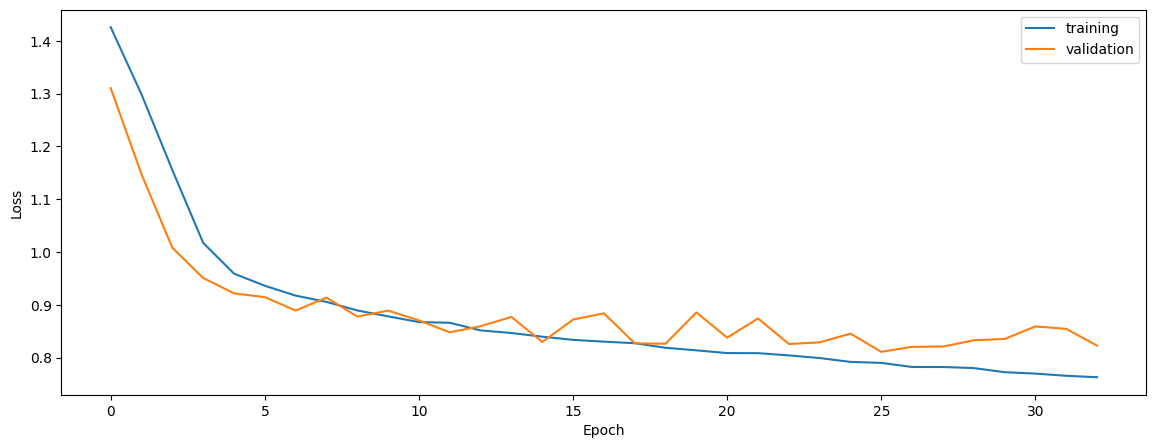

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6908027499401443
0.6793448127156234
0.6391590578271801


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.6908027499401443
0.6793448127156234
0.6391590578271801


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6985839390004492
0.6788660637079623
0.656877332487743


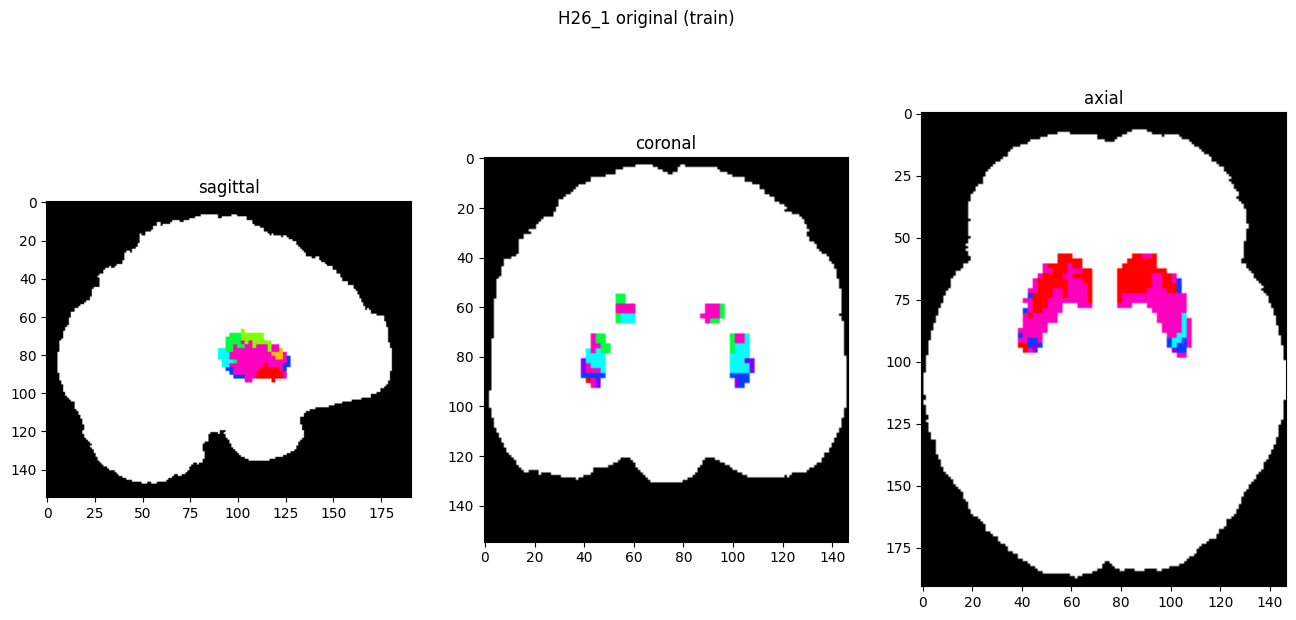

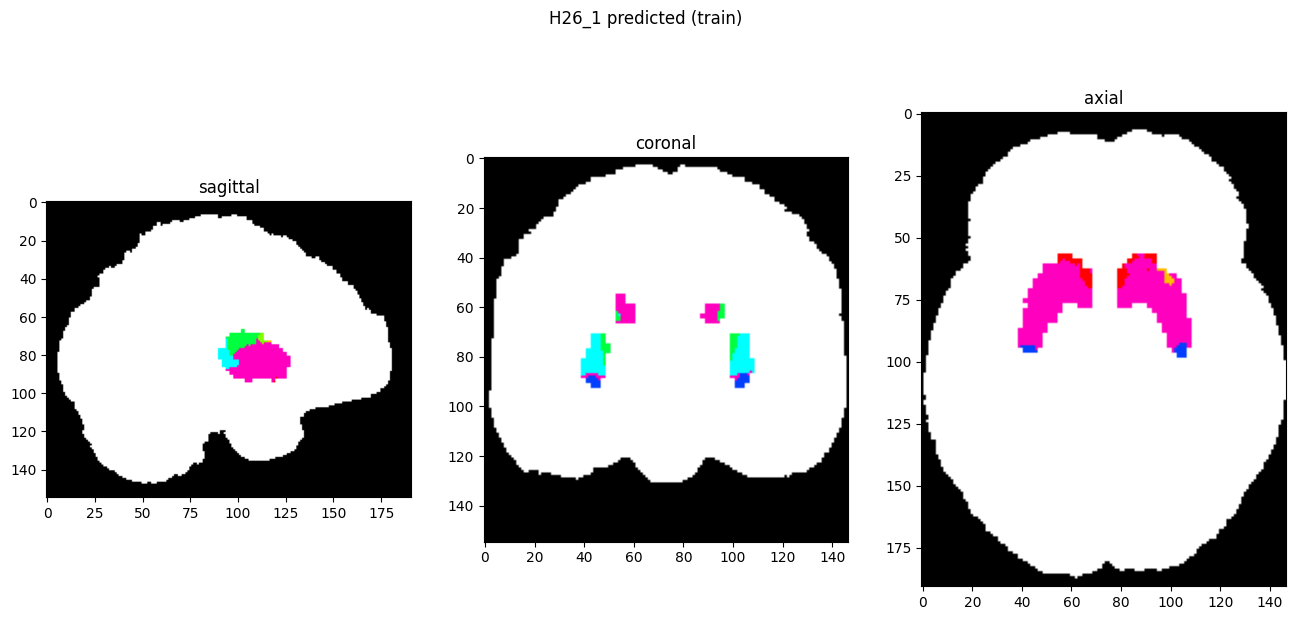

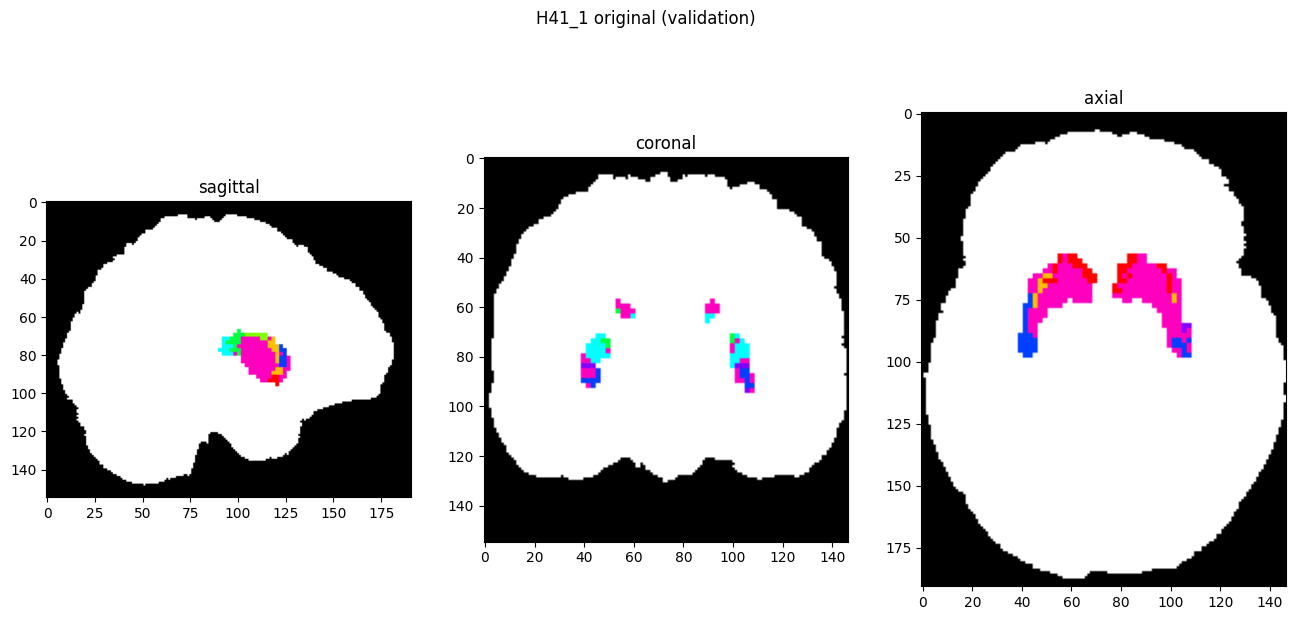

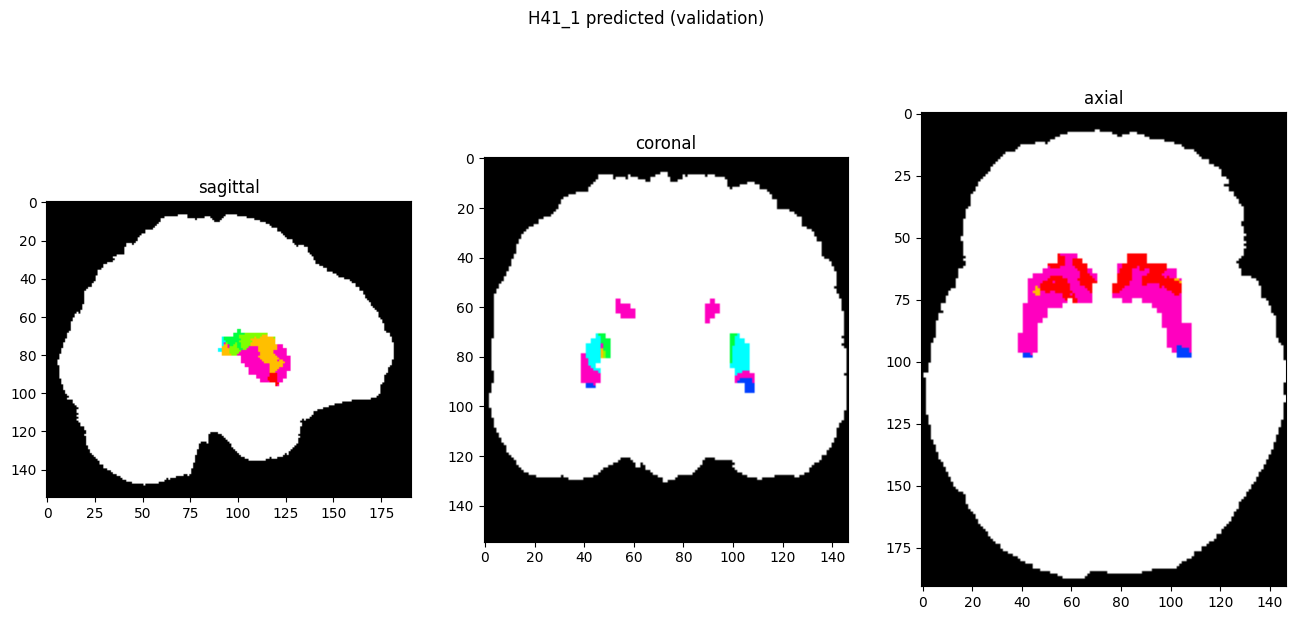

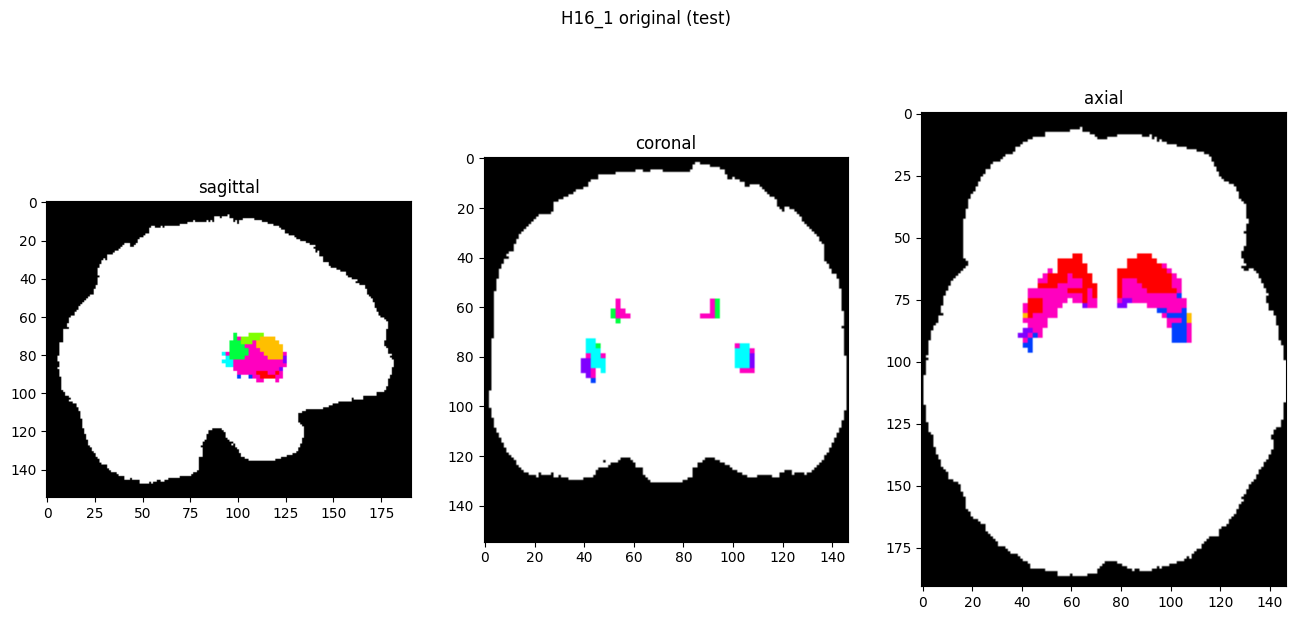

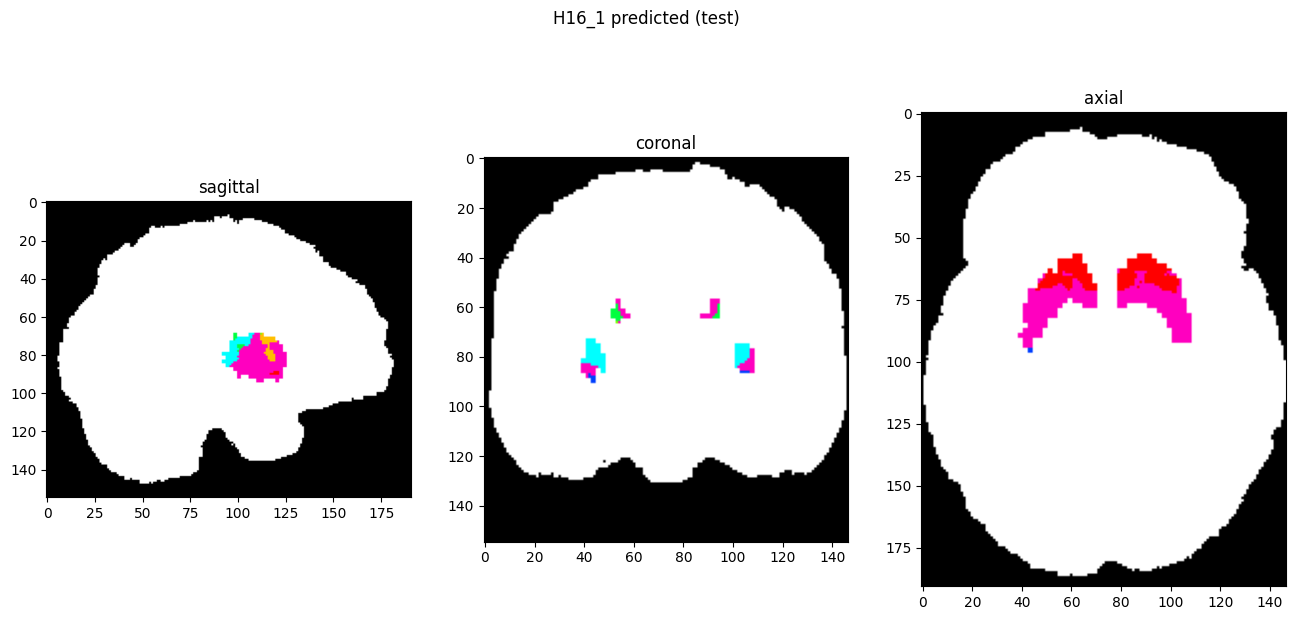

In [10]:
showResults(model, gen, threshold=0)